# Change Detection of Buildings from Satellite Imagery

## Table of Contents
* [Introduction](#Introduction)
* [Export training data for deep learning](#Export-training-data-for-deep-learning)
* [Model training](#Model-training)
 * [Necessary imports](#Necessary-imports)
 * [Get training data](#Get-training-data)
 * [Visualize training data](#Visualize-training-data)
 * [Load model architecture](#Load-model-architecture)
 * [Train the model](#Train-the-model)
 * [Visualize detected changes](#Visualize-detected-changes)
 * [Evaluate model performance](#Evaluate-model-performance)
 * [Save model](#Save-model)
* [Model inference](#Model-inference)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction

The World is changing every day and monitoring that change on ground can be a tedious and labor intensive task. so, is there a way to automate it? 

<img width="100%" height="450" loop="loop" controls src="../../static/img/change_14_20.gif" />

This notebook will walk you through how deep learning can be used to perform change detection using satellite images.

One of the popular models available in the `arcgis.learn` module of ArcGIS API for Python, `ChangeDetector` is used to identify areas of persistent change between two different time periods using remotely sensed images. It can help you identify where new buildings have come up for instance. This model is based upon the latest research in deep learning and works well with objects of various sizes.
The `ChangeDetector` model workflow consists of three parts: 
- Preparing the training data, 
- training a model 
- using the trained model for inferencing. 

Let’s first prepare the training data. 

## Export training data for deep learning

In the cells below, we have provided the input rasters and input mask polygons needed to export training data.

In [1]:
from arcgis.gis import GIS
gis = GIS('home')

<Item title:"change_detection_input_rasters" type:Image Collection owner:api_data_owner>
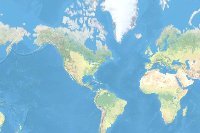

In [2]:
input_data = gis.content.get('3ebf8ca5f6c245d69e2e0f4358986ed3')
input_data

<Item title:"cd_input_mask_polygons" type:Feature Layer Collection owner:api_data_owner>
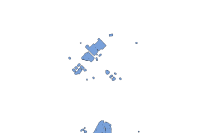

In [3]:
mask_polygons = gis.content.get('6ee0b48611c44b31b499f6cbe202686f')
mask_polygons

`ChangeDetector` model requires data in this folder format : images_after, images_before and labels folder. The label indicates where there are changes in the before and after images.
These images are too large to process in the GPU memory for training the model, so we need to create small image chips or tiles. Training data can be exported by using the `Export Training Data For Deep Learning tool` available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) as well as [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server).

- Input Raster: 2014rasters
- Tile Size X & Tile Size Y: 256
- Stride X & Stride Y: 64
- Meta Data Format: 'Export Tiles'
- Environments: 0.3

<div>
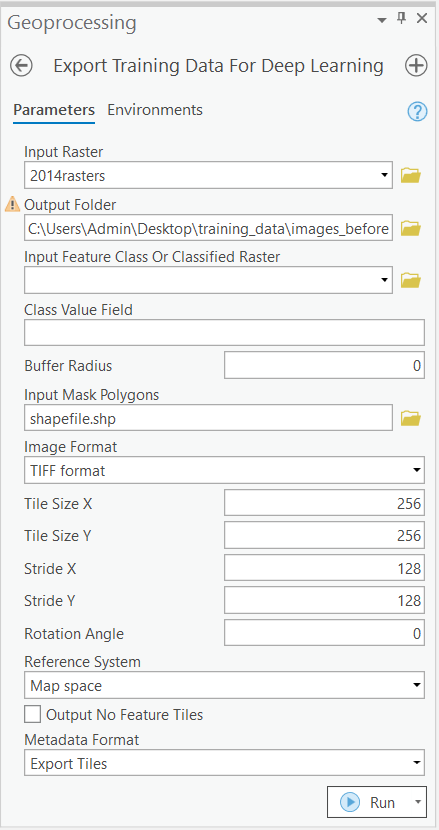
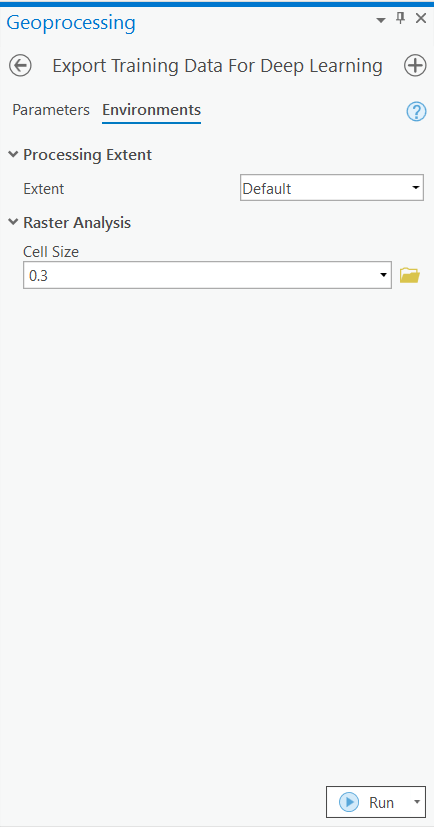
</div>

As shown below, the above tool needs to be run thrice each for image before, image after and the change labels in order to create training data.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAA9EAAAG0CAYAAAA1lqSzAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7L0HfBzXee6dm1/6l3tviquq5Z7EcewkjmMnjp3EdmLHdtq9SZwbp9pxjS2XuMeKbVlyUbEkSpQoFrGTIAmA6B1Y9N6BRVnsYnvvHe35znMWQy4hkAAtUCKo95Ef7+6cMmfODIbzn/fMmR+DSCQSiUQikUgkEolEom1JIFokEolEIpFIJBKJRKJtSiBaJBKJRCKRSCQSiUSibUogWiQSiUQikUgkEolEom1KIFokEolEIpFIJBKJRKJtSiBaJBKJRCKRSCQSiUSibUogWiQSiUQikUgkEolEom1KIFokEolEIpFIJBKJRKJtSiBaJBKJRCKRSCQSiUSibUogWiQSiUQikUgkEolEom1KIFokEolEIpFIJBKJRKJtSiBaJBKJRCKRSCQSiUSibUogWiQSiUQikUgkEolEom1KIFokEolEIpFIJBKJRKJtSiBaJBKJRCKRSCQSiUSibUogWiQSiUQikUgkEolEom1KIFokEolEIpFIJBKJRKJtSiBaJBKJRCKRSCQSiUSibUogWiQSiUQikUgkEolEom1KIFokEolEIpFIJBKJRKJtSiBaJBKJivSG+8fwU18YwU98cQQ/+SWxWCx+bvw/7hzCV6tsuL/WvH52EolEItH1IoFokUgkKtL3mhbxjVon/qtud/jrmywTi8XXj7/R4MY3Gj3ad/Gz3r0hj2vD74K/VuNE1YQP362aWj87iUQikeh6kUC0SCQSFSmRiKv/X1FeLjJ/b1x2Pfh6bZdYLC6Yf595YDV70VgqSqdX183va8rG3/QKVvJp3F05qb6LRCKR6HqSQLRIJBIVyR2MIJvLI5PLIZfPY3kph3gqi6hyKptTaTmd9lyb7Ygm0vDGs9dNm8Ti56P597fRRtryyipGRkdxuqQEZ86cwclTpzA7N4f80pLOl8svwe5wIBQOY2V1FU6nC4FQaD0tj2QyKRAtEolE16EEokUikahIzkBUX7zm8jnks1lMOuMwWaJonQlj1JNEVi1fXspjdTmPJfWdF7tL679X1GdO/c6rT343ljEPy6ysl8mr+plG5zfUwXxcN/Pyt1Efvy8poGfbmIbVJcwsRtBoTejlRn6WZ31GGdpog1gsvjZeWl7WEMzP4uUU4fkrX/kK7rrrLnz+859HS0vLhXws097RgcbGRtgWF1Gi8s5bLOvnIIFokUgkul4lEC0SiURFcq1DNOGzdzqIBzp8aFmIoXM+gq7FuLr4zSMaT8MWSiGeUXCsfscS6ncgBVc0o2E4lsrAH1PLgkkdKSYohxMZuCMphFJZ5DJZLKry1lBaR6tYJp7M6PzumKpD5XeHU3BG07psOsO0FPyqjqwCe7sq61XfXf4ERn0pJNT6fGp9i6p8WNXP+lLpDKyqjEPVE0gWotVisXhnzXNFLBbD5OQkRsfGMD4xgaj6baQTkpubm2G1WhGORDCh0vv6+4si0Xlk1N/00aNHcc+996JJ5S1OE4gWiUSi61MC0SKRSFQkRqIZxV1Kp/DpEivGwxmsrSpwVsDM5eFoCiUDfhzt86FkMopALIXSIT/OjAbxRLcPlmgWHWM+/LA7gJJhPx7t8itwzuBYlwcHBwMY9yVgmgzi2EgQ+3t8aLUlEE+kUK7ynlTpjQrYRywRHB/04/Eur8qfROWgF08NBjHsSaBj0o99fQG0K6CftoZwfj6OkZkA7lOwf3rAh6eGQ0goSK8d8ePIcBD72lx4ZCCMrLogNy7sxWLxzpjAGw6HceDgQXzmzjux78kn4Q8ENAAznRBdX18Pn8+nf8/NzaGru/sCKPPTq9LOlZZi//79aGxq0hDO8gLRIpFIdP1KIFokEomKRIheWl5CNBzDv562I83vCpTLh3w4Ox1FRY8Ld9Z40GkO4gvVLhztdOGezgCSCrArul14SAHrkUYbvmAKIpXP4fsVNtQpMP7caQvO21JwucL4VJkDrnQONnsIn610oWrIg7tNfg3qsVgSnzpuwampCA62OLBnIIivnLXi6HgYvkQGD/KVN71B2GIZdAw6cVdPGDWdDnyyUZWPJ/CxM4vonQ/h0+UOeDN5tPU78S+VHg3RHBpuXPyLxeKd8fLKCjxeL46fOAGX233JkG5CtMlkQrcCZ0aqm1taMDQ8fAGimd7Z1YWe3l4NzRUVFViwWnW6QLRIJBJdvxKIFolEoiI5AxHkFBDnUyl8sdSGbk8KmWwOveMefKTSjUPNdny21o16cxhNliieaHJg30gES6vLGJr0414F1MdNduwdj2F5dQmHmuw4Mx3B3dWLmEnmsWAL4s5qNxLqIjkZjeOLFQ481qrqGFbrXVbrVRfNHzo8jyMjCo4nguhzJTG6EMbXKhaxVy2bd8dwb60d3+sOoHXQje/0RVDX7cQjI1HV+gw+W2pHxYgXn6v1IK0u5qfNXnym3ouMQLRYfM1MkCYQ87N4OWE4EAzqycQMR6KFR0aYzs+E+ptfVmUJ35wvIanOPUaaQLRIJBJdnxKIFolEoiI5AmF1AZvHmgLavukAHun2YcCZQNuYD9/qCGDSGsb9Jh8mPAnYohks2CO4r82Lfmcc+01utCvoPdW2iE8ocO23RXBXnQuWUBoPNzkxFc0im0zh4WaXHrZdM+rDgeEwZuxh3NPkQbdaNqbqPdLuxrnpKCbcCfgTaZjVZ4vKe3e7Vy8bmwvhLpW/ZcyLPQqe24Y82DcWU23O4K5qJyY9MdzX4EKHPa4gfhEfqfZKJFosvsY2wHijCdara2vafIHVxsnHjKg0zTqKAVsgWiQSia5PCUSLRCJRkRz+iL545YRfnAHb4lKwOxVG5UQIU8E0VlfyGLFGUDUewqg3iRX1e17lqVbpXfaEqmEJJ1oW8d+mAKomVR5/CqvLOQ3CoRQvqPOIRFKongqhdjaKRLYw0/asM6rrHGbkO5VGnSpbbY7Cn0yjezasvkcQSmcwuhBBzWQY9lgGwXASM6pNnkACcwrUOQnZmIL5ZDYHmwLpGnMI+5scuEvBP6PrAtFi8e6xQLRIJBJdvxKIFolEoiI5/OELkSCC9JoCXIKx9nJhOdYKv9cUHPP3hTyrBOI8SjudKJlPqmXL+rcuo/Lk1Se/c0ZvnV/Vw5m4DWA36uQEZsXpRtrK0qX5OFM41Cdfb2W0hWXyCrZ7rDFY/AkcMHnQ7kxeeJWWWCzeHRaIFolEoutXAtEikUhUpGKINkzIpTcu2/ib5jubHQperZHMFSO/W9W5Mf1y3zdzPpdF73wYtZMh9CqAXl4HbLFYvHssEC0SiUTXrwSiRSKRqEibQfTVmIC7urKEVQXTm6U/Wzai5UYkXCwW7y4LRItEItH1K4FokUgkKpLxTPRmF7W7zVtFrMVi8fVrA6K/IxAtEolE150EokUikahI+hVXPyJEv+H+MfzUF0bwE18cwU9+SSwWi58b/487h/BVvlO+1rx+ZhOJRCLRTkogWiQSiYr0TCLR32taxDdqnfivut3hr2+yTCwWXz/+RoMb32j0aN/Fz3r3hjyuDb8L/lqNE1UTPny3amr9zCYSiUSinZRAtEgkEhXpmTwTnUjEVQ0rystF5u+Ny64HX6/tEovFBfPvkzP+Zy+a8xxckmd13fzOt1Abf9MrWMmn5XlqkUgkukYSiBaJRKIiXW44N5ctLS9r55eWNs3jDkbUZ+Ed00xfXsohnsoiqpzKFvIw7bk22xFNpOGNZ6+bNonFz0cb545iG2nLK6sYGR3F6ZISnDlzBidPncLs3Jw+/zBfLr8Eu8OBUDiMldVVOJ0uBEKh9TSZlEwkEomupQSiRSKRqEibDecmOPMzGo0iqC5So7GYzmNczBp2BqJ6eS6fQz6bxaQzDpMlitaZMEY9SWTV8uWlPFaXFZCvv7d5af33ivrkK7H4jmh+N5YxD8vwXdAsk1f1M4023v1s1MF8XDfz8rdRH7/z1VtsG9P4rumZxQgarQm93MjP8qzPKEMbbRCLxdfGPL8Qgo3zjGGK8PyVr3wFd911Fz7/+c+jpaXlQj6Wae/oQGNjI2yLiyhReectlvVzkEC0SCQSXUsJRItEIlGROJw7qy5AjQtZgnI8kcDM7CyGhobQ39+PgcFBfbGaSqf1xaqR17UO0YTP3ukgHujwoWUhhs75CLoW4+riN49oPA1bKIV4RsGx+h1LqN+BFFzRjIbhWCoDf0wtCyZ1pJigHE5k4I6kEEplkctksajKW0NpHa1imXgyo/O7Y6oOld8dTsEZTeuy6QzTUvCrOrIK7O2qrFd9d/kTGPWlkFDr86n1LaryYVU/60ulM7CqMg5VTyBZiFaLxeKdNc8VsVgMk5OTGB0bw/jEhL5BZ6QTkpubm2G1WhGORDCh0vvU+ediJDqPjPqbPnr0KO659140qbzFaQLRIpFIdO0kEC0SiURFsvsjFyCaF6IE5Z6eHnR0dmqQttpsekglI0LDw8P6Ita46GUkmlHcpXQKny6xYjycwdqqAmcFzFwejqZQMuDH0T4fSiajCMRSKB3y48xoEE90+2CJZtEx5sMPuwMoGfbj0S6/AucMjnV5cHAwgHFfAqbJII6NBLG/x4dWW0IBfgrlKu9Jld6ogH3EEsHxQT8e7/Kq/ElUDnrx1GAQw54EOib92NcXQLsC+mlrCOfn4xiZCeA+BfunB3x4ajiEhIL02hE/jgwHsa/NhUcGLr2pIBaLd8YE3nA4jAMHD+Izd96JfU8+CX8goM87TCdE19fXw+fz6d9z6rzT1d19AZT56VVp50pLsX//fjQ2NV0YJSMQLRKJRNdWAtEikUhUpGKIXl5ZwfDICLq6uvR3RosW7Xadj0MqeYFrWVi4cNFLiF5aXkI0HMO/nrYjze8KlMuHfDg7HUVFjwt31njQaQ7iC9UuHO104Z7OAJIKsCu6XXhIAeuRRhu+YAoilc/h+xU21Ckw/txpC87bUnC5wvhUmQOudA42ewifrXShasiDu01+DeqxWBKfOm7BqakIDrY4sGcgiK+cteLoeBi+RAYP8pU3vUHYYhl0DDpxV08YNZ0OfLJRlY8n8LEzi+idD+HT5Q54M3m09TvxL5Ue3R8cGs5tFIvFO2eeVzxeL46fOAGX233JkG5CtMlkQrcCZ557mltaMDQ8fAGimd6pzk09vb36HFRRUYEFq1WnC0SLRCLRtZVAtEgkEhWpGKIZha6qqtLR5onJSTz80EMYGx+HXYF0KBTSF798HtGIRutJyRQQ51MpfLHUhm5PSqXl0DvuwUcq3TjUbMdna92oN4fRZIniiSYH9o1EsLS6jKFJP+5VQH3cZMfe8RiWV5dwqMmOM9MR3F29iJlkHgu2IO6sdiOhLpKT0Ti+WOHAY62qjmG13mW1XnXR/KHD8zgyouB4Iog+VxKjC2F8rWIRe9WyeXcM99ba8b3uAFoH3fhOXwR13U48MhJVW57BZ0vtqBjx4nO1HqTVxfy02YvP1HuREYgWi6+ZCdIEYn4WLycMB4JBPfLFcCRaeGSE6fxMqL/5ZVWW8M35EpLq3GOkCUSLRCLRtZNAtEgkEhXJgGhewPrVBWxTUxNW19bw2N69+OY3v6mHXu559FGcr6jQkF1XW3vhwtURCKvPPNYU0PZNB/BItw8DzgTaxnz4VkcAk9Yw7jf5MOFJwBbNYMEewX1tXvQ749hvcqNdQe+ptkV8QoFrvy2Cu+pcsITSeLjJiamoAvVkCg83u/Sw7ZpRHw4MhzFjD+OeJg+61bIxVe+RdjfOTUcx4U7An0jDrD5bVN6727162dhcCHep/C1jXuxR8Nw25MG+sZhqcwZ3VTsx6YnhvgYXOuxxBfGL+Ei1VyLRYvE1tgHGG02w5vmH5gusNk4+ZkSladZRDNgC0SKRSHTtJBAtEolERTIgmhehfL6wrq5OX6hy6PZ9992nodrU3q4j05zsh8s5eRcvXI2ZvTnhF2fAtrgU7E6FUTkRwlQwjdWVPEasEVSNhzDqTWJF/Z5XeapVepc9oda+hBMti/hvUwBVkyqPP4XV5ZwG4VCKF9R5RCIpVE+FUDsbRSJbmGl71hnVdQ4z8p1SYK/KVpuj8CfT6J4Nq+8RhNIZjC5EUDMZhj2WQTCcxIxqkyeQwJwCdU5CNqZgPpnNwaZAusYcwv4mB+5S8M/oukC0WLx7LBAtEolE11YC0SKRSFSkjc9Et7a1YW5+XkeAahVQuz2e9ZzQs3QXP6PImb2NSBBBek0BLsFYe7mwHGuF32sKjvn7Qp5VAnEepZ1OlMwn1bJl/VuXUXny6pPfOaO3zq/q4UzcBrAbdXICs+J0I21l6dJ8nCkc6pOvtzLawjJ5Bds91hgs/gQOmDxodyYvvEpLLBbvDgtEi0Qi0bWVQLRIJBIVqRiiCc6cLbehsVFPKEaAttlsOgJtnpnRz0MnEokLF67FEG2YkEtvXLbxN813NjsUvFojmStGfreqc2P65b5v5nwui975MGonQ+hVAL28DthisXj3WCBaJBKJrq0EokUikahIxRBNc8Ifzprb2tqqo858pytnw20zmfTkYsXPKG4G0VdjAu7qyhJWFUxvlv5s2YiWG5FwsVi8uywQLRKJRNdWAtEikUhUpI0QTXNSH87AzSj0tNmso9Icwr1xNl3jmejiZbvVW0WsxWLx9WsDor8jEC0SiUTXRALRIpFIVKTNINq4KDVmyGV0ejNY1q+4+hEh+g33j+GnvjCCn/jiCH7yS2KxWPzc+H/cOYSv8p3ytebCSVEkEolET5NAtEgkEhXpchC9HT+TSPT3mhbxjVon/qtud/jrmywTi8XXj7/R4MY3Gj3ad/Gz3r0hj2vD74K/VuNE1YQP362aWj8rikQikWijBKJFIpGoSM8Mon/0Z6ITibha+4rycpH5e+Oy68HXa7vEYnHB/PvkjP/Zi+Y8B5fkWV03v+sxNuvfV7CST8vz1CKRSHQFCUSLRCJRkZ4JRF9uODeXcQIyms9Sb5bHHVTrzRXeMc305aUc4qksosqpbCEP055rsx3RRBreePa6aZNY/Hy0ce4otpG2vLKKkdFRnC4pwZkzZ3Dy1CnMzs1deB1fLr8Eu8OBUDisH09xOl0IhELraTIpmUgkEm0lgWiRSCQq0k4P5zZm745Gowiqi9RoLKbzGBezhp2BqF6ey+eQz2Yx6YzDZImidSaMUU9StUldGC/lsbqsgHz9vc1L679X1CdficV3RPO7sYx5WIbvgmaZvKqfabTx7mejDubjupmXv436+J2v3mLbmMZ3Tc8sRtBoTejlRn6WZ31GGdpog1gsvjbm+YUQXPyWAJoiPH/lK1/BXXfdhc9//vNoaWm5kI9l2js69Gv6bIuLKFF55y2W9XOQQLRIJBJtJYFokUgkKtIzHc5dXJagHE8kMDM7i6GhIfT392NgcFBfrKbSaX2xauR1rUM04bN3OogHOnxoWYihcz6CrsW4uvjNIxpPwxZKIZ5RcKx+xxLqdyAFVzSjYTiWysAfU8uCSR0pJiiHExm4IymEUlnkMlksqvLWUFpHq1gmnszo/O6YqkPld4dTcEbTumw6w7QU/KqOrAJ7uyrrVd9d/gRGfSkk1Pp8an2LqnxY1c/6UukMrKqMQ9UTSBai1WKxeGfNc0UsFtOv3BsdG8P4xIS+QWekE5Kbm5thtVr1e+0nVHqfOv9cjETn9RsHjh49invuvRdNKm9xmkC0SCQSXVkC0SKRSFSkZwLRxWV5IUpQ7unpQUdnpwZpq82mh1QyIjQ8PKwvYo2yjEQziruUTuHTJVaMhzNYW1XgrICZy8PRFEoG/Dja50PJZBSBWAqlQ36cGQ3iiW4fLNEsOsZ8+GF3ACXDfjza5VfgnMGxLg8ODgYw7kvANBnEsZEg9vf40GpLKMBPoVzlPanSGxWwj1giOD7ox+NdXpU/icpBL54aDGLYk0DHpB/7+gJoV0A/bQ3h/HwcIzMB3Kdg//SAD08Nh5BQkF474seR4SD2tbnwyMClNxXEYvHOmMAbDodx4OBBfObOO7HvySfhDwT0eYfphOj6+nr4fD79e06dd7q6uy+AMj+9Ku1caSn279+PxqamC6NkBKJFIpFoawlEi0QiUZF2CqL5DunhkRF0dXXp74wW8f3SFIdU8gLXsrBw4aKXEL20vIRoOIZ/PW1Hmt8VKJcP+XB2OoqKHhfurPGg0xzEF6pdONrpwj2dASQVYFd0u/CQAtYjjTZ8wRREKp/D9ytsqFNg/LnTFpy3peByhfGpMgdc6Rxs9hA+W+lC1ZAHd5v8GtRjsSQ+ddyCU1MRHGxxYM9AEF85a8XR8TB8iQwe5CtveoOwxTLoGHTirp4wajod+GSjKh9P4GNnFtE7H8Knyx3wZvJo63fiXyo9uj84NLy4n8Ri8TM3zyserxfHT5yAy+2+ZEg3IdpkMqFbgTPPPc0tLRgaHr4A0UzvVOemnt5efQ6qqKjAgtWq0wWiRSKRaGsJRItEIlGRNoPovLo4JeAuqYtWPldcnFbs4rKMQldVVelo88TkJB5+6CGMjY/DrkA6FArpi18+j2hEo/WkZAqI86kUvlhqQ7cnpdJy6B334COVbhxqtuOztW7Um8NoskTxRJMD+0YiWFpdxtCkH/cqoD5usmPveAzLq0s41GTHmekI7q5exEwyjwVbEHdWu5FQF8nJaBxfrHDgsVZVx7Ba77Jar7po/tDheRwZUXA8EUSfK4nRhTC+VrGIvWrZvDuGe2vt+F53AK2DbnynL4K6biceGYmqXsvgs6V2VIx48blaD9Kqv6bNXnym3ouM6g+BaLH42pggTSDmZ/FywnAgGNQjXwxHooVHRpjOz4T6m19WZQnfPK8l1bnHSBOIFolEoitLIFokEomKtBGic+piNORzYd4yD+uiC0kFtkvLK/qilReenAV3eaUw67ZRlt/96gK2qakJq2treGzvXnzzm9/UQy/3PPoozldUaMiuq629cOHqCITVZx5rCmj7pgN4pNuHAWcCbWM+fKsjgElrGPebfJjwJGCLZrBgj+C+Ni/6nXHsN7nRrqD3VNsiPqHAtd8WwV11LlhCaTzc5MRUVIF6MoWHm1162HbNqA8HhsOYsYdxT5MH3WrZmKr3SLsb56ajmHAn4E+kYVafLSrv3e1evWxsLoS7VP6WMS/2KHhuG/Jg31hMtTmDu6qdmPTEcF+DCx32uIL4RXyk2iuRaLH4GtsA443mOYrnH5ovsNo4+ZgRlaZZRzFgC0SLRCLRlSUQLRKJREXaCNF8i6qp9BAOlpTjxKGD6DPbEYkwkuxHMpNBKOCH2+9HLBa9UJYXoXy+sK6uTl+ocuj2fffdp6Ha1N6uI9Oc7IfLOXkX12PM7M0JvzgDtsWlYHcqjMqJEKaCaayu5DFijaBqPIRRbxIr6ve8ylOt0rvsCdXKJZxoWcR/mwKomlR5/CmsLuc0CIdSvKDOq3anUD0VQu1sFIlsYabtWWdU1znMyHdKgb0qW22Owp9Mo3s2rL5HEEpnMLoQQc1kGPZYBsFwEjOqTZ5AAnMK1DkJ2ZiCed5gsCmQrjGHsL/JgbsU/DO6LhAtFu8eC0SLRCLR1hKIFolEoiJthGhGcGoO/xDnu8ZRc+JRnGsewnCfCYee3I/eCTPOHNyHyrZe2BfmLinLKFBrWxvm5ud1BKhWAbXb4ymsRImzdBc/o8iZvY1IEEF6TQEuwVh7ubAca4XfawqOdduMPKsE4jxKO50omU+qZcv6ty6j8uTVJ79zRm+dX9XDmbgNYDfq5ARmxelG2srSpfk4UzjUJ19vZbSFZfIKtnusMVj8CRwwedDuTGrAZrpYLN4dFogWiUSirSUQLRKJREXaDKLrjj2Ehw+ewPnKWszNzaKluQn77vsm9p0ux71f+zrGnGHMjCiQLipLcOZsuQ2NjXpCMQK0zWbTEWjzzIx+HjqRSFxYTzFEGybk0huXbfxN853NDgWv1kjmipHfrercmH6575s5n8uidz6M2skQehVAL68Dtlgs3j0WiBaJRKKtJRAtEolERdoI0RzO3VyyD2ebB5BTP4Lzvbh/zyGcPfw4TlTUYv/Dj8OTTKP8yKNPK8sJfzhrbmtrq446852unA23zWTSk4sVP6O4GURfjQm4qytLWFUwvVn6s2UjWm5EwsVi8e6yQLRIJBJtLYFokUgkKpKDs2QXwSxn5LbNjMPqCesh2ul4GD09nejs6MSUxYqx4VFE0gqCF6aeBtE0J/XhDNyMQk+bzToqzSHcG2fTNZ6JLl62W71VxFosFl+/NiD6OwLRIpFIdFkJRItEIlGRnh4Rzq6nrKj/5YE1xqY3SD8v/PQotmHWZ8yQy+j0ZrCsX3G1yXKxWCx+Nm1A9N0VAtEikUh0OQlEi0QiUZGKIZrPFqczWYy5oxh0RjG07kFnBIMOZX53GMsuzs698aJ0O76RItFisXj3muehVCqJr5aMrp8VRSKRSLRRAtEikUhUpGKI5nugo6kMvlxnwSfLZ7f0M4PoZ/ZMtFgsFu+ENUSnU/jcoc71s6JIJBKJNkogWiQSiYr0tEh0Nof5QAJmbxxm35X9TCD6csO5uYwTkNF8llpAWywWPxPzPGKcT4xzS3E6zzHJVBrfOtO7flYUiUQi0UYJRItEIlGRNosIY4WzTSvz8wre6eHcxsVtNBpFMBRCNBbTeYx3S4vFYvHVmOeUeCIBl8sF2+IiHE4nIur8UnxO4TkmkUziu9XyTLRIJBJdTgLRIpFIVCRC9I8Kws90OHdxWV7U8mJ3ZnYWQ0ND6O/vx8DgIOYtFqTS6acBt7jg4ujald6XvR1v7OP8er30lW5kMB8fBdi4PJdn267uBkihzPr2XG6fq+VbHQ9G2/NL2ztuWN+Fbd2i7u14u+vdyrkltkluIv0o5r4MBIP6PNLe3o6uri6Y1Gd3Tw+cCqqNY4ifiWQC91SZ18+KIpFIJNoogWiRSCQqkhGJzuXVxSQvKIsuQrfyM4Ho4rJcP0G5R13cdnR2apC22myYnZtDS0sLhoeH9WuzNtYhziGdTunIfSQaV33EviwsL+zTdSsANpbTBGIu17/X82joU318YbmqKxaLIpZIIB6Pqc9koS6dbtSpyimHgz6E46kL6QUvIZWIwBcs3CwxlhW3w6ij+JjLZDKIqfUxWphW61lah/dC2fV1My+PV+31thfVQScVFLGOWDKpf+t8unwhvdCeonLZjNrOuC6TzBDA1sF1Q7mNvwv1XLpddEbVV/zqs43ru7g9l6Zf6iUkYiH4w7FL+3C9DPuC287lRj3igtknvCnX1Nyszx9pdVyZzWb4/X7Mzsygrr4eXp/vwt9CAaKn18+KIpFIJNoogWiRSCQqEiGaF/tpBVCEsAvecFG6mXcKovkO6eGRER0p4vfRsTH9fmmK0aR6dcFrWVgQWLjECjDzKfR3tqGrpw8Dw+MIKZDNK/grRI2zBeBTkJVMp9UnI7uFyDAnUcqq70zTEKHqy2QSGBsahC/CNNXPmRTMU6NobqhFY4sJk/OLunwqndHrT6ZS6hjJY21tFRMD7Zi2B7HMKK5abyqTxfIaEHKYYRqYQFatY0mtK5VK68gq9yPbyRsnuh3rAMrylslBtHR0o6+/F/1DY4gkMyp/TpVNqWM0j+XVVbht05icdegyhFVu3wXoVetKR3xobmlBb18/pi125JZXNCSz7TyedN+tr5/HOpe5LZNoau1A/0AfevoH4Y8k1yPsat2sX9Vr9JXx2+hDPk9b2K7CfsmloxgcHEYsVdgu9n02x/VndR1cprfHgGDWzfVkuJ+4DpVX9eGK6kPP/Ai6x+Z1/YV9mSnkUX2o+1S1ZeNNEnHhnMII9ODQkD6PUHv27MH4+Lj+brFa0dbWpvMKRItEItHWEogWiUSiIvHZZLcCJ3soBV8sg3Ayi0RaXdAruCAQbLw4LfZmEF0YRqugSV3EXmlYbHFZgkBVVZUCmiwmJifx8EMPYUxd7NoVSIdCIXi8XjQ2Nur0jfU8b51fxlo+jCcefhB9kwtwuDzwe+yYmLUqAI5jcnoWzsUFTExPY2J8GFMagvNw2Syqb8cwOmFGUu1j+7wZIxNTWJibwAP3fhutg/N63xPkgkEvTj3xAI5WtKp0M4ZGRzG74FDLfTBPTykgmUI8k8PcxDDsgRicCzMYn5rWkT+H+h3xWDFstiEW8mJkfEK1Y1TBr2qfgk+XbR6jY+MYUuBudQV024A1NJzch7PNA7AvWlB+4hBqOsaRTEYxOzONsbEJdXym0XpuHx55qkKBbgyLVouqdwwWh1cfT3lFnrHFUdy/5xDmbHZ4AhEkoiFMTY5jZHgUdl8YqVgQI6MjmJyxIJ7K6PeZD9WdwoGyFjgcNjSUn8SZ6g4N6FbLLMZV2UV3QIF4Ggvz6vfEOBy+CIJuO8bU9k6Mq7rUdhHy9fDrhAuPP7YP3ljhJkUmFce8av/4xAQ8wZiOLs+Y1faoPgkl0vA5FlTfjsHmcGN+dkrtO9WHQ8PwRpPwL85gYsGNiM+B0fFJjI+NwLzg1P21qPYd/04GFSw61d8Tl216rDwPzb6orqnRIwts6jzCkS3f//73CzfkLBZ1DAdRs57OvALRIpFIdGUJRItEIlGRCNFT7gRGHHFYAmm4owqkU1k9pJWRxiuB9EaIZkQs5HNh3jIP66JLQ9rS8oqOChGol1dWlRlRuzgpGb/71QVtU1MTVtfW8NjevfjmN7+JAwcPYs+jj+J8RYWG7LraWh39LF7/89oKRFdzERx6Yi+GFKi6/SGEvRYcOXIcrY01KK3rQHf1STz0VAlGBntVfx7B9NwUThw9iQEFaGeOHcKg2Y7ypx7GwdIGzM2M4aEf3IvWgVm13wpRbMp0/hhax+xwDjfi7oefVDDugNtpRU93B5545AEMzrrRfO4Yhm0B1Bx7FIfPt6C99qwCbxMcY504Wd8H57gJ33n4AIZVO/Y+cRCLLjuOP3VYR3wPP/Z9lDSO6GgwIbr53FF0mT163Un3FB56/Ai8Ctr7e7px7MmHUds9gbbyg3jsaCV84TDGRwbRUHkaew6WIJZe0hAdt09gz/7jsNjdeji3qbYMlY0m9LU34sjZWrjMA/jm9x5E//gsYusQPdJYiqreGf19LeXDI488oUC2C08dOYX66rM4dKoKE8Pq99ES1FWU4Mi5JvQ3leLBAycwMtSL/fsPYN4bLdxESrhx8MBh+OJ5dUyvYKyzHkdPlaLi7FGcrOxAKOhGX4+qa++DaB2xobfqKB5Q7V90eXDs8ftxtrEbDWVHUdoyjJnuOpzvmsZM13n84ImTGOwz4XG1TofdgsNqn/YrgH7s/ntQ3zd3Yej7892EYg7f5pBtPhN94sQJHDx0CF/96ldx//3344knnkBXZyfqGxt1Os9BAtEikUh0ZQlEi0QiUZEI0WZPAuOuOKzBNLyxDCIbIZqwq7zxYnUjRK+q+kylh3CwpBwnDh1En4K0SISRZL+qL4NQwK9gz6+ftTXK8oKXs3DX1dXpi1lGiu677z4N1ZwEiJHpcCSil/PCuHj9z2sriF7LR3Fgz4Oobe3EwNgUVlT/99YcxSc+/WUshHMYbijBOVNh+Gr1yUM4efownjzVqH8v9NbhRGUryo7tQ58lpJZkcfLwIXgSaxf29Zr6r+ncU2gYtGC+pxqHa/gKoDVYZycxNjmOo/seQH2PGY1nDmNwwYfaU4fQtxDBcsyKxw6dgXXYhGM13bCPtOGpig693lOHD8LUUoNHD53Xv8faz6G0aVgDoIbos0fQMeXSMBteHMcTh05izjKno7AVpx/H0co+zPRVoaZ7DrlkSEeXB3sbcO8PHkMwkdMQnXBO4gc/fFQPC19UsLnngQewGGXv5LBvz16MDLRj7/EqENu5rTxuhxvPoaJ7Wn/Php04dOgpdQw/iieOV2JsuA+VNfU4eeBhHDhdi/HBHpTXtKCj9ixKmgvDhauPPoG2Cbu+aWRAdDDNda7gyCPfw6lqE4Z72nC+rhWW+VmMTUzi3NE9KGkYRnfVMVT1WVTeVZw+uA/mYB4x1wj2n6zBdGc1StsnMd1eiZKWUZVnCYcOHERb3TkcPNvKVaO98hgaBaIvMW/K8Hlou8MBp9OpZ+X+gTqv8DyzuLiol9eq75yVWyBaJBKJtpZAtEgkEhWJw1KLIdqzCURzGHVKASyBlxec/OTyjRBN8Kk5/EOc7xpHzYlHcU4BxnCfCYee3I/eCTPOKECobOuFfWHukrKMVLe2tWFufl5f/PLi1u0pRCMpPts4NDys122s63lvHYkO49C+JzDjCiIaiyMe8aH81FE89thjaBuaw0D9aRwqa4HX40TJ8ZPo7W/H0ZPn4fJ40VlXhua+cVSdJAAHFOulcPrwfozMey+sg/uzANFzsPTWo6RxEGuraRx9/BG0D07h3JE9aOyfRePZoxi0+lBfcgS98wGkQgs4eKJcQ/Tx2h7YR9V6KzuxtraCs6eOYGCgG4ePnYPb61frfwxnL4Hop1DdPQm/z4f2+gq0D0+h6tR+VLQMoqVCgW1NP+YH63Gmthczw8149EAJzONduO+HTyK0DtEx2xj2n6hSuEnlcP7kEfSMW+C2z+Do8bOYG+vBobMNSOcLr1QjOI8oiD5Z1wOfWu9gZyNq2gfQ11yGE6WNsC7aEU6m0F13BqcqWmCzLyKcymGs+Rz2n61X/evB6SOHMeUMIU+ITrrx5OP7MGP3IByPoqbkKVQ09yigdyCZTqD08F7UdYyg7ux+lCow7qspQcOQgui1PM4cPoApbxJBxyiOnKtXEF2Dss5JmDuqcbZtVPf/sWNHMdTXhqNnalR7Azi5/0GJRG8wzymc2b/NZEIikdBHwuEjRzBtNiOv0vsHBjAyOqrPZbRAtEgkEl1ZAtEikUhUpI2R6I0QnV9aQchrw/DUnIZYPSmVWs4Lz80guu7YQ3j44Amcr6zF3NwsWpqbsO++b2Lf6XLc+7WvY8wZxsyIAumisgRnfyCAhsZGPaEYAdpms+kItHlmRj8PzQthYz1iZQXRK0spNFWXo6HFhM6eAUyO9qC6pR+JkAO1zZ3orD6t9sVJtDY1oKWHNyHyGGhvRmNLCxqaOxBNZzDU1YZ5bwQrq8t6grDmjkEkMlk9gRYn8RrvNWFswQPP3Kie4Gp5OYfh7jYFJx0oKz2NMYtH5WnHgqpjtKcds54o0jEPWjr74V2YRufILPy2abQPmRXYLKGnoxXuQBidLXVoaWvH3gfvRkXHlAbA1dUVTPS2oLymEe2tLWjtHkZuZRUzY71oamlHTcVZfXMgEXaiprYRU+YJNNQ1oqO1ASUVDXoiL0Js0m9DU8cAkjx+FUwFnHOora3Tx9f4vBtxz4Lqj1FkVB+yL7mdi5O9OFtRiw5TK5raehDNqLSEH/U1NRrERuecSEa8qK+uVb/bYXYEFESX4sH9R1X/NqKpc1BPFKYnb8tEUXu+DE2tJvSOTMPvXkCNKmdSfWZx+zE13I2W1nZUlp9Bz6QNc8M9GFH9uLKcR4+pBfZwGtGADabeUTjMI+g3O+A0D6N30qr6PwNTW5t+j3pTfTXaVdse+N630Ta2KBC9wQRpwnJXd7eORPNGHUe28BV6nFSMI1sEokUikWh7EogWiUSiIjkCV4bo5VVgcaoHp2taYJufxtDgEKYtDnicC0+DaEb0mksKE0Pl1I/gfK+e4Ons4cdxQgHK/ocfhyeZRvmRR59WdkWBjMvtRmtrq446T6qL3Z7eXg0wnFyMoG3kFRsuvAKKNxhi8YSeuZlAyGfPqeHmGjQreOXs1StrHKZdANV4Iq5hc1lBNfuVEJHRM18rAE0l1X6/uI7CDNUKNNR6OBs0jwnWwXXm1XqWVBrr4uzQzMu6dLv0d5bhyIUlta4C4OkJ53IpWOZnYJ6eREVZKczO0Hq5Qh1p1YZYIrXe5rw+NlIKcnJLqs0KNPX6+AqpPGcDz+hjdWVtVYM/62BdF46XLCF5DblMSk8itqrqMmYp1+nr5mzhmXRK9yPzc1u5fQRbLuMs3vy9vJRTv+N6KPi4SYF5/+SF/r04Q3Zh5mz2M18NtsT6VDv5yiWmraq28hVcOfXHxX7RM2+rNrPfdb+xDr0NTFvvQ/1ZyEM4zKXjmJ01wzw5hrLSMiz64xf6UFww+4PHDm/E8T3Rff39+hV6QyMj6ri4OFM68wlEi0Qi0ZUlEC0SiURF2ioSTYh2mAdR2dqOipMH0djShtNnqtFSf0YDePGFOwHJNjMOqyesL/TT8TB6ejrR2dGJKYsVY8OjiKRzcCxMPQ2iaU4sxqHjjEJz2CWj0rzQZV3F+cQXbQCjMczeADn2md+1qPZv+CKYaRuAe7G8URf3x8Yh8xfTVd3GcuYj4Blp65/FdRnfL67H+FQwmEtjYnRIv9Js2urW4FxcToP7hnYY6yuuh+3hp35NVNG6C+kbfxfyXS6d28dXUWlwLVrOfMX9V/ittmFlGQG3HXZf4QZPcZnicsWgdhHcL/afLmd8rucrruNivxfl4b7OxDEy1I/urm7MO/0atI1y4otmH3KEDPcDb2Lw/MLzzMZ+FogWiUSiK0sgWiQSiYq0nUi03TyA8qYWNFSVIhCL4vzpUtTWlmlAK74Y5buJC1pR/8sDa4WI6CVaLTypuhlE06yPF7m88GUU6dL6xVfjJdV/KyvXI1wVwIbie6Y3z3P9u9C/z9EICfV3caEPVTs2zSO+YJ5HjBtNm6UJRItEItGVJRAtEolERdrymWhF0X7HLHpGxjAy0I2Qgujern60NZy7BKIZJUtnshhzRzHojGJo3YPOCAYdyvzuMJZdnJ174wWtWCwWP5sWiBaJRKKtJRAtEolERdoKohk15GRifC6Uz3hySCRheaS3+RKI5jOd0VQGX66z4JPls1taIFosFl8PFogWiUSirSUQLRKJREVyBKJXjkQvLemZbV0uF9xut/70eL2wWS1Pj0Rnc5gPJGD2xmH2XdkC0WKx+HqwQLRIJBJtrR2H6H/8x3+87v1P//RPYrH4WfJuk3MbEG02m5Hh62B4wbnupaXlSyDaMFaWCs898/MKFogWi8XXgwWiRSKRaGvtOES/+tWvvu79qle9Cq985SvFYvGz4N0m5xbDuQnR8/PzWFszpjG6KEL0jwrCAtFisfh6sEC0SCQSba0dh+i3vOUt18xvfOMb8du//dt461vfumn6lcwyb37zm/H617/+AkiLxeJr792mrWbnNiCa79el4uGAHt4djCQuRKL52iEjQr3ZRepmFogWi8XXgwWiRSKRaGvtOET/4R/+4TXxH/3RH+HXfu3X8Fu/9Vt45zvfuWmeK5llfv/3fx+vec1r8MIXvhAvetGLxGLxs+Ddpu1CNCPR+WQQpoYGtLWZMDZdeCY6oy5C09ksMlmV3/CGi9TNfKNBdOFmgtwUEIuvR/NG39JSXtt41/jFNIFokUgk2ko7DtF//Md/fM3867/+63jTm96Ed7/73ZumX8nvete78Ad/8Af41V/9VbzkJS/BS1/6UrFY/Cx4t2m7EE3N9jSgoW9GfwdyCqIjcEdSsIdS8Kly4WQWiXQOKQXSnNW7+EJ1ozeD6PzyMpaWl7C0sqJn+y5OeyZeUvVeTZS82Lm8ao8qv1V7+Mw4Zy3fLG0nzP2w2XKxWHxlLy8VbvRFEuocpczvhGkjXSBaJBKJttY1h2hGgd/2trfpKLDht7/97TqyXJyPy4rzEHg35nkmEM0yl4PoF7/4xfjlX/5l/MIv/MIl5jKm3XTTTZfkvxpzXayH0e/N0neruU2/+Iu/qCONm6WLxYZ3m64GokeaKtExZcfqGrC2uqIhesqdwIgjDksgDXdUXaQWlb0SSG+E6JxaT8jnwrxlHtZFF5IKxJeWV7C8DtTLK6vKCmZVPi7jd5YpfC/8XlZtYl6Cr7GcvxOplL5QvphflVV5VlZX1cU0IbmQ92mRZPU7nYhiwbqg2mRHTG3bhXp1uWWdb1nVE/TYYXX59A0Ao52F74V6jXXwJkFx+1iHrq+ofXl1gZ9fKiynWT7Fid2Mtj6DmwJi8fPJS/kcgok0RlwxtFoiaJ6PYMQZRyCeUX9zhTwC0SKRSLS1rilEE4IZAX7f+96H//t//y/+3//7f/jrv/5rnWZAMiGbzywTcv/mb/5G5/nbv/1bXeYd73jHJfVdCaKNYdsbwdvw5SLR/H7zzTfj5S9/OV73utfp+vncNf2yl70M//t//28N1JuB9OXgmsuNNNbNem677banpROs/+f//J/4pV/6pQtpz5a53Vw/bxJsln45G33HofW/8Ru/ofutuD/py/WL4a3Si8287J//9b/+F17wghdcVdliX6lccRq/8+bAldb3o7bh+erdpu0P5wbCLjOqaltgsdrg8Xo0RBeX9W4oqyFaXaBuFsXdCNF84tpUeggHS8px4tBB9JntiERCaj1+VV8GoYAfbr8fsVgUXp8XwUgMqWQcXtUOl9uNQCigPj0avvPZNHwqTyCk8kTdKC2vwKIvglw2A59XLQ/HkE4n9Xd/KKLWE4bH40MsnVFtutjG/MoavHNDOHD0BDp6BuBT9YXVepxqfbFEAuFIVINtUn2fmxzG6KwNsaiqy+dX4K7a4HXD5Q2ovsghGg7B7XEjGI3rdfv9PpXm09vodHmQ4DD4TFJtjxexZBqJRExtpweeQBjJiA9NLa3wqHaHQ0FVf+CaRr3F4hvBBGjCcvVMGOemwjg+Fsbh4RBOqs8acwghBdd6LocbBKI3+/dILBY/f73TumYQTZgltP7zP/8zDh06hCeffBL33XcfDh8+jO9973v4h3/4B51O8GWexx9/HHv27MH999+vvzMPYboYpK8E0VxmPCu9GUhfDqIJTL/3e7+HL3/5y7p9n/vc5/CFL3wBX/va13D33Xfj//yf/6MhmEBllOF3gh3N70Z9/GSE1khj3W94wxvwxS9+UW/LrbfeqvMbUVz+/s3f/E090RnzG0DL6K5RB21EsQlvzMM6uMxYFz+vFoYNuOf3q4kmcxvZjr/4i7/Qry/63d/9Xd2ejW0q7hfWb+S5UrqxDVzOumguZ/+wn9heljXKbbTRNzTz8TfrNtZprNfIz3qMvEYa815ufcV52TZjudFWlqW5TtrIy2WXa/PzwbtNDgVp24FoY2Ix5/wkOju7MGddhEOB6ZXKEqIz2WwhikqYVnXxk8s3QjTn/q45/EOc7xpHzYlHca55CMN9Jhx6cj96J8w4c3AfKtt6YV+YQ3XFGRw+UYGJ4U4cPnoKZ08ewYnSSvV5HH1TVkwMtOPcuXN46vAZTE/04FP/8Vl0js1iuKdVLT+LI8fOYWKsD08+cQiDY2M4e/oYys83waUgtdC+9YtwtcmOyS4cPlcDbyiKsHcR5yvPo66mCqbeITS3tCCSTqOvow2d3Z2YXrCjrbYMdW09GB3qR0NTE2rq6zGnljeq5U3NDahs7IJtdhRny8+juqpCpTehSn0fVgA+xPadPYPGzmH0dzehrqkRZRU1mBrvx7e/8130j42isrQUje39iKYKfWq0VSwWX+ol9fdROxOCaTGJHkcKj/b48HifH+XTUTRY4mieC+t8AtFisfhG9E7rmkI04fS//uu/4Pf70aIuru69917U1dVhfHwcjz76KD7wgQ9omObFXV9fHw4cOKDhmaD91FNP4eMf/7gGX6POy0E0AZmQ+sEPfhB/9md/tilIXw6if/Znf1a3oaenB4ODg/jEJz6Bz3/+87rdtbW1KCsrw7/927/pSLIBS4RIAhbN71xmANstt9yilxOQCcps68DAAB588EG9jFDFMvzOdnJ7Wf8dd9yh6zDq4vq47Pbbb79Qt9FuftJGHgIx05nP2K4rmWU5wRrbxonajPLF/XI5Mw/bz5EFbDchmm0ubpMRdWed/GR+o25uT3G/bWed//Iv/6KPHYK7UeeVyhk3CPjJfNwn7CcuY7qxXtbFdnA528XvNNf33e9+F+9///t1nzIvyzCtuJ7iPuMn9ynrMX4b+4fr57Lnq3ebGImeViA85oxjIVAA4eIh2QZEb6aNkeinA/gKQl4bhqfmdD2pdEpdtBYm4NoMouuOPYSHD55QoFqLublZtDQ3Yd9938S+0+W492tfV20MY2akFw31Ffjal/8LZWeP4YcHy9FffxL3q8/e+hIcPFmG++6+C2drGnHgib0YN0/ie99/GL6gG/d+4+sor23Eof37UV91Bt/+wQHE414cfOIxnDpTgQVf6JKoOSHaNd2DR548hN7hKdjnhnGktBphhxmHT1WgWbWjtbML1Q1t6GiuQEv/KE4eeAJzvgiqjx9A/0IQtvE2nCtvUuB+GMFwCCePnERbWw2OV7djfrAZB841Y3GqH2VVtXj4/gdQ26jAuaoB5WcPY3jBg46KM2jpG8LJknJ4PDaUnStDe+8gIon0hXaKxeJLnVfm889HRwJwJ1fQbU9iwJVBzWwMBwaDcCaWcWQogEiycDPqRoBo/rstFovFhnda1xSi+WzzV7/6VUxMTOC///u/9fBfwmxHR4e6aGrDN7/5TRw8eBCzs7P48Ic/rPNzGDU///RP/1QP6S6G4c0gmul/8id/go9+9KP40pe+hH//93/He97zHg2oRh76chD9//1//58eQl5ZWamj4D/2Yz+Gn/u5n8PP/MzP4Hd+53dQUVGh20vg//mf/3kNZlwfyzASy3a+4hWv0Dvnta99Lf7yL/9SR9YJ9XwlF9vaqC4Cv/Od72gI45Bx1sWh69/4xjf0tp89e1bfACBwsU0c3s76Wc+HPvQh/bw410sAZx++973v1dvDofFsA6PlrNcAzCuZ205z2z7zmc/ofuPrv9i27UA4yzIvXxfGfWGAItvEPidcs03cbmOoN/Nyn7Df2C+EVN7sYDrXyagv83PfcBv4WiRuM2/C0CdOnMDMzAwee+wxvZzrK95W1sH+YT0EXx43vDHCvuJIAPY3+5J9ynYwL/cX18M2MY39z/Zz5APXx/3yyCOP6GOG28ht5jayXm4fRz2wHayL/cf2c58S9NkO9i/rZF4u47Fh9J/R7ueLd5sIwnPepH62eTFUGJId3QDRPD4SiQRSqdQl3moo+LKC0MWpHpyuaYFtfhpDg0OYtjjgcS5sOpy7uWQfzjYPIKd+BOd7cf+eQzh7+HGcqKjF/ocfhyeZRvmRR3GqvAYPPfAgaqvLcbKqE9N9DWod3ZjsqcPJ83U48dQ+VDV3YXJmHsmYF3se2gOz1YYj+/aiztQNs2URs4OtOHCiGplsErOTI3jkvnvRPGrVz0hfuBBfXYPLPIDTlY3w+ANwLUyioWsISxEXzpQ3w++1YP8TT2DY4sPUYAu6RiZRU1EOn7p472uuhmloEkO9LWjrHEBdYz2y2Szqz1cpCG5FU/8UfPMjqOkaQ8gxgwZTF0pPn0THwBAWXT50K9BeDKUw1d6EjpEJlJ0txZzDienRfhw48BSs/jhyqo+NtorF4ovm886eaAonx4JwxJcRyKxixJvBD9o9GHKr81xqBUeHA/DH0vrGWSKZxN0VU4WT4i4V/80Wi8ViwzutZw2iv/3tb+uoJ6Gkvr4eJpNJwwojwIQV5ifA8JMwQxcDNH25SDTzEY7+9V//VYP0pz/9aQ1OxeWvBNF///d/j6qqKj2cnKDMdEIWoZVR6YaGBg28zP/Zz35WR6c51Pvhhx/WUfSvf/3rGmIJ4UxjPRzCzqHhhOqamhod2SZUHzt2TG8/I50//OEPdUSrqalJDydndJjQxTrob33rW9i/fz+6urrwj//4j/rZbKbPzc1heHgYe/fu1RHaoaEh3Rb2L5/hJvAZ23c5G3DLmw6Ead4MYCR1K8hjvzDaevToUZw8eVIDJPfJ5CSHtHbqbWIEnzcePvnJT2rYZd85HA594+T73/++7pvW1lbcc889us4777wT1dXVGsD5LDL3F0cjcJt4g+D8+fOwWCy6rwmxhF+2w2gTh1mzTV/5yldgs9n0jY8f/OAHekI79isfD+Dx98ADD6C/v19vMwGYxyZvYLA9XBfb/pGPfETfUOF+YRrXTxDnMcX9yH3NURRs03/8x3/o44n1Tk9P62VcH4fvc1QFy7Mdp06d0mBvwLvR7ueLd5sI0SEFfYF4GpFkFnEFwZxdm6+qYtSYEO10OrG4uAi73X6Jt4pEE6Id5kFUtraj4uRBNLa04fSZarTUn9EAfsnQ6ZUV2GbGYfWE9WRa6XhYnS870dnRiSmLFWPDo4ikc3AsTKGjsxtdPf2wLsxjet4Ov9Oq4dyn4Hx6wYWwfxFt6pzbPTCq2pLF5HAPRmYdCLoX1PI29I0ogHXbMTa9gHQirP5O+tDTPwB/pDABmdGm3NIyEiEPOtrb0N7VA7vTBavTjWwyCvOcDbnlLEaHhhHN5FV9i3B4A7DMz+pIfjYVRV93Ozr7R1WfpvTkZJzB2zpvgcPFScj8iAU9mHd4EQ/7YfOGVPus6lxiwsyiBy7HAsKJNHx2K1yhCOanxjAyPobe7h4MjZn1JGdGO8Vi8aXma6wS6SxOjgZgDuYQyq7i+GgIx8dCCCmgnlbLmBZXeQjRyVQS3ywbWz8r7k7xmlEsFosN77SuOUQTbAh9BOaPfexjOH78uAbnJ554Qj8nTfgi+BKgi6PHLL9diKZZniBIQGLUm0PBCdZGPSyzFUQTjjjRF5czD4Hu7/7u73D69GkdBWX0lMBKECZscV0ENg7XZkSXsE3QI8Bz4i1GWtkmRqJZhlC1b98+DWaMXvOzublZg/ArX/lK3V/MR4Dk9hD0GNHk+gnThGQOoWYUjOD3+te/XtfD57cJ5vwkQG8H1Bi95bO6jPTyxsB//ud/6u/bgWgOZ2abuK1sM9tI6CRYMwrL7We/ECQJvNwfHo9Hr4c3CpiHMM0bKewDrpvtZ5Safc4bHgRP3iTgujhigX34qU996kL7ittptInrIWwb62Ee9hH3G/cj4ba7u1sfi+xL3gTgDQyOgviVX/kVnZf7gTdIuF+4j1k/22Xsd0bRud95w4A3C3jsEJSnpqZ0JJr7g8d8e3u7vpnCaDjN56y5b7bq3xvRu00EYb7uJb9UiN5sNuszQbo4amx4O5Fou3kA5U0taKgqRSAWxfnTpepYKlPrDV8CrNlcdr1FK+p/eU7/vf67SKtL61+KxYHgm32ua215/csm9VGran2GVgqzbRc7t1xIX1P/EfRXlLP5Jayp9vEmA8V+W+Ls4cvLWOH7tFlOAbghRrdXVtd0fUznTOMregbvFbX6FZ2Xv5c57bmS8V3Xu8p6l3Tr+Vy6sXXGzMJisXhzL6vzWp89iprZKCyRJZRORVE/F8dcKI+K6SiGnXEN0DwPJZMJfLtiYv2va3eKN/HFYrHY8E7rmj8TzcjcwsKChiBG7AhfhBRGFPmcMIGQ0T3CGMHRmByMw3b5uxiULwfRXBfLEXYIUIQlDt1lPgPErwaiDRDlsG4C1pkzZ/DQQw/pyGUwGNQRS0YhGZ1k9JlpBEdGVDk8nfDEyDGBjNFQAhWjVFarVQ8dZkT5J37iJzQscr3sI66L4E+wZOSWz2pzSDmhkutlpPbP//zPNdgR4Lgu1vGTP/mTuq9YD6GT4E44LoaYzcw+4BBjRn9ZF/cHwX8ryDOAlTdDuC+5jwnRo6Ojup3cNgIjgZqRWUaqCfeEUPbFT//0T2tzfYywc39xIjdCN4Ga/c/9zmfi2Y8cDcB01sXh0dzejcPOjTbxOOrt7dVDtLkOphGeGYVmGwi3hGZGlDlygEDMmxqMVDMaz5EC7G8eP4xGc2g4/+h4vIZCIQ3+3Oc0b6qwXg6p53PtPL4J4Vwv9wdHGrAPmIft4ZDw7QyXvxG92+QMRDcF5I3W70tWwKeBen3Zls9EK4r2O2bRMzKGkYFuhBRE93b1o63h3CUQTXDnbNNj7igGnVEMrXvQGcGgQ5nfHcaydRvLt/CFejYsN3yhTnsE9lBSR7CM7ROLxbvXxt+yyRJGnQLpw8NBnBgNococUcsihTw6XwGi766cXD8r7k5t9u+RWCx+/nqn9axEohmlJHARmBixZTqf+2UEmtBTWlqqIZT5CV2EEEZwOX7dgGD6chBNgCZgEQa5Dn7nsuKyWz0TTUglDP/4j//4hddaMVpJwGJUlPDLbeEkaYRcAi3byGG6hH5GXAlmBHJG2Vkfh4JzGzipGm8WcOIyAhrbQFhjhJRpHOpNeCSYM1LKyDRBmG3jUGWCGCGS+QnRzMO+I3gzDyOgjIoS5rY7ZJiRWt50IBASXhmJZbntQDSHTjOaW1JSovcZh4VzeDlBlOUJk4Rs9gH7nv02Njam9wHbzG3jthKiOTydkEy4ZTt444AjCFiWEM362N+ckI43JphOGDWGrBs3PBi1JyjzhgX3O/cf90t5ebluJ/cfoZk3KQjI3Fcsw+OOkWTehOD+5w2Au+66S0fGORSf9ROIfT6f3nfMz/YRsHnzgObNIO4fQjj3F4GZNww4nJ/HDtfHMkZbN/bpje7dJncofgFmL2e+ximXTSMcDiORzmiQZpmtIJqRWk4mFosnEE/ElRMalkd6my+BaEaDONv0l+ss+GT57HPij5+Zwblxr47Ib9x+sVi8O80RG6vLOcz54ui2RdFpjWDOH9dRagOyBaLFYvGN6J3WNYdogg2HuvL53t/8zd/UEExIJmQQUhjRM5vNOqLLqCGhk7BEuONncTR6M4jmegizhHMO92VklfUXDw2nt4JoQhqjyIRQghTBkMOICaeEXD4vzIgiI6qEWkIYgYjbxPoZxSVYG5NiEZw4XJiQyCgrt48m5LEvWJ7bSlhjZJvrZPs45JvPQxPOCXnsQwIaQY1tJwxyki3WzXUTfo8cOaLbz3XxBsCVIp7cdtp4HpowyPUw4lvcL5ezAdFcPyP0BkQzEs2bBqyDzxAznWDK/WfcfOAno9/cFxwazegtt4HPshOoeROE/cIbIdxGPivPbeFwb95sIGwTRLmM7TCGZ3AWdIIrjzXWw+OD/cDjh7O+s7+5X7n/eNOG+8MY9UDg5zHF/uWNAEbWCctcH0GfM2vzpgzL8XgwnsdmPrad20P4JvQTopmfxx7NNJblKATeYGC/sZ8369cb2btNviijr1eCaHWxmUthanQI3T3d6B0YvfB6JUcgeuVItIJth9MJl8sFt9utPz1eL2xWy9Mj0dkc5gMJmL1xmNUF77NutV5PrPDe2Kf3gVgs3q3m3/Tqcr7wmMjKEtbU90vSBaLFYvEN6J3WNYdoAhBBhkNii+GW6fxNkCSccGImTjZFGOGkVIQwDvndCqINM9JHmOZ31r0x/XIQzYnEOHsywYqv3iLcMcpKKCXcMjpKcGLkmABHiDWeh+UzwQRJwhtf9cSIJ+GZJtgy0st1Mh+HbHO97A9OsMUIN9MJ5ARzPvNM+OQ2EOaZh9F71sXfvOnAId4ETt6UYJ8StgnYfMacr+YiwG030sm8jEbzkyC6WZ7NbEA0h0HzmWduN2dU577jRGLcRoIpo/GMRrPdHOZNKOZ+ZR8RUNluRtAJwIRN3kzhc8iMHLO/OOSaEXnWxz5kfoIs+5FDt9kXxogB3ghh2wjhLMf9z3p5vPC5e/Yl+8qol0PFeTxwMjHuR9bNdrE89zGPS94AYL/yxgC3h8ciRxIwL2908HjhjRs+A80J0ni8cn0szxtATOe6eHxwmD0Bm/B/pRscN6p3m3yRK0M0n/V1zQ7iREkVbA4nWmpKYRoYg83m0kPBt4Jo3jTkhFp62OS6l5aWL4Fow7zA1c898/PZtlrvyoaLa7FYfONbIFosFt+I3mldM4imCTMcgkxYZMRzI9zyN02gYTSYkVSaEUTCKyOFxfmvBNGsh4C+cR2GLwfRhBpGYgk5jC4Wm5DJPIRMlqEZ0SQ0Mt2IwhICCaOMTHIZzcmkGL3mcsIx6yKAEgA5BJjbQTinOYSdMMpoKtfHNhr1M42/uZywSFAlQHOIs9Fm1kWwvRoY5rZw24v7YjtmfoIi9wXNNnM7ue3cFubhNjOizG0mZPImCQGUUVn2F9vMPmFfss1sB/OyD7jN7F+WZ5Sd9TEf+5OPAPAmA4e0M1rN6C7NYdPGq8BYjn1h7C+OEGA5rpP9XtxuwjH7l+vk0H3uG7aF62P7uJyf3B4uY/ni/W5sL9vJ9jEff3NUAfPyBgK3iceH0R6mP9+827QVRHNCrb6as2idsOv8Yfswjh0/hfLzJji3eiZaQTQfb1lb2zDZlxIhejvPYovFYvG19I0M0bzm4LWYYeP6rjgPrwM25nu2//3euH7DbNtm+a/WxrXXZmniQv/Qm6VtNPtxJ/fN1dg4VjdLEz/dO61rCtE0wZbwWhxRLjahl/DDPAYE85P5jai14a0g+nIATV8OomkehHyWlX8EBuxwGZ/d5XJ+JzgyL39zOZcxn3Gi42/jkzbqK/7O/MV1bkxj/fzOPKy3uB38zeemCdEcEs5PRtG53KjTqGO7Zt1XW8Yw22mskzbayDT+ZjrbR1jlrNkcZk2oNNpqbDfzG9vI3/zOTw57Lk7nb+bhjQPOUM6IPkGa5vBrQjShuHg4Oz+N9fA728d6uMxYD5cZ343tKS5nbA9/c/1MM7aPZY3vRlnm53KjXtoox7Tno3ebtoLo5bVVzAyYUGXqRzAUxlhvM2qbmlBWVr/l7NwGRHNWaSoeDujh3cFI4kIkms8lGhHqzdYvFovF19I3KkTzZjivAXktyesFmjfwudz495v/VvOGOm/IG3mMG+8b67uW5s344nbSbBMnj32m1xO8nuXNf9a1WTr7wuiP3eidaD+PEwZheGxslm6Y62EgjvuKQaPN8lwrc92cwJj70mCUrbwTfbObvdO65hBNbwW4tAHPhjfLfyWI3spXgmjaOLAM8LnSSao4n1Fus+XF+Tf7bSzj58b1GcuK8xHUeHOBQ7fZR8VQV1z22XBxuzb7TRMuGZ3lkH0+r84TUjF8Fueluax4m4vzGGn8x41RYyN6T/M74Zonso39YdSzWb0b04wyRtpmdXHZ5dZh/C7Ou1na8827TVtBNKPFuVwMppYmdHV3o7G5HYFYBB2tTduGaEai88kgTA0NaGszYWy68Ex0RtWfzmb1O6kveOP6xWKx+Br6RoRoXndwhBgnCaWM0UB8TIyBHOOmOR8F4yNo0WhU5zHy8Ub9dkGFZt6ryb/RfKSMMtpA8zEgzsHCa8HNymzXvA622Wz6kTn2S3Ea28zRhXTx8mfTz6TfdqL9LMvHOzlnCa83eS23WT6awS0GdfjaRvYnr3mvlH8nzccZ+SgoXyNMkN7qWvN62LfPtXdaOw7RHIJ9rUyI5kmQE0Rtln4lswxPlJeD6N1g/gHw5MnnswnQz+RE82ya0V+2eePJ+mrN7WUdjDbzxFVsnkyeaf3ia+Pdpi0hWnsJyXhUX4iEYkl1cZNDPBraNkRTsz0NaOib0d+Bwuux3JEU7KEUfKpcOJlFIp1DSoE0JzPbvB1isVi8s75RIZqPYfFNKZzklSPl+Jjh4uKintOF15a8juBcOBQfmeOjYbzm4qSofAUqo8NbXT8ynSDF600+fmbA+dWa88Pw0T1e97A+RsI5Co/iPC+Mev6o1zy8Dua/Q9/5zncuqYPfGZDg3C98s8jGgMG1NtfFYAgnHWbk/WphlH3NxwF5A4LzG3F7ftT2s8/pzdI22oDTraLWO20er5x/iHNKbQXR7BveEOA8S5yv6Jn0zW72Tut5A9GMXvOktp27NWKxeOe827QVRBOEF+2LsC3a4fF44HQ61G87HE7XVUH0SFMlOqbsWF0D1lZXNERPuRMYccRhCaThjiqQLiorIC0Wi58N3+gQ/f3vf19DNK8FGXUmSPPtMHy7i9Vq1W9kMSKKNAGWcLedwAXz8zqTb/cgfPO6k0GPzfJeyYRoRskJP2wnTUjjqzoZJb/vvvv0NjAvt40RdEIVXfx4Gcsby2n+3gjRbDPTGJBgGiGak6Uy+MG6jABGcT10MeQyWGI8dmeks01G+nbMdXGUJfcJH1nkTQuud7O8m5nrJicQoo8ePaq3h3Vym432sV38zbYX9xldzAZMY35+N/IWbxvTuJx9Y/Sx0Vbmo4310cxj1G3Ub6QZ62KZKx1jTOP2GOV++qd/Wk9SXAzRG/eTsQ2sm48DEKJ5g8HoG5Ypbid9NX2+27zT2nGI5p2OnTbvLPGTz67wIOCQ7o15tjLL8A6bMRmUWCx+drzbtB2IHhsfRygUQiwWQzweRyKRQEJ9bn84NxB2mVFV2wKL1QaP16Mhurisd0NZDdGqXXyH9Gbt2tp5LC2vYHl5eRuRdrFY/Hz1jQ7RP/jBDzQgEmw4rwpfQ/mxj31Mv1aTw3j5+J8BHzRBoxgYt2M+ZkaI5qs5uV5CzGb5LmcDoouBhu3lJK6MRPNtJoyUc8JZPjLHV3Ty36NgMIjvfve7OlJNyOakvRzuS/DmTV++2pSgaUC0USe3mzcQ+PYXDk3mvzNer1e/EeXHfuzH8Fd/9VcYGxvT9dATExP62pwASPOtNnyTDN/aEg6HEYlE9GtM2XfFcHolMx9vXnBi4bvuugsf/vCHLzymt1n+YhMIOemrxWK5pP3cv3zzCiPrfKUs28XHCwnrnKuHv7k9IyMjF0CUbeAbeng8GGDP0Qq8ccH6+W8/39JCtvi5n/s5fcOE+4P7gX3BPuDbX7g+5uXrLDmKwHj2nsdCU1OTXjfTTSaTvmnB9fG43Gz7CNA/9VM/ha9//et6P3Jfc5/xhgH3BdvOfuIEvg6HQ28T6y4tLdVgzElxuc839g2fqea6uc9YhscA33bE42K7+203eae14xDN546vlfkHwsmpNkvbrlkHZ2sWi8XPjnebtgPRfE3VysrKegkgm8lieWVVQXR4WxBtTCzmnJ9EZ2cX5qyLcPiuDOCE4Ew2ixRfj6Xax7oK7eRkZOofxqVCm4226zwKmI3l2VxW/cMbRTAS1fVdrINpF+tbMiB7Pd2oSy/T9YjF4hvZ/Ft/PkA0gYdARYAitHV3d+tnTJ/JUGma8EFg4tw+fAUqIYtBHALZZvk382YQTUji2z4Iq2wzIZbXtWw3h+hy1CVfJ0to5utQmcZXdTIqyyHSLMfXdhoQzVesEpb42tGFhQUNgYQwwiWX8e06XB9Hck5OTmog4yth3/e+9+l10twuwjqhMKv+fWJZrovrJ8SxPy8HhpuZ28ibA4R/jgjg60WNN65slt8w05mPb/fhNhPgCYOci4fPKhMS2aeM5BPM2U+EXY5A+Ou//mu9/XzFrvHMMLeX4E3g5fbzZjkjvtyXjJSzPvbfz/zMz+h9zD7njQYCK/splUrpV91+4AMf0LA7Ojqq3+LC7ePra3njhm8uotl3nEiU+9AYXbDRjBxz3QRy3iRhm/bs2aP7mGDP/cS6uc4HHnhA7yNG8wOBAB588EF97PG5fu4z9g33NSP9XEaI5ltv2F+cuJiv3eV8Qzw2NmvLbvZOa8chmndDrpU5zGSz5Vdj1iEWi5897zZtB6L5j2legSvWluG2zat/IMdgcwV0JHpagfCYM46FQAGEi4dksywvXjbTxkj00wF8BSGvDcNTc7qeVDql2lOA20wmjWQ6o5ZfbHdewbHb6UAgGlfLl5EIudHc0oSOzg5MWVw6T0L9Q59dB/Ck+p5OxbFodyKh1pnLq3WzTgK0AvBUKn2hbrFYfONaQ3Qqif8uG1s/O+1OFV88GxA9MzODb33rWzq6yscDeS6vqanRr1clOBE4jKHcxeWv1oQ6Rg8JUYz4Et44mnK79W4G0ayTgEeIY1SYE81+6Utf0vkYIOI2MYLO6ORTTz2lo5+ENQIpYY/PGRN6CZaEPrbr8OHDOs+f//mfa9jlv9lctzGcm/URQglWBDMuY/SbEW1OvEUI5Tw1jNwyusl6eHOC2/7YY4/pujm579XclGBegi4hkK9IJcxzu7cCaQIvbxBwyLIxnJtQS+hk9PbjH/+43h62j/3FfviJn/gJ3W+8scJh/SzPdRF6CbUGRBNG2SeEUcIwwZeQzfq5DxjB580D/maUmtFg7nv2FSO+fr9fR7T52lS2hX3KttB8jIBQzjZvBtHcbvrMmTM64s2bJ6yXx1N/f/8FiGYe9jUfP+A2se1lZWX6xgbXw5G8FRUVeji3sW95PPDvgBF1luGIDO4z3li4mn22W7zT2nGIZqdfK/OuCL1Z2nb8TMuLxeKr927TdiF6ZWUVUc88Ks7XYUL9tjqcGoTnvEn9bPNiqDAkO7oBohkJ4fBv3qku9lZDwZdXgcWpHpyuaYFtfhpDg0OYtjjgcS5gdGwUA8Nj8AV8WFhQEBwNY9G2iNJjB9A0aMbS6hr81jE8cfQkBjobUdrQi1jEr+oYgNnqhM+xgKHRSdgtU3h83yHMuwOwzk2pf6AH4fD6MDk2hJl5J9KqHZv1iVgsvnFcgOgU/uvM0PpZcXeq+OKZ/xYRFggIvJFJUCQoDQwM6OHbBDWOMNopiOa1JkGQcM6IJaFkOxFVw5eLRPMNJYRftp1RWgIbh3AzcsxIKgGSvzlEmBObcZj34OAgPvrRj2pQIkASlAlenZ2dl8Al20yoYh0lJSV6GYGNdRO8uD1sD/MRJNkGTsDGZQ0NDbo+wrOxjdxmzoZOiGcZYzu2MuGPQ8w5FJ5RXg5F3s6kXVwH28ubIhxezt+EXj4Dz5sA3M/cfuYlMLJ9586d0/3GIdEEX653I0RzHiZOIsr2sA/ZfwReAi0fEeXs3MUQTXDlTQUCOdfH9bCfGZ1n5JnfOWqA+5NtZD7up8tFopmH7WKUmDcECMnsY4I0b5bwuGWQkPuBNwU+97nP6T7gcHJG2FmO9bAObitvBjAv6/jJn/xJfXPp0KFDOo1/Dzx+CPbP9G/gevROa8cherNGi8Xi5693m7YL0dRo03l0zRZemQKsaogOJTIIxNOIJLOIKwjm7Np8VZUxZNrpdOo73ryYK/ZWkWhCtMM8iMrWdlScPIjGljacPlONlvozKGvsgKm+AnVNDaiobEfIOY/q2jacPXkIbWMWDdFB+xT2qX9w6yorMGJxwzE7garyEuw/eR49LTUoKa+DeWoUTx46oS4IhvHU4eM4d/okGtQ/wIf378fEvFu3Y7M+EYvFN441RCeT+Fb56Pq5bXeq+N8hQgMhmjDE6B1fFUVzePLP/uzP6ighQWsnhnMTPgjMBBFCJofMEraups7NIJrfGXE0AI7Dh5mHEXTOHm6Ys4/zeWK+B5rDmxl95M1bphkjxAhXfK6Ww4GNZ5tZfzFEEwgJngREzgJNkOW2MR/7iLOHczZzgjMhura2VoO2AdEczs7hx1cD0YReQiVf5UqA5o0A41nizfIX+3IQzSgzAZ/7mDcGCMkcxs9h1oRoPr/Mmw78d5jbvxlEs7/YJkZwGcFm/Rwazcgy4boYornvWC+3g+tjtJ5ResItHxtgVJrzNHGb2Je8IdHR0aHr3AyiWQdHAXAUBfvEuFHBdTHaz3UTohmZ/t73vqdvEnGoOvcZt4MQzfzFEG3sDx6j3HbeKOG+5CgGtlUgensSiBaLxdfUu03bhWi+t3O2twWNfROIxhN6eDVBeGmJsFwYTs3nnDYrz+eNNy7fTiTabh5AeVMLGqpKEYhFcf50qbpwKUPXxAIsI50KnBvUP+BNmB3txfn6brQ312Js0afL+m0TOHqOwFyPjqEJmOpqUVdzHnuePAHzzBjOlpzFlHkG52uaMaPqeuSJw2hrN2F0bBDlFbVIL69tuj1isfjGsgHRd5+/MYdzMzLMSCThmSDCND4fSvDhs8aMfBKWjLIEMYLMdkCOeQjQHMpLgOawZwIO69gs/+W8EaJZL9tAMGXUkrBEgOMkY3zGlvUzqsht+vEf/3EdpSQAMjLJYbwEaL5nmm0i3DESzbK8qfDkk0/qNjK/AdGsk33DeYjYDoJ7cSSa6yaE8rllLiNEc9gwo/hsK02QJzDyWVtjO65kQhvbwXJsJ6HUAPfN8m90MUQTgNknBkSzbew7Dj1nHt5UIDjyhgKPhf/+7//Wk2pdLhJNiCZ4F0M06+QQ+c0gmtFophVDNCc44/B03rjgzQluF9vM/cHj7nKRaNbB44lwzP3OSDTLMirO4fiMRBOgCdr8N3rv3r26HbwxwhEEbCf3hwHRbDvr5DHPtvJY4JB19gNHTnA9f/M3fyMQvQ3tOETzDolYLBYb3m3aLkRzputcKoCm2noMDA1jfsECZyC6KSBvNCcCW1pZKQD1+rItn4lWJOx3zKJnZAwjA90IKYju7epHW8M5nCitRF1dA+xeHzpbm1WbatDWN4Wp4S6YhqeQX1lFxGtF++AkVrMRNDY0opnD77q7UN1gwty8GS1N9Ziet6GtsRHTFis621rQOzwKj9eJ3r4BJHOcpKww+ZhYLL4+zJt1G72k/ExueLFeQvS3b0CINiYWI0wVpxOWOLkSh/QygsfIMYGJUMNZmAk9hJfiMpuZ4EE4IQh++tOf1lDKujfLeyUTbhjp5PrZVgIRn+Ml3PJGAL8TWAnHfL6ZkUM+A8w281lpAhy3l99Zlq9DYqSdQ3wJwCzDmwmcYIvP43KIOMGL5ZiHEMj18oYAhwwTEvm8M9dBeOPzyoQvzqRtPBNNYCaMsR4CNyewYjnOAE2I22w7i02gfOtb36onP/v7v/97ve7twLdhlmeEl88rG5F0tq0Yotl+Dt1n2znEnemM2HP2be77K0WidwKiOXqA/c02MY3mtnJm7Ms9E80+IOyzj3njg9vImyVcxn3KbeExx+3hPuCkYGwnJ5ZjmhGJ5nHMmx18BID9wOOANxII3dxO3nAwZlfnfhWI3lo7DtG8+yUWi8WGd5u2P7FYXudfySb03fxwLAF3KH7FsnSOIJpN63+oEnoysAKYbgXRHA7OaHcsnkA8EVdOIJ3JYqS3Gb2j0/CHIipfFvFYGF5fEHF1EZxQ+Xz+gM5Lx+JxJFPp9VdzReH2eBFLJBEK+uH2BZBS9cUiIQSjcSRUPXz3dSRWWBef4zbqEYvF14HV33g8nXuaOTFg4RGSH803KkQTLniu5uzFhKfidEIG8zAiyTkqCBaMxhF6GO0j9HAI81YwyHTePCaw8O0UPwpA04wYEoDYBkIYI4QENw7d/uIXv3ghis7hzsxHGOIz0nzmlmVZjqDLqCzhimmcjIxlGfnk0GVObsX2MRLN6CgnPyN4cYZn/hv3z//8zzoy/P73v1+vg8PCCXysmwBJoCfIEcgI3pzBmlFsDt/msGP+m8FJ0AiKm23jZuaNCg67vtrh7zTzM+rOCb/4jDOH0RNkue84hJ+TbhEueRxwBm/CLvPwZgKPCwKoEYkmFHP72D/sYz6GxZsiLM91ENJZJ4dic2IxRm/57DP3CYdEsx+YZkAy/70nbPOGAtMI1exv9jHBlv8mXw6iaV5L8dl1ljMeQ+BQbu437ktGonmTg4+K8cYK98G+ffv0a7R4M4Z1cF8ZxxDT+Vw2j232BScU43BzjnJIp9MynHub2nGI5gEoFovFhnebth2JVp8b5YteuayeTTuXwtToELp7utE7MIpoqvDKKkcgeuVItFqfQ/1DzhlR+ZwZPz3qH1Sb1QK7063/cXUyzeNREO0t5HGr72o587rUby4z8hTy+eBRyzwKpvld162+cxk/OSkMyxjrE4vF149tLi/6nRkMutKXuMeRgS+xMRrNyPWyno3/0nPS032jQjT/PSLs8d3HjM4Wp9MEYAIhn1tlVJJQRRM6CMRXAxVc39VCYLEff/xxHf3k+nkephmJZBpvABgjvRgVJrzx3yTmYX5GYvn8N6O6jLDy3wCmEY5ZnsDFKDEjvow+MmrMaCUj3HyGmlF3DhEmOBK6OcyXw4k56ZSxDsI5YZKQSXBkfVzGerg+/pvBSC7hr3i7tjL3ASPKW92s2MxGWcIkRxxwHxJ8+WooAjGH6XN7CapcbvQZh1Lz5gm3gdDNCD9vGPBmC/O//e1v18+gs2+4rXwunRPQsU5GpTmCgdtO2OZxxRswBFymsX/Yd7zpwNnS2U5ODsd+4rrZRsI89xmHXrO/uA0bzWOJ+/2ee+7R+4X7gHVwPYR27lMCO5/vZjr3AdvMkQZsJ4fFc1vYFu5n5iE488YCIZr52Wd8FzYhn0PDBaK31o5DNIcCiMViseHdpu1ANC+qeAeYd96LvVXZpZVVuGYHcaKkCjaHEy01pTANjMFmc+mh4FtBNC9s+FwbL44NLy0tY0mts3iZWCy+8e1P5FFhTqBpJoKm2YKblcunYrCEC0O79bmH8KzOIZl0DJlsuvBbwbSG6tzTofpGhGiaUEAQ2So6TBghTBtm9PHZBgrCWHEbaALcRrgkSBOy2EYjH7eR7TW211hu3DhgHcX9YPxmHQawGfURvDZbB9ti9IkB0TSXEVKNPEY7n02zrVw/28v208Xt5fZw243t4Sf3OfvA6F/mNyLoRj+yXpZlHqYxD7+zfqYbN03Yz7RRl9GfzGf85noJzLwJwpsdjGTzeWmmc0j5RhPIGSEvPi64Tv4ubvfGdKOdTKON/Wi0x4Bz5i/uB2NbbjTvtHYcoldXV8XiZ8UrKyuXeLM84ufeu03bgehFu10/U8YhbsXequya+q+v5ixaJ+x6XWH7MI4dP4Xy8yY4t3omWq2X/9ByQjORSCSKLwGN8wl0WyLoWnePcsNsDNZIAaJzCpJTKT9i4XFEfF2IBvqRiC0gGV9Un1ak01F1broUpG9UiBZfGxPSDIgunp1bvLkZiWY/8ZND6/n+Zw6jZoSbz01vdh3F2cU51H6rG0DiK3unteMQzaEDYvG1NCfA4Oe3vvUtPeyK5h284jTx9ePdpq1AmCbQMs9Gb1V2eW0VMwMmVJn6EQyFMdbbjNqmJpSV1W85O7cB0fwHlYqHA3p4dzCSUL/WEI3G9fLlfAaxRFp/T8ajyC1vD7rj0YiexdtQwOtGKre8/qsgPre12W2RtZUlddGdWv9VUDQSVa1SWluBz+vSw8fcHr+Oxm+m1SW226hjDcuXyWcoHonoV3cVa205i3gys/5rZ7SUTel9UKyV5eXCtl1GTKdSiQTyG9p4Za3qmd4vkTpmNvZFQu2r/EqhXq7jSrt4eb0t2xVHNmylaCRW2P7VFSQTSb3scuIEfNvXmsp/5f2u9/H68b2ijnW32wGv+ttZVW0J+d1wujkb/RqyqRh8gSBW1vs/HlYgmbp0P26mq2vvc6tobg0Nc3F0LcQw4Mxo91hjqJu5CNF5BdpB53nlCiTCk4j6OhFyNyDkqoXPelSBdSeyG56f5jlMIFq8XROiORyZFoi+shnJ5vDxYnGEGYfGM+LNdA693mgu36w+8dV5p7XjEM1JCMTia2nerePkDLyDx9dHcMZEzrrIST84Q+FmZcTPnXebtgPRnIF7szxblmW5XAymliZ0dXejsbkdgVgEHa1N24ZoRqLzySBMDQ1oazNhbNqCWMSP1uY2pJdWEffOoL13QkPOYEcrbIEYQoEAYgouV5ZyCKrv6WweGQUZwWBEQVBcAX0Efe0tsAdS63CUwdkjB9E/7dC/M8kY/D4nquqbVHtSqg4//ApQwqEgguG4ak8UsxYb0jqfT8FKHJ2tLYhk1BX8UhwlZ06ho7MTtVU1mFjwKMjMIxQMIJHOKUhNIxAIwe+YRPeQWQOi2zqNnhGz2uZlRIJ+ePwFGEolovD7fYjE0xjtaYPNn9Dty2eS+pnuoGsGTa3dCtZ9CtbXkE7EdN0Eo1Q8qmDeq9aZV1yfR8Dn1ZDFfCwfUN+zS0UAtbqs+s2P4Z5WDM+7dTuDwaDeF1PDvZh1hbCs+lNvRyav8wd8HkSiMYwN9MDmi8BinkYiv6yAPwi314ecakcmGdd9FF0HQUOJaAjexRlUt/Ugz3Wp/ZRIZxH1WNA9Mo1MNqP7m+Um+tox747qcgsz04im07odfrWtfL1aWh0zK0t5pFJJ9Pd2wxVW/VRgSeTSan8HwsikuR8D+l3mK0tZ9T2IeJyT0PQglMwip/skhJzaB2xbWIFzXB2rYQWjbc2tiGeXsZpLYnZ2HulUAgG/X0+ux0nz8qof85kMkhEvOnoG9URXBa2t1xVHiv2g+3xZtUmVD4YR9S6io39MDzdOqraEwjEsq2OF2x2PJxEJh+BzzKKta1jfQEmr476vtxPnztfBYbeiob4O5eVlsHoisE124cjJUmQIxatLqC05jJ4pV6HeUAzpdGGfp3NLF47BeNiLzp4BJNXfB49l/l0sLS8jGlb9Ho0jGgkjpD5Xr5PRIIToxvkkmqc8ON0yhFNNA2gad6K+KBKdX1pDwF6ijn+n+ntwKLsQCw4gaC+Fd+5ROKfuVn3iUOeni+ctgWjx1ZjQzBmu6c3SxZea1698htkwfxensz83c3Ee8Y/mndaOQzTvpIjF18I8ifB5Dj7HQVjm7IGchp+zUXK2SL7ygc9xMH2z8uLnxrtN24LobFaBqAINQrF2Yfm2yqqLdkaIORtoKJZERgFGXIHFdiGamu1pQEPfjP6usAjTE9PobmvEjCeOmGsM9aZhDZfdzQ0YGR/D+bLzmLY6MTnYrb6Xon1gDAOd9WjvGkFXcx3qFbhNj/fD1D+ly/kXRnH+/HmU17TqZy+Huk3oaGvCEydKYZ+fQHVdHaorytDS2o7q+jZ43IuYnLdgrKdZgUwTmkz9CiRNCj59QDaMsvoW3dKUexpnypswPTaIyvNlaOrox8RAp37N1sx0PyqqGxX09aGt+jR++NQ52Bf4eo42NDY3w+rwo6u1Gu2dHWhUoGyZHkKbau/KyhLG+jrR2t6u+mEAx46dRE1lJeYV5C5MDeLsmbOYVNve01KLxnq1zf0TWJydQHtHO8rKy2F1+dDX3ozyc+fQP714AZACi7MwtZtw+vghdE2obettR4Xqu+7BCZw+uAfnO0YxPdKLCm5H5xBsc9Nobm3G2KQZh/f+EPV9kxgZ7lcg7kOX2gamTcwuYrCjQb9irL61F7n1CPNSOoYuUyta6ytwqLwRyZAbddXnUdPWj+meWty/v0RBqg+mplqUVrdg0TKG5q5R1VZgdHQQLts0aqrrUFtTj+nZKbXPbYj77BgeHsHeh+9Hx+TF7ZoZbEFDywA8Tivq1TpqTQNwzKj9XdmA2bkpPPjgDzE6b0Ov7pNSDE3PoU21a2BoAo01FegamMBgVwvGrUGspEMYnTbDPNSBerXf65s7MKX27aI3riB2HGOD7fjeg3th96+PSsASTHXl6B+Zh212DGXnzmJgegGjqr76tl5M9jfjB3sPq7+NBTTX1yggrsKsRW1bVS0mRkZQUV6h+nAeTQqWffFsYVSEguy66kq0Ndagb9YP32w3Gjom4XFM4KnDJQqSc7Cah3DkwD70TixiwKSOod5pOG1mVJaXomNoGrNDfNVbO2bHe/H9Hz6Oedui6us6lJWWq+N6DvVVlRgbGVPH/Hn0js7oSPf1IEJ0szWNyt5Z/Pnf/TPe81cfxJmWYR2dthVBdMhZCb/tBKyDH4dt6JOw9H4Q5vZ3Ysb0Lsx2vh/x8JT6O+fz0YVzlEC0+Gpt/Hu/WZr4UrOfeK1qWPrt2fNOa8chmkM5xOJrYb4zkHc6+aL8D37wgzoKzRkoOeMmgZrvZeSU/QRsPmtiPHcifm6927QVCDMyF1KAMj67oC5Ql/VEX3qSHgW5W5UlCC/aF2FbtMPj8cDpdOjnq/kqqauB6JGmSnRM2TVEra2uIBZT8OyxoKV7HFGPGdXNvRqaOhQIDAwOoKq6HrMzkwqoHkVTawtqGptxvuQ4rP4Eeptq0NI5gGgsjKaGJmRU+5vLjivYHMLJo0cxNTWJktIG5LMxnCitUKDTiqaBKQw2lmFg0onWumoMDPeisVu5/ATmnT6UniiB021Ho6kPS5kwSmubsLK6ikzYpoCnHvsfe0xBZJtqVw1MzY1obu/DwuwQ7v/23ajqmkDEroB00Iz+uvPoXwgiqoCovrEHZ049hYDqk5bys5ize9DS1IpI0IUjR88hrdoddU3ifF0HrGNdqGzqwchAP6rPHsXpOhPKTp+Ey+PGuVNnFBifhjeZQ1tdKbo62rDnsYNoVf3Q0DmC1XVAaj9/FrO+JEa6eLOhE3sfeRytrYTfHgXzTbC4XXjqsT1oaGtFdU0NTj51FHOqP1fU/jDVV8MRjqNRtb+3uR51PTMKlD2oqqhH+ZljsLl9KDl6EuFcIfIdmh/C+aYhpEM2nKysh12BcHdnMx7aewTWuXFVfgJBlwLb7g7seeRR2AMhtDY2IpFVAFlzHuODbagxjWKqswnnFVDWt47AOz2oQHsEDbW18KUuziTfWXMS47YwnAqYuzqa8MgTRzDU34nq+lY4Vf9U1zbDY5/EQ3sOqD6pRVN7O0pOnkYkFkFDpdqewWlEfDY0dQwhFXGipqUNHbVnMG5xo6HsLKrOl6nvfvTX12JMHTvlqu8vQmcWZ08cQyiZxuTQAJqqSnDobC061Xpau4fhVWBb2zmKyc5qPHmiXEN+e3sTymo6EHbNo7KiCtMLLtgmehV8O5BNJzDa14XBiTlM9baib15B9FwfGrum1bpSOHf6PKKRIEoVrNeWl6CufQhVqv8dkTTmx0cUKFfg8SPn0K/W0agg3uuy6uPGNt6BRw+cRFOdgvPONpwprUEsqPrmfAWGxuf0e9evB+nh3PPqb9iWwHcefQrffOgAOuZCGyLRQMB+BtaBf8V029thbntHAaA73qM+/xjWoU+ocxifi5ZItFgsvrG909pxiDbgRSzeafO1A3zPHV/nwPfl8TufFeGdPA6H4dT9nLKfYM1ZDAndm9Ujfna92+Td4jVVS+r6eXGqB6drW+CwzmFsdBSzNjf87sVtQfTY+Lie2bvwrua4fpdmQn1ufzg3FFCYUaXWb7Ha4PF6YLNx2HUebQ2NCl4dqKtvhNWygNr6BngCQQx0NCpgbUBFqQLfsTG4FYT1tNYhEM/Dp+DkzInjsIdSmBnowMjEJM6VlGB0fALtDedR26gATUGwzTqLkoo6zE8OYNTixPxwN6yuKIa7OzE2OYrOoRH0tTcinEijvrxcXeAvoaelETa+wqOySt8s6O9uw9SsDY0V5egeHoXd5UPQZ0d16Rl0dplw+thJBd69sM9NoLatTwFsGzpHpjAz3o+RsTmUnz2Mibk5NFbVIpjKY2ZQtXd8CjWVNZhXfeGyTqBTwXfQNqHa3IhzZyvRruC42tSD9tYWPYS4rqJSDys3W9V6y09jQLW7vKwCo5OTCEQSeqbz5ZUVDCuwGpicQ3tzNXqHRlFZVo5h1Sd+lWe8uxWDU7OoKy9D78gonF4/upvqMTAxrevob63H+IITHaqO6eEBNLb3Y8Eyie6eYXS0NiCaSqO2tBz+ZFYPFw7bzahu7IDFPIRy1d+dtYS3Thw7WQ7n4ixqFOANtTcoOO7AqePH4U4uY2G0CyNmG9pNzZid7MeQ2QX7aDea2trR0NSJgZZ6mBTwmhrUtrqC+rjkdg111MEdzaKrtgImruNEKVwBN5qqS9EzNKHAsR6zs9Mo1X0yjVDYi5bmZmQVkC3MjuL4ibNIqGO5q6UJ8wvzMPWo/dTdDHckhe7GGpjaW9HVN4K6M+cws7CA85X1CMWTCuiWsLKcREtjE9KZGMpKStFlasSZGhM8znmcPX0a5ukpVDd1YGqgC5UNrZias8KngL69bxL5dAxDXQqo6zrU9zCaW7owNdKJU6W1cHn8cM1PoLmjFz2qzilrEFiLoqKsRsF/FDNmM1oUsNe0Daj92YB4Jovac2r96vg6fq4WPq8dlWdPq+N4GtV1LZibUPtBtXt8eg5B7wJa2/uwlEtiargLp87VIJ2/Pp6bLjwTnUCXJYohTx7DHvU3txC99JnoZXVOszyJ2Y4/w2zn+y6x2fROuGYeVOemS89ZAtFisfhG9E5LIFq8a0ww5jT/b3vb23REmr+L0xj1fMMb3oA3v/nN+oX9AtHXh3ebPFuAMJ/FtJsHUdnajspTh1CvoOD0uTqYGku3BdGcRISzyRvKqgt6ThzlCISvamIx5/wkOju7MGddxOzMPDgdlH1qAFOLAQUes+hq78SCO4xM1If+gUF4w0nE/U709HbD5g4q6Heoti5hwTyOkUkzcsuryIYdCsBaseD063VAQY9l0Q2PdUaV68P4nA2xcADBaBJRvwcxBYEBBfGhcBBeBes+VSfb6lBAm1ew77eMY2jSgomRfgUsPZhU8E1lIj70qnbMq7odFrOC0ymEQn6E42m4F6Zhc7owOjqGuLqQnxjuQ8/gmOr3VQWtx9FiasfE/Ho9IbuC5mkEFYR1dffA4XbD648gEw/B5fZjflqtX0HyooIsj8upocJudyHktemhuYeOHIczmoPXOo3u/n4FYz4sKEifVQ6rbRrs60b/0DBCyRwi7gV09/bAFYwjGXRibMaGeNCjtqML844AVhQY9nWZMLvoQ9iziImZBThdDiyrdlsmh9HZ26/gLa/7nc/GO6xW2JRnZ2fg9ocwPzGMHtWGuUUPIgrqBoeGFMRZkMulMab6wu106BlcR8ankVpaw1Lcg/auQbWdTkTDfvjDCcQDHgSiccxPjaK/bwjuUBx++5yG4fnZWczNW7CwYEEiu6LWsaj6ZghTs1a4HRZ9M4ETbznmJvUzxV6rGd19/fCFonC73HrCuvGRIUxbFsE5zTxzoxgYn4HL61eg6VTH6RI89kVEE1GM9vepuseRUMf27MQopmdm1TE6gwXrgh6FwWi9Ta2H+2bB4cK8eQIjU7P60YHJ0RF1HKQwM9aPgZEpRKNhePxRZBMBDKjj2OEL630/2tuBIdUvPapfe/sHEUvnVR8OoH90RrcPaznYFmz674LKJyPqeMrCp/YJI8ke24xe/6zVjkV1DA6NTSKtjl22l38rNvMIegdVW/iMvjeAJbV/hwYH1N+G98JkZc+1DIjutEQuuEu5GKJz6lgJe1rgnnkA7tmHL7Fr5n5E/L36GfTi89SNAtF8/EssFosN77QEosW70gTkjZBs/CZMFy8XP7febfKE41tAtILV6X6UN7agvuKcgpYoyk+Vora2bFsQPT09raNyWFuG2zavYdHmCuhI9LSC6DFnHAuBAkSHLzOc+3JaXco+bcKqqxNnh77ybMtXpZU8Is+oPZfKMj+7/s2QAgTV/1erVMSL4aFBBboXIUtrOYXZqSmMT0wimtp6lupnKrd1HuPj43r/X72uYtuXkpiZmsTE5BSS+fVlz1BryzlEtzkTeiLkweTEBKbnFtaXPHNxYrzc9TGq+jlTTJ1G6gnR8xshOnoBorO5rIZkwvSlXi185leedp66USCa86SIxWKx4Z3Wcw/RCnxuueklePFLXopbNkLRbbfippeq5bdKRFFcMEGZUebN0uit0sXPvnebfJErQzSjWL5FMzqHRzDU24lARF24tnejteHstiF6RdUR9cyj4nwdJtRvq8MJhz+COW8SU+4EFkNpeBVERzdA9OzsrB7+nUqlNnc6jYzypmnbNJ/x3mz5j+QdaE+xGancuOxHaW86ndGTw+VVfelL0tJ6HTRnry4ucy3MNnBd2eyP1ufb3na1D4ztSu/Udl3Fvk2rdhbWn900/Ucx9+Gl++75Z28sjZrZBFrnYxfcplxtjhdBNM1zEt8Fzc9iG8sunqPoGwWiOWpNLBaLDe+0nluIJjTf8XK86ldeh9f92mvx8ttuKQzDXU+/4xWvwmt/5Vfxmle9XP82lovF4t3j3aatIJpDcVMKRKLxeOG5ZnWxmUxlMNzbtG2IpkabzqNr1qe/MwJMiA4lMgjE04gks/rVQ6msgjn9DtcCRPNdy4uLi7Db7eJnaodj8+Vi8S4xh8IPutMY9qjzT5EHXOo8kiAMP/0ctB3fKBC92XBOsVj8/PVO6zmF6NtuuRmveM2v4V3/+AXc9fXP4m/e/nq85mW34Oabb8WtL3s5fu1Nb8MH/+Uj+IBa/vI7btfPvd52K9P58vFbcMstF4H7ZbffpgBclVN5blX1Ms8ttxaei711vcwtt6jyl0S7b9f13WLUx/wX0sRi8U54t8m7xXBuwqzL7Ybb44HH64Vbfff5fbBa5rYN0XzX82xvCxr7JhSMJzSUE6KXlgjLhQiSjlBuUp4Qv3G5WCx+/jmvzgUryzn9vvJic9mPCtD0jQLRm00sJBaLn7/eaT2nEH3LS1+EV//Gm/GpQ0Nw2Sdx/sFP4L1vei1ufuGL8OLbXok3vfcfsPdkOb7xT2/DK+64DS+96RYFxYTlIq9DcWG5gmTtwvdb9WdheO9tGsCLIbrwTO0ldSkbz9WKxeKd8W6TOxTdFghzOGU6nb7gXC6/bYheWl5BLhVAU209BoaGMb9ggTMQ3RYgczKwpZWVAlBvkn41ZlvZlqWNdanlxdvB71faLrFYfOOYf+sC0WKx+EbzTus5hugX4zWvfxM+/GADzu9/HGdbz+Pez/8d3vGql+J/v/Bl+K0//SAePHgSX/5/v4c7brsZN73qd/Anf/UhfPwzn8EnP/Zv+Oe/fgdefcstuOWml+LVb3wr3v4Hf4j3ve/9+Mt/+yQ++YmP4m/f/Zt4+avfiHf/9YfwiTs/gX/+uz/D7/3aq3CbgvHbbr0JL7n9Nfj99/4t/vUTn8FnPvlv+Lv3vx2/dssLccvtMnRcLN4p7zZ5QrErAiPTCq+aevoMvdufWKwwu9NKNgGbzYZwLKFnUt4KVPku6lw2jXA4jEQ6o+u7UEZ95peX1TL1W30nbBtpRlSKv/lKpcLyPDLZDKKRiI6GM92oL5PL6udYjWWcnCiT5QRFhWHl+vlW9d2oXywW3zjm37VAtFgsvtG803ruIfo33oyPPFiDQ1/7G/ztl+7FE489qKD53bhNbezr3vW3eODACXz5739PQe/NeMMHPopP3vlZfP5f/w4f+vDn8IMn9+E7H34PXnnTL+FX//TDuGfvcZw+8EN88T8+ik/f9QAOHz+GfQ9/C1/61Cdw55e/g0f2PoZHv/Hv+K1X3IKbbn8t/uxjX8LXvvJlfPpf/hEf+vjn8J/3fBff/rd343WE7NtvF5AWi3fAu03bhWjjVVPF2nYkWn1ulG+L91MTenO5FKZGh9Dd043egVFEU5kLZTgM3OdxIRiNq+95HR3PqOU5QjUnD1L5cpkUHE4X4qoco9kemxltpnZMztk0oKdSSVVmCel4EOPmWbVsRU8GtWg1w+oNYXmZz4OnCyCt6uPkTlzH09sqFot3q/m3LRAtFotvNO+0nnOIfu0b3ox//2ENDn/pnfiV334n/v3be7H3vi/jH975BvzaW/8SDzAS/fe/jztuewlu+bXfxR+/7//in/7hn/DxO7+O75+sQ8uBz+Ett78Ar3//Z/D4yXM4/fAX8Y7f+nW86R0fwvdPmVB3+Cv41/f+Dl73lg/go3c9iOMHv4e/efPr8Kt/8GHsOXsOhx7+Nv7zI/+Ef/30Xfj+wTI0nPgu/uL1L9ZDu2+9ffN2i8Xi7Xu3yRUIXxFmmfZMIHpychKhUAjxePwSb1V2aWUVrtlBnCipgs3hREtNKUwDY7DZXEjGI3qirIrTh9E0qIB3fhpj42MYnZqD3+eC0xNC2O+FfWEG+w8cwpTdD7Z+rKsaZ2ta4PQGVbobI6PDGJu2IOCaw7nqekRCQUxPTaKs5Ag6J6zwOhb0u4Vtbh/mzWOYNFuRZIR6k/aKxeLdaYFosVh8I3qn9dxHojVE1+LE1/8Mr77tFrzmXR/Ftx9+FHvu+Qw++H/+Ft994piC6Lfijltfg9e/9R3463/5d3z84/+B//iPz+KzD59Db+k38a6XvxhveN+n8cCeh/H9z7wfv/TzP49f+uU34aMPl+Lw3R/EO1/3y/gfv/gqvO2fv4i9Tz6Ij73zLfi9j+5Ha1spnrj7C/jEv/wTPvKpL+Crd30fP/z+V/CBN70UtxOib9u83WKxePvebXIHI9cUohftdszNzcFisVzircquqf/6as6idcKu1xW2D+PY8VMoP29C2GtDVU0rSk8eQvu4BWUn98HUP4SK0nNoaqhGe/88LEPdaGnvxJP7D2DGFdQQPdVbj1PldbC73GiqPI+ekRHUnC9H/8Ag6tpa0d1Uq8oO4+ypw+pzCKeOHkXp2dOobG7D6cNPoHPYomcQ32wSNLFYvDstEC0Wi29E77SuC4j+6EN1OPGNv8AbX3sT/uf/eg3e8+Fv4uFTJ3Bi77ew5/Ej+NLfvxm3vvL9+M89T+LY0R/ii//vL/En7/2/+LcfnEbH6bvwzjtehDd+4E5898H7cM+n3oObXvhi3HrrH+A/Hj2OPV/+G7zz9Tfj52/5Dbz737+CvU/ch39XEP22LxxCY8UBfPsjH8Sf/eEf4p1/+qd497v+CL//O2/Aa15RGMotw7nF4mfu3SZP+NoN56aNodAbvVXZ5bVVzAyYUGXqRzAUxlhvM2qbmlBWVg/LxCDKajrQ1VqPSbsPVWXHYfWH0dNYg9raGjSYhtGvvncMjaOyohreeAqra8BETx1q2gcQC3sVIJ+EKxzBWGcz2tq7UNvSiOqzZzHrjaCnrRotrc3Y8+g+NLW1YXB0BOcVoIdSK0XvohWLxTeCeR4SiBaLxTead1rXwXDu38VHH2nEqbsURP/qK/DSF70AL3r1b+HP7vwu6ocmMFpxCv/5t2/CLW/5OH54+gj2fOlv8Vu/+Au47Xf/Cl872oz+sm/hnS9/Md7455/FDx7+Ib736ffhphcRot+OT+89jSf+6+/w7t9Yh+iPfhX79j+Ij779jXj9uz6C/dVl+MGdf4u3vfylePGLXobX/eZb8K53/z5edcutMku3WLxD3m3yXmOI3jjzteEty7JcLgZTSxO6urvR2NyOQCyCjtYmtNTVoqlrDOaRHnSNzqD81D5U1TehrrEdbs8imhqbUVN2HmMWOzqa6zFh82BFNd9qHsKMI6DbPjPUg+Z2E1pMXXC77OgfGcfC9AiaW004X1GGyQUH+jra0D04BKfXi/7uToSSef18N5/BZtvFYvFzb+NG3abnkW2YZW8EiP7Zn/1ZsVgsvuCd1nMK0bfe9BI9O/c/fucEHvvce/D6X3k5blIAe/NLX4JXv/n9+Nh3z2Kg6Sl84i/fhJtf/hv4i89+F48ePIrjj34P3/3+vfjCvftRvvdzePsdL8Yb3vNR/Ne3voWvf/jduPnFL1EQ/Xv48D178d07/wLv+PWb8b9u+XX84T9+Bj+4/1v4p7f+qkq/A3/0oU/ju3uewoEn9uOJR/bg4e9/E5/8m9/FbTcLRIvFO+XdJm/kyrNkM+0ZQXQ2i7Qy8xVcWL6tsrklJONRPaN3KJZEJpNDPBpSoOxDLJFQF75xBAMBtDRWYWJmQU8yxpm1g34vfMEw4skUYiq/LxBCPJFUjiMWT6jPlGpXBi6HHb5wDOl0EtF4XM/e7XY54Q9FkExlkErEsLi4iEAkpsrFVX1JJNR642Kx+LpxQv1dbn7+2J55HroRILq9vV0sFosveKf1nEI03+18xytehd94yx/iD377V/HKl3OZ8m234PY7XoPX/fY78L73vAO/yddS3XYbXv2Gt+AP3vVefOB9f4J3vfPteNObfx9//Pu/hde+7Da88lffiDf/7u/id974K/p55ttvfzXe+Ja34S2//Tq89hW34+bbX4HX/sZv4a2/97t4w6tfjttuuQkve/Wv461/+Cd4z5+9H+9/73vxp3/8Drz59a8SgBaLd9C7Tb5tQvRm2gqEc0vLCPnsGJ9dQF59z/A1UnwV1dLSlmULz1MvwrZoh8fjgdPp0M9Xc7Ztl9sFh8OhJxcj9M7MmGHncqdT53G63HC5VJ71/M715czPZfxOu9zuC2msz1jGsnb13e5w6nU7FGwb6WKx+Pox/6Y550IovHGCRN6wW9bnm+LzymZmuRsBokUikeha6jmF6Je97A4N0je/5EV48UsZ/V1ffscdeNltt6rlL8Qvv+BFuOmW29Ty23HLTS/Bi1/8YrzoJS/BS+kXvwgvfPFLcZsqc/utN6tlL8VLb75VlWc9rPfFeIl+XdXLcIcqf+vNL8VLVLmb1ycMu/Wml6r61LpVnVz+ElX+Jpa/0D6xWPxMvdu0HYienZ3VF5mpVOoSe7d4TdXSKrA41YPTtS1wWOcwNjqKWZsbfvfitiB6bHxcz+wdi8X0jN6MAifWZ/cuNl9vlUg8ffm19GbtMKzbeZm2inef9eiDTZaLn3tz38wriHY4nRfPJ4Rn9ZnJxJHJpQu/lTVU554O1Sx3I0A0b/iJxWKx4Z3WcwzRYrH4Rvdu03Yg2ojCMupTbM8WILy0uga7eRCVre2oPHUI9Y1NOH2uDqbG0m1BtNlsxsrKynpLgWwmi2U+3LwTWlv//BG1XNSujVpdWdJR95VnuI5LtJN1XSOtLC9fk2auFVXKdTzbWn4O1inavnw+nx49os8neb7/PYh4eBJRfzeiwUEkYzYk43Yk1Gc6HVPnl0tBmuVuBIj+3Oc+JxaLxRe80xKIFovF19S7TVtBNM3h1/zMZLMXzN+e8JXLMhJtn+5HeWML6ivOIRCNovxUKWpry7YF0dPT08iri2KsLcNtm8fo6BhsroCCqiXYF536tVX5ZAgOd2GyMI/TjnhuRaWvXgCv4me519YXMt21qC6o2cDCEpjHRuCLpi9A4NrKsr5xsHwJFRZ+rOaz8AdC+nthRSuw21ReTgG+uoTJsWGMj49jYmoWsVRWZytuB7/nU2E4vYU6lrIpROJJ/Z3rYDWG1tbLeeyLSOcvgjvrWEpH4HT71fdCAW6X8Z0ytpfa+Ex7cb4LUvljIa/eN5RRJhmLIKXAgyquR69PlYlHI8gsrSDk9yG7XEi/XDuKtZJPw+b06PTV9ZsjK7m07ovCssL2eh2LSGQLIFu8jo21sq+KV3XpNvOlaetab7eheMgDfySBlaI2G2XTER/GJmeQV0kb+9Coorgu0bMvRlwMiObpIuiqRNBZofbrGKK+doTdDQi56uCzHUNEgTWHehefa24UiH7BC14gFovFF7zTEogWi8XX1LtN24FomnmWlpc13PI735W8Vdm8AiPfohmdwyMY6u1EIBJBV3s3WhvObhuiV1QdUc88Ks7XYUL9tvI5ZZcdtdU1CKWXEXOOorZ1UANNR0MNpu0eWBcsCtiTSMbDWLDM68nDwn4nFhfd8LrVp8OF7tY6TNoI5MByJoSjT+5FU9+UBqKw3wXr3CSOlJQhFAnr+uZVPfbFRSyoOtLxEOZtDoR9Lljm5+HyemFS63ZFMkAujGOnTuvnNNtrK9Gi6kwmYroOtz+MaMgPqyrrmB9EQ/sQfKo9U4MmlNS26yHyjsUFzFqsSGXz8Hvsutyix4+RrkaML/g1CMZDPtUeC5yWUZwtrcaMeQ5JlT/G5fMLiKczCLgdepirJxRHNhXX9czO8z3XeUSDXtVuC8Lx1AWwXMomsWhdQHPNOXRN2hGP+FXfWRCMxNBWU4ruKTtS8WhhOwJRZNMJlT4Ht9eHuvNnMTTvxJx5GkkFKB6HDbNzFkSTad3v7COHJ3gRNtdW4HMtYna0F8cqmpBTddmsrDcCz8wATte0aqhx2q1YdPsx0deCoVm3LmqZNSMaL/TnvFo/n12fsyyq42UFQa9LfbcirdoQ8bthUfts3u7C8lJOt2lB9XtclbUtLMAXimlQ13UOt6C6pRMzs/NIZnJIxUL6uOGEcv31Z3C4vBXRSEjXZ3V4kcumYNN9k0BQHwMLF26WiJ59bYTogP000gkn0kmXsgex4CCCjnJ45x6Dc/pe9ffoVOeYi+celrsRIHqzf4/EYvHz1zstgWixWHxNvdu0rUi0ujLN57KIxmJIKDDiDNjZ7NYQzddUpdIpPfO1fq5ZXahy1uvh3qZtQzQ12nQeXbM+/R1YhXnSjMmhLgzOehH3TCgYHdEpfaZmDAz24tTJM5hQEFdfWYrSc2dQ1dSB+vLjaO0ZQ2PFWVQ1diognkFDW5+OZs8NtqLJ1IFzpZWqnRHUV1Whv7cbT54qw9xoN0rKq1B28hCqG0w4c7ZCAeIEukbGYKo6hdqGZpwpq8Pc9CA6RyxYy0VQ0bw+K2bGo+qsQUtdJUrLzqG0qgGdjbUoq2nBjMp/6vhp1Ku8vS2V2H+2FuahXjSautDeWo/B0TlUnH0K3X19KC+rVFCn2mvqV/shiYaKSnT39yloHcbxEyWoKTuL3kkrzMM9OHn0KZiGJ1FdchSNjY04X9uK/vYWXc+J409hZMqMctUn506fREPvJFbWo6uzA51o6+pBmSrXNTKJuvJzKDtXgtqWbpQdP4jmoUm0VZ/X21FW3YQe1dfNnZ0wz83j1KF96Byfh6mtAdaZadUnan29JlXfMBrKT6C+sRmnz1QhpUCXSgftqK6uR29HgwLUJkTcNtRWleGpkhpM9TXh8ZNV8HudaGmoxpNPnVKAZEVdc5eO9JvaGrGo+v9EyTnUlB5DaXWL2pYzsClIH+puw1OHDmFQHR9NNTXo7+vBkyfPYm5cgfmZcyg5VYL+/l6cVH02bLZhZR2iF0ZacbqiHu3NtegaGEF9RanadnXcqHU2lZ1GXc8oepobVZ/3ora6FpPj/Th+/AzME6MoOXMGZ04cQ/fk4iXRd9Gzp2KIzi2tIeSsQmDxNGzD/6H8GVj6/gEz7e9WfhdmO9+vh3rncoXnpmmBaLFYfCN6pyUQLRaLr6l3m7aG6Dzy+Sws5gn09vbCbLFjbnYawXgK3i2GcxOEOdu1m5NceL1wq+8+vw9Wy9y2IZrRwtneFjT2TSgYT2goT6bSWE760djajbBXwWadCfFYHM11CsJmFWzWVGNAAc/eRx5FU1sbuvoHdbQ0kFYAPtiBiuoGhNRFc2dLI0KqXNmx/Wju6Mbxp/ajo7sb5ypakVbrOXO+ClOD7eibsWNGgf+MPYq+tib0D/ehubsPrbVlCCQyqDxZAl84hOYmE5LxIM5W1iKu2upZGEdriwn7H30Mta1taO/sxrgqW13ThOnJPnz3G/+N+sFZxF2zaBmcQndNOYYXw0h4FQQ296K8/DQiqRQ6FGAueCLobmuBc3Eex09VIqH6IOaeQn3HCEILIyivaUWrgtXKM8dwSoFzbWWF6qskzp86jRPHziCUyqDXpCDR1II9jx1Aa1sz+ics60cBYFLgOB9MYqKvGaYOEx7bsxetplb0jkxjoKMV804HDj66B/VtJnR2daLk8HFYQzENtt3NdbAHVf83VqGroRaNg/PIZAKoU7BdXXFObUMG5cdPIZQrAHtobghVbaNIR504U9OIqYFetKg6Ht57BPaFaTQquF+cHUNzczMefeQx2CMp1e+N8EYSaKirxNzUMJoHJuGe7sHApAfmfrWPh0fRQlg/ehBltfVqH7bo16uVV1WhtfwUDpVUorW1BZOTk6ivrkTP6IxuC2UZbkbL8BxirmlUl1eqde5Fc1sruobGMd3bA/OCDedOnkFM7Qtzb5vapw1o6h5HcLYfjzx5HC3q9/icU4Z1P0d6eiT6LKwD/4bptj+Aue0dMLe/EzMd79Gf1qGPq2Mzos4xF889AtFisfhG9E5LIFosFl9T7zZtBcJLHJJtm8TZc5UKUOdgd7oVGJ3WUOcORbcFwhymzBm0DefUBex2IXppeQW5VABNCowGhoYxv2DB6MgEVrCGfgW0C04POk3NGOofQJOpB6GgD4O97Whp70Nfuwn9Y6NwByMY7WtHKJ6F3TqDmspyOMNpuGaG0dbeiXoFv4yyO2eGVB29MLU0Y1CB3dmaZizOjWNq0QPrxCDs3hgmhgYxMzeNoclpjPV3IpxIob2hEYnlVUz0tGJqbgE1NVX6+e02Uxs8Ci4nejvQOzwMu8sHj3MBzQo0+1T9Pd39aGtpwax5ArXNnbBMKehW7enuMsHq9KPs5D60dnWjrr4NSVW/2zyInmEF2wr+eweHYJmbwuD4PEKOGZjau9R6G9HT3oLW/lEM9HQpMIijvaUdvZ0mdHT14vBTBzA+a0On2r6RiUkEwjFEwmGEIxHMjau2dDLSeh5jKk+fgu3h8XH4oynMD3eja8yMYdWuPrUdTl8E86N9aDG1q/73Y7xH9fOUBf19XXDbbWhuaUW/6pvxGSuG1b6IJlMwqT5yh0IIhdT6vHY0NjShr7sN1WqfDaj92NXXj/LKRgS8i6hv6VTrakVbdx8qyyrgS6/AbxlF1+Ak+vq74Vycw5DZAu/CBGasQSxMjWJkdAh1DW1oa6xD/6QZrQ116Otpx75jZ2Cfn9H7eXpuEZGgVx0fHWho5bES1NtunexBRV0j2pobMWOxo7+9FYNjY/CGElicUMecO4QptT1dA33o6OyG3WZW6XNIh/1obW7B6JRZAXbu4jPXomdVl0D0sjqnWZ7EbMefYbbzvcrvu2Cz6Y/V3/z96vxy6XlHIFosFt+I3mkJRIvF4mvq3SaXAswrwSynY+qvPYeWcft6CaCprlTBkxeeUOyKZZnGd0xvNrHUdiE6r/JQK9kEbDYbwrEE4sqsMeyYxfRiAMvZJGxWGzJLqrX5NBwOl57UDKt52BdtiCTSejg6mxEOeOAPxwt1pkPo6R9GKluYNItKZXJYUuvie6eT6SyWl/gs+AqW8zk9M3hetW1JLTOGuHMIbzaT0cPCk36bAlC7AjUfrNaLk2Fx4jHnohWhWBKJcACeQBhrqyt69u7lTBzxVBrhoNoO9TsacCtILUw41tFSi5l5K6Lp9Um9VHsHx2awkk/BbnfoofF5RQ0ry4zArSAZDcLrD+oZinO6bavIZFVbk0F0tjbjfFUdQplVvU6+fzui2jIyOIDevj4E42n9vLg/FC3MKr6cxqLq73g6j7WVHPzBqGrA8vp2pHR7vM5FBNX3laUMAgqOM9mMXp6OBbHoLLxew+ijnNpHs5Pj6O3tweyiF6lIAE63D5nckqo2q0csxNX2cAKwiIJbPjLg9bgQjSd1e9ZyMfQPjyOt+np5me8aV9vNfaO2e0ntGw7NJiD71fHMfvQtTqO5rhYNnYP6WGG/Ojx+5DIpONW+TadiGB0c1Nvu9EfUceGF0xvUbVYHGxbVcRNNru9/3SFrcDnU8ZdkG1f1jSAqEw/BZnciuz5UXfTs62nDuT2NcJl/oID5gUvsNH8PEV+X/vsoPtewnEC0WCy+0bzTEogWi8XX1LtNW0E04WSquxmVbQMIhiP6YrOxphTjkxPbhuiNsxpT245Eq8/nq6LRyPq3Z6Z0LKBfF+YLGzOAG1pDWu3PZCKB9Qmvr6lyGb7PO6HB/lrL57Jixjyvb6xsrsK2sz3PxraLrp28Xu8FiC6cP/he6NXL+OKz0IZZTiBaLBbfaN5pCUSLxeJr6t0mDnW+EswyapNOBfVETV09PZiet2GgvwszU2NwBcJXLMu0ZwLRfH41FAohHo9vbgVAhKBN07bpZ1r+Eu9Ae4rNYfCJDct+lPqTyZR+b3Va1Ve8nHURHrgegnRx2rXwhXWpz83St/LVbHsqndbbfNl1PcvbLr425jFhsVj0SIaL5xP1yWjzZt4wlJtmOR4LAtFisfhG8k5LIFosFl9T7zZtFYmmc8srSPK1TgqI3f4QorEokgpStgJwpj0TiOZ7mvmqKF4ki8Vi8UYvLCzoURah8JVv6F3JLCcQLRaLbzTvtASixWLxNfVu01YQTZh1OBywO53w+nxwu1xw0nxfc/jaDeemuW7mEYvF4svZOE9sdg7ZjllWIFosFt9o3mkJRIvF4mvq3SbPNmbYHhsbg9/vRyQSucTeawzRfM/0lnkuZ1VuaXlZO7dZ+o9otod1XgT8zfNtZk6GpdtzmW0qTt/Odhv5aLZHt2mTfBv7MW/0S9Eysfj5av4dCESLxeIbzTstgWixWHxNvdu01XuiCWYcLrm68vTZh71blGXaM4LobBZpZeYruLDc+G18L+Q34Nb4nUUiEUMkFkcmq/LpGbWNMuuRK+XNYJK/C8sIpxfTCjNy5xCNRhHjc8aqbZn1/JxF/NKyRiS9UJbgmk4nEY5EVZlCnkvyMj2l0lXdqXRG183159Zh3Vi/UYZ1813WqQz7J6sgoPCssd5WY/uK2sN+5G86lUyo9cQutmOTdei+1MvWI30sy7zr+cTiG8U8pgWiX4Y77rgDL3jRS/GLv3wTfukFN2v/4gtu0r8vmukvxQteeJPKv3k9YrH4+vBOSyBaLBZfU+82bQXCBKjiV00VaysAZxohejNtBdGMyoZ8dozPLqg2LOtJojgxEIEvm8soKGTbLkJdXsGq3+tBOK7qVfmTES86O0wYnphGIqPKZBWYEghVfj3plPrMZ1NwuT3rIKrqUeYnnVbLWH9KrZd9oCFdrcM6M4menh5MzFgxNzcFbzih2pZW+Qt9RWhOKghmO/lO7IyCeYJpKhHByEAfunt6MWaeR1qvJ6fXo9PjYYwO9qOntx9WhwtTMzN6G9nWXK4QZebrnbiM5QjvIa8b3lAE1ulRDI3PwGq1IZFV28GbD+yT9RsEsbAPE6ofOTNxLpNAd1crevp6MDK9oPuB6+C2G+vIZNPweNyIJbntF/uAfafT1/eRWHwjmH8jAtEvw0tvugV3fuzPcc8X/xTf+twf4e4vvAvf+cKf6N/3fOm9uPcr78O9X30/vvf1P8cXPv4nuPnm2zatRywWXx/eaV1XEH2H8i233IoXveRmvPBFyi+5BS98sfKLin0zXvCim3Se226/fdN6xGLx9ePdpu1Eop8JRM/OzuoLVM6CXGxv9MoQzfc8L0714HRtCxzWOYyNjmLW5obfvYiJyQmMjE0iEA5gcdGNRCwKl8OJ86cOo3V4FnlVNmAbx1MnSjC34EBMpZunxjE2MaPAMIH52SmMTs0j5J7HgaeOYdpqhdMdRDTkh0NBtXlyDBa1LpfDipGREdjcAQWkKwi75nDmTDmm5ixwujxoqC7BlN0Pl30ew6MTqj1RzJsnMTNvU8tsGB2f1H20srqKkY46lNd3wGa1oOysKmexYWJ8DHZPSKUvY6i9HtUt3bDabCrPLM6cr9Dtnpocx+SsDZGQF6Nj43B4vJidVutYsMNqmVHtdeLE44+gpmsY45OTiCbiOn10fArheByWOTP6OxpwuLwBueVVZGM+7H3yCQz2d+Lo2RrE4lFMq+2dVG3me5bHxifgdC7ixOFDGJp3wueyFfrA44N1bhKTZisSCvw322di8W60QHTBv/BLL4K560Eg9jiw8CXlz6qTsPp0fhXwfAPwfwsI3qPSfwD34NfxghfevGk9YrH4+vBO67qC6Ntuux2vefWr8MbXvxq//YZX4rfe8Crl1+C33/jadf+K9pt+81dUntfg5S+/A7dvUo9YLL5+vNt0rSGak5Jxlm07JycrsmeLSPTS6hrs5kFUtraj8tQh1Dc24fS5OpgaS1Fa34aW2go0tjajqroDIZcFNXUmlBzbjxZC9MoagvYpHD5xEjNWJ0a7GnHs9BkcO3oMk3MLMLXU4/EnDigQH8YTB45iYKAdjaZxOKeH0dBmwpFDKm10HCeOHcO5kpNqfV1YXgMmTdWo6plZ33qgs6kcZgXbg91teOrAk2juGUTZqeNo7R5CR0M1Tp2rhMUdBlZzOHfkMCzhnC433lmFsvJyHHrqpIJTlb6cwqlDR+BKLev0paQf52tr4VUQ36C2c+/B4xhW0HvsxFmMTU7g7PFjah2j6FLgPWKexekDhzA4PYvahlqM97Xj6MkSnDx+AqaODpyvbkR3azUOlTUgryHaj/2HnkRLQz1aB6YQdP//7L0HeFVFv3h9//fe7973tVHSOwm9FxWkIyAq9t4Vu6BI79IEVMQu2OggvaeRhDTSCElI7z2k996B9c3sk9AMJGi4Jjg/nvWcc/aess8hmTMrM3smGWfHY/yydQ/Bp721OiLE//e2zZsIjIxiv6jr0IF92Lp6cuD3jXgGxFIhR8Ob+D9TKNojSqJ1dBISHei6DiqcqUnZQHnEfCrCZ1IVNYeamPnUJSymPknI9NlVpJ1ehL6hkmiFoi3T2tGmJNrA0ITHHxnDulWvse2HV/ltzSNs/OxRNn/5FJu/eobNXz/H5m9eYMf6V1m38hkh2L2xsLTEyqrp8hQKxd9Pe4ubKdES3fTrGt39ww3I11mF188rR6LTogM4esIdZ9tD5BUXc3TvYY4fP4JfVArJYb7YOTpx9KgrCWEBHBOi6+XmRHhaLsIVyUsNZ88RO3ILinDev43th+zx8DpJcKC/EO/j/PbTBoKi4rB1cCU5MQR7Zz8ifN2xFbIuxbM4J4kfvv8ZVw93/M5EUnv+PMmhfhx28iY3v4DSinIh9EcJjozEwc6BfTs2ceiEH6e9XLB1dCMiLJCDB4SQJmVx4XwdHg5H8Y9M1BZkO+lih5urE8c9Ajl34QIXzlVz/PBBgmJSxPliCrLTsHVyJNTfF0ch0+vX/0JIVCT2Rw/jExCCn6eTuF5vTrrZEpqYxkkHJ9Jyc3A4bo/b0X1s2nOEk15enHSyx8Engry0SHbbntCNRBdns3XnDvy93HDxDiLklBfHRV0/rv9N1BGB3ZFDBIXHCnl3Jj4+UnwGP3HCw4PTwWc4dvgAueX12rT2pv7PFIr2iJJoHZ06GwmJXgulx6DEjbr0zZSHzaIychbV0fOojV8kJHqpkOhPST21sFmJtrK0wNzMTPRbb41ZlFYW5phbiD54E+dajJUlFuZmmDV8LmpgTHEzae1oUxJ9+x16zJ/5AtnJW+DCHsj4VPQaF0L6IsgWDVXeSihcA3Xfkh2znIljB2NmbtGiad1WQrYtzMUvfCNX/eJbNfwiy3Nmgj82cuKXW0sjz11+/DLEeZn/5jQEauq6on3S3uJmS7REptEt+qVbtEqOYjZb77nz5KTG4BMcwhl/H/KEfPp6+eHhcpA9R+1xcnImOSNDiPMJ3I474HYqgohAIZZnoqkTeYuyk/EPi9auMzMxCreTJ4mISyY5Kghndy8c7exJSM/URmSjEmJxO3ECF1s7vAPPcOp0IBWV5UJWXTkVdIbUrAJR5jkhj2VCgJ3x8vYlIiaB4DOniIuLFhLqioerMz5BYUSEB+N03ImIqChcnR0IiUsXUn+BorxUTriI8vx88fQ7Q3ZmPP7BMdTUndPO52bEcdzRWdR9moRkce1nggjz98bd2w87W0diE+PF+3fH08eP8NAzOLu6ExToR1JmNsG+/mQW5OMX4E96ciJuQnpDouLIzznLCWcXPN2EdJ8M1D6X6rICXE76cF6Iu8cJZ9zE+/H0OYWt3XGtDp+T4hqDowgQkh0YlcApT3d8xWeSnp3Nab+T5JXpfia0/0eFog3RVDvSEmReJdGXS/RByBeUelAePofKiJlCoudSG7eA+sQlop+6klS/+deVaNl/7N53MMPHjuaevj3p2s5vR5Tvp+fAYQwb0pduNk2naRZRRpfuvRk0bAxjxo7inv696KpEWnETae1oUxJ9x516zJ72FMkRm6DelXM5+6mK+4yK8I9102diF1CXuBhy15AcsJDxYwZqEm3VEom2kH8BNMWsAVMzma/xvPillX9R086ZYWpqKmT4yhFu2WBYWgrBlucs5OtL5xrL6CLOm5qY/PW/zP0BcX3aiLtqXBTtj/YWN30kulauaF1NcUkJZeWV4lg11dXNS7Rc6KqisoLi0lJKRN5S0cktr6gi2N8V3zPhZOTmi3S1FBflk56ZQ0mZOF9WQmZWjpa2rKxM5CsVdZZr5eVkppGanqUtopWZkU5OfiFlFZUUFeSRW1RCYV4Omdl5lIj65LXKxcHKy4pIEkKbVyivvVxbgKyyooSUpCQyc/JFWnFclJGXm6nLW1ZK+tk0Ifylorxs0sR1VVRVatciFzWT9xwnJqdQWlmtrZAt35vsvGvXKN5vgSgnMSWVguIS7VxFRZk2Hb5AXF+RvP/7bLqor5z0tFTyikVeUV9pw/uUj/K6ZT152emkpKVTXl0triNLXEeWuNYyrZ4yWW9JsXh/lZQUF2nPtTpEnfKzkHWUi+srLSkkK69QXGcxyeIzyC0s1r3fhutVKNoSf2g/bgAl0Tp0Ev0FlAiBzt0BRccpD5st+qQzRJ90tuiT6qZ0k7aCFL9515VoU8NOTPh4I2E1+Ryd9Qz3GJpg0US69oKpQUde2ZJI0rFPuP/urn9qdN3C1Jj+zy/mcCycr0/n6JJXGapvjHkTaRWK1qC1ow1K9NMkhf8MtfZcyDtEbdqvlIV+SGXkTKpj5PSZhaKn+ilJp+dz/+gWSLSlBcaW3Rn65Hss/mYLh/ftZue2bfy04Bn6dLfG1NwUY2Mjhox/hnnfH2Lfrt85sHMdb08aSnchrqZm5liKNGYW3Rk0/DFmffYN7zzcmz5dhTALme5iba3Js6W5OYb3PcOKH35gwUsTGd7TAhOL1vpLozXWNjbYiLrk4mtNp1Eo2ibtLVoq0fX1uvt1L4/mJVquhl1NYkwE/v7+xCSmER8XTX5pBdnNTOeW9WZkCjnNyiIrO5tM8TwnN4fkxHghw5nkiueZGRlk5eSQm5cr0ujSacevyifLyckTspybK15nifR55Ih88ly2eMwW6bJzcrW8Mo+WT5adnUOeSJstysrMzCBDO5atHctpTKeVIcvW5dXK1s7priszS1yLvAaRV9Yl88qVr+V1yGuW5erKluXkNpxvuPasy8vTPZfnLj92Ka3uUb7X7FxxPbJuUa72vrTPR16rrEucl88b3ovkj3Vkiuc54jPSHdM+g4bPV+ZXKNoSKampFBYVXdWeyNHpOu2PU5e3K02hJFqHJtEnpETvFxK9HQrtRH90lhDp6VRFzqJG9Enr4hdB6nIh0XObvyda9FUtGwZEmjzfjjA16MRLv0YRfXAR44b8CYm2NMWg56Ms3BdEmOManu7ZGSPz9v+5KNo2rR1tT6KnPkVS2E9Qc5QLuXuoTf2Z0pAPqYiYoU2fqYsTEp29Ukj0PMa3QKItLSyw7jWUR199l2kzP+L1Z15iynuf4XDKlW9mPcogCxN6TXiHZb/t4MiWlbzx1OssXH8A98M/8NYj92FmaEz/B55izjc7sN3vRXh0CN+/3Z+B3U0wMpNSa4GZqTFmNvcwZfUR4gozOfjJS0zqa4q+sTHGBp3ppKdH546dRQNrgoWFmZB2Azp36kQnQUeBPG4prtXayhIzcU6vc0c6duwk0nTGUJTxb6t7eXPxMmZPeZIR1iZ01DMR9VppaTt31pXTqaF8c6suWFmaYdCpA50N9MVxPQyMTTA1NcFYvzMdZLkCPWMzLNS95Ir/A9pbtGSLq8jISAoLC7UR1ctpToTl9OGclEgOHrIjKi6eNCG/Drb7SMoqIrOguNl6pbzLlbzlVlGN1MjOsdzC6bJjCoXin4nc+i5LiHR6Rsal9qS2XjzWinNyBojcGk+8ltu71Z4Tx3VrNFyOkmgdOon+HIr3iS+GrVBwRPRHZwqR/kg3pTtGTuleyIXUZUKi5zQr0VaWutsJLRv6Xrp7ii0a7gk21c2ClLcLWol+pfZaHhfprypDzoiUaU3NzLSZj43ndOd1sy51581Fn1Peonj5zEtZryi3oQxZ/qW+oJyVqZuNqdUtb5dsyHM1l0v02EFWGJvIfqasU9R1VVrLi2WK+uT7l8ctjOnc9WEW7HPGdfMMRt3ZGeNGEb/8PUjk9V8szwoL+b4tLTGX5Yn6dNdohaX4HC/Vc+1rV/xzae1oYxKt3yDRG6D6MBeyd1Kb/AMlZ6ZSHj5dm9JdGzsfslaQ5D+XMSMGaL9A15NoK/FL2bVHP4YOH87QewZgaWQmpHosC+2j8d01i4n9hvP0vF/Zd3w/379+j5DmLkKaF+IcFsKmJU8zvJc5fR98ltmf/8KmL+2JyUvi12kDGaxJdBfMTYRAd+3H/VM+4fet7sQUZHBw+Us80FMc73kPYx58hmcfe5LXPnyPKc9PYHAfcWzS07w57WNmzpjO9PdfY/LIAViLhs7EzJJe903i6dfeZ+7s6bz/3qtMHtqHUW9+xuHToZw6vpfvZrzCpGG9MBKNRPehk3j57Q+ZPnMWH73/Ko+OHUw3Ictdut/DpGff4OlHnuCdj9/iuYdHc/eAYYyY/CqzZs3goxlTeemBe+nXTa6IrvY1VNxc2ltkFZY0K7Ny26X4+HgSExOvICP/6tGfK7kg/gUcP4R7eFpDbeDqdJik9GyyCq5frzwn95i+cOFCQ04VKlSo+GPI2z3kTAytPZF7rlfkU1oURXGuPyX5wZSXpgrOUlaaJsS7VLQvV7Y7Mp+S6EaJ/kxI9G4h0Zu0+6JLgqfrBnbC5cCO7JMu4ELKUiHRs68r0WZGnZkw4zeOH/yVtx/oTudOHXl6nTtuP6ziZ584siqqqSwtwnaWDWbjPye8XP5BpIyspK281NkYCzlgYzOYBz4+QHalvAWoSqSPYN+KZ+nWwRBLa2uMO93GmOm/4pcp8soFK9N28smGkyQe+pTRd/fSRostjA0Y+3kAZZVVVFdVUZzhzsJ7O2Mk+qDGos86+St/3ZZ9lWVE2a/jpb76mMhZl1e9H51ERxOx/QOeWXuc5LxKcU2VlIZ9x8TGWZhWon/etScvbE6iUl5PVQUpp7byRrf/wWzca3znXaqtrXGuvpaaZHsWvTKSTnf8m56vf493UoXuPYgyy9yX0b+nte4PBlYP8LV/Joemz8BRvIeCtF28rq+PaZ97mbovs6Gecu3an+vRAcNrrWGk+EfS2tEGJfpJIdE/QtV+LmRtpSbpG4qD3qMsdLq2IqKcPkPmcpL95+imcwvxbG5qjJX4RZb3KhsZGmJkbIRl/3v5YPtp3H79iNGjXmXejzs48vsanurSCT0hoZ06juRTp3iO//wuL43rhlmvftx992juGzITh9RYfvxgkJBoUwyMTDC37MV9j73L6q2/8+3UT9jh482vC55ijJU+3Ya/yPwfDuGwZzMbt33D6lnPMGrE47wxdQnfrV/P+g0/sWXnDratm8m4AV2xGPAAry/5ls1bt7Pzlx9Y98v3LHz8Xl5cuhO3iARigk5y8Ov5vDl5GF0GjuKNpV+x/ocNfC/4bec2vv/0Y14c1o8+A55knUMQh376iq071vDxO1N4/d1FrP7ldw7/8h1fb9vGl+9PZngfayws/vhXQ4WiNWlv0ZwIS6RIy8fLV9iWNJdXrjwd5eeGnWcg+YVFWkf1hONhwiMjWizR58+fb7hSFSpUqPhjyBXvGyW6pg4K0h3ITz9GqRDoomxPCjNdKMh0JidlN0VCrJVEN40m0S5roPB3yPoN8vZTfOYjSoOnUREm1+qZrQ3sXEj+hGSf2XTobNJkORJ5T/SDC/fi77qHDyf3EP3Mu3ju+wCyq4px/WwKTz0wind3J1KWk0xa6G6R5mEefXIBboVCCL97AT0jOXByP+/+dIyNU0YzcvRjfPjZfhKS/fjyzZHc2eEORr71JX6JMexeOZVHRw5n+PytBGeK74uIHxhzTy/MzQwYscCB9ISjzHz4YSZNfoIXtwRRGPI1j+n3YuSH2wmI8+CbF+5j5BuzmPXpSmYPE/3ma0j0Cz8GkCHEP8NxOS8+9RATxr/P4bOlnN32ju52xu7dePIrb9JCdvDm6LGMffYdFtkHE394HuP1LOg58UN+cPHj9NF1vHXf3fTpZki3p1bikpXA8WXTeXbcOMaOmcL2sEzSDs2nd28bLC0n81vSeeJDHNj+4STG338v/XoPYsqv/iR4/8Irw0cy6qXZfH0yiKBfP2B4ByPMrrp2xT+X1o42KNFPkBT6HVTuERK9kZrELykKFBId8lGDRM+Fs0vJOjOP914bIwTQqmWrc1vJlbVNsekzhAenil9SPy++eXEE5qNeZ+nmbRzZMJ9R5iaYCak0MxzA7F1ncNw4iykPdKNj504Y6Hel79D5nEiPZ72U6G7GdDAwZeiDr7Niw0EO/jyfgaYj+MLVi41LnmOcpR49xrzNV8f8iDm9mTdH2mBjZoTNfRN5+JGHeei+/vTqP5zJH35LaLQXC58dwdBnVrP1qC0H177LSGtLrMY9wlNDrOg04FFW7z7Els9n8WQ/Swy7DOXpWRvwPnWYBU+Noo9NTyZ89A3bjxxi19IpjBnyBDsSCvHbOZfnhpqh1+NJ5v58lFMnfmNKX3NM7pvAI2PuZVBPG211RCXRiptJe4usZqZVX4/M5gS8to7KinxcHR3xPXWK6IQUAgN8iY0KIyOv8Lp55Tkl0SpUqLg65BRuOTMmJiZGk9/i4uKLEi2aHPJS91FZlk5leZYgRxuNLki3Izv+Z9JjvqS8LEO0MZfaHplPSXSDRDuvEhK9Q3wx/Aq5uykO+lA3O1JKtOiT1sbO43zSYrKD5jJhzKBr3hssJXrSgt34Ou9i2sM6iX72+0DKEl14b1I/TI06YTloKV5VEPXbJHqbmWBi2Z9Hfwqm8vRq7jE0pUuP3gweMYp+Bv/L//zX/8e/B78sJPQUrutewPS/B/DhFg98nb7ipSFmGOkb0NF6AEtsM6kJ2sDYe3pg0vlJNiQncHjqYAxv+zf/+vcdGN09DYfUZH58ujfjFzuQGPczj/7Xf3CbRU96D7qbu3tYXpx+fsX7kRK9IYTyBGfmvDAMCzNjjI26MOyjI2QX+bJoXFd69HqXXZmRbHrGijv++3/4r3/pM+TFr3EP92TpmH/zv5YPMX+fEyc2fcyIO+6kwx338fEuLzyPfcqLgyzFZ2aEkYEZ/af8TmqRHR8N7IONyPNLnPgu3DeVYTbGGBl2YeDwORxMO823Dxnzr//6b/7f/5oyYeZ2TvrsY/qIztqs0auvX/HPpLWjjUm0AbM/EBId/DVU/M6FzF+oTvicooB3KQ2Zpt2DUhM9l3OJizifvJQo1xn07dNdt6XUde7vlStbGxubMGDkw8z+ficOvo589vxE7haN1u33vMZnu3Zz9JfFjLcwwVRItKnBEPGLHYr9r9N4bYI1nY2MMDfvw6D7FgqJjhMSPZAB5h0wHPkGK3bYEyV+UWc/8zCjx37EzqAw7IVQvz6yL/c9Mo0Vm2xx/O45enYxwdK8C9ZdujHqxY9Y/vNubG0dOOTqS0qSF5+/dD+DBz3K3J9s8fBxZ8fKt3lsTFesDIy5o98jrNkjJHr1xzzSzwaL+15g6YEoihMDcTp8gP1792F74jTerkf4dcmrTBj1GL/5xfGzuM7+XQ25U38Qz876msP+IThv+oaPXxhE7y7W4nqu/7kpFK1Be4uWrLB9LVoyil1Tf47y0gJNiDNzCy6uDN2cgMtzSqJVqFBxdciF8WbMmMH7779PUlLSFdO5a+ouCGG2FyJ9gJSQWaSGziUxYAqx3g8R6/UgcT6PUVIYSU2NvG/6UlujJLpRoldCwTbI/Fl8OeygKFBK9Afa7MjGxcXqExZRm7QUu61TMLjGlO6mJPp5IaEpDmuYcG93zCzMMNF/h8OlGex8rZvIY4Vl1+4MWOJKhegTjzOS9xx3prNFH5770glfPx9OBoaTlB2J/efPY6X/KF+4eHLkyzcZYWyAmejjmRvcxZjVvhR7f8/9Q7pi9OjPpNVVkRHmjY+fH36C0/4x5FVXc+A9c+5++ktC6vMJ2fYFLw3+T/51lyGmcmHbpt6PkOgXf4kk1X4FIwd2xVybwm2OaY/5eNYm8esT3en79hGKqCQl0ANvUZevtx/BERnkZYbwzdP/5t9dHmPxARfcts5m3F13cMe909kfE8Kx+U8zxET0u7W6TNC3EKJfEiHKHEB3q4f4ObYaz8V9MDG3xKJrf0bPcaH4Qqn4udbV4+PlR3hCAXmxDiyZ3BEDkz9ev+KfSWtHG5Tox0g6sw7Kt3Mh4yeq4tZQcPqdhvuiP6Y6ajZ1cQsgdRn54YsY0K/H9SXa0gITE3PGPTWNL9ZvYeM3s7l/xEC6GOhj0PE2/tf6cZbuOMbxfV/zchfxS9yxM3foP8x670gOyik2Q8zRNzXBQpPoBbhoEj2AvmZG9J30Nkt+3M7BvVv5/quvWLduN6dSM4j23s/X7z/FM6/MYsGGwxxZ+zg9rfTpJGT25YXr2XtgG9/OfpkRA+5l9BuLOH7agy9ff5DBlsYYWQ9g5CPvsPz7rTh4HebzJ+6m88DHWL37AL+teJ/7bcwwHfEqq+3CiNyxiMfvHciQQYMZcu8w7hkykL49+nL3iJfZ5BfDD2/1on93M4yMzLAU8t73vkd5fcY6DnodZ/eytxg7QHx2ZuZqJFpxU2lv0SKJFufrz53TkFtdNR5vTqLlNHC5fVJaerq2MrVcEVouAJR+Nr3Ze7HlOSXRKlSouDrkOgnbtm1j48aN2p7zfxiJTjtIctC7RHuOIcZzLDFeE4VEP6w9Jgd9QGVloWhjLrU9Mp+SaCnRxkKiV0D+FshYL74ctlIYMI3ioPcvLi4mZ0dqK3SfXUmK7xz09E2bLKspiX5hQygRBz7hgXulhJphZvIBx8pi+fWZ3thoEt2Tu5e7U3HmS0bpWdH3nil8e8QRDx8Xflq+ghU/7cEtIginNc9iPuBNNof64/DJq9yrp9smysJYn3sWu1Dg+Q33D7bBaPox8d0Vi8Par/nyyy811q79jBWLZvPccHO69RnFK8t/ZI9LFElem1n14ZMM7iTvx27i/TQsLBa+dx5jRdm6EXhLrAzFe6hK4KenetJ/jR9UhrJvxed8odW3li8+X80nM97k4cF6dOx2mUTffju3P7qcE+khHJ32JAMNTBvqNcOk0xvszU/i97cG0r2LTqLtZ+hWOrfoOYj71wdzoTCAncvW8HlDPZ9/topFU19g/EDdtrRXX7/in0lrR5uS6NuFRM+d9jgpoV9CmWi0zn4NiYuoj5oG8R9DyhzRkMnVuZdC0RqqkpczsP/1JdpcCLDNiFdYu9UR3xP7+fSdydw9eAj3DBvO8GEDsbbsw/PzvmaX/TG2LXyV0UPG8Oz0n3Fy38XCl8cz0EpubyX3je7LkOFL8c1PY9P0QQyyMcGy1z2MGDeBiQ9M4IFJDzFx/EwOhifhumkRb4zow32Pfcya34/j8v1T9O2iz11G9zLtV2e8nPexftpj3H3PBF5ctoP4nDC+fvNB7rv/WR56aAJPPDCRV2f/yPGwCPbNGIp+vwdZdtAJu63fMHPSMPrdcz+vfroZb+/DLH3+YUYPvptR4ybxyOTx3CeEesDdr7I7MpmNH/RhoLUeev0fZMIjj/Py5FFMeHI6v7qE4b9jNo/c11Nb3VCNRituJu0tWrJfs1wgJStTyG9mNuWVOjmWndfmpoLLdGFhYdrWUvK+xcvJVhKtQoWKVgjZnlyU6HrRZUrcSJzP5AYeIc5bR8zJ8WTEfCXalyvbHZlPSXSjRC8XEr1JJ9HZm4RET/2jRMtdY9KWE+sx84YlOurQsqskOp6Nz10t0WsZbtiLsW/tJr0mgo2vjsHkv/8f/xr4JJ/b++Px5XOY95/CppAoTq59g+Gm+rqRaL3buf9zf0p8ftBJ9PM7yT3nzyfdO3BX5850FnTq1IHbb7sTQ3O56FhHbuvUhQEPz+eAexRxgfuZcZ+NOPfHBWgbR6Izj69ixCA5ki4k2soYg9FfEXs+jC+G96D/zOOUljnwTqf/5F+dZH2d6NjhTu64syPGclvYnpdJ9J13cMeouRxJiMZxoZB3U0PMtL6pMZ2sP+ZERTgbHh5At4aRaMdZ1jqJ7jaAsSs9KUrfzYt3/Af/21BPh7vu5M4Oephaqq1hFZdo7WhTEn3nXYZMf+dhUoI/h6pNFEes4NS+Fzlz5GVC7V4n4vibRLq8S6TbNNH4f4zPsQ+06dyW2l/Ami7TTEh0zwdm8O3OY5w4upFPPnyX6bPns2DRYuZ++AYPDLZi4PAJvLPsG7Zs3cSyWYtZv3kbXy9+STQMPUWjZiHKkdsE9BZyOpUd7o6sfFVucWWKgaFoMPREoyAaww53deC2fw1j3pa9rHpnPIMM78L6vpeYu+4Xfl00iV6iITA07cGkaSv56rsfWL9qITPnLmb5d9txdtvH7CdHce+js5i/bClfL5/JzNkr+frbL/ngsZ4YdRnMS8u+Z+vWbfw0/x2eHDOYfqMfY/mOQ+z49iuWzVvEyhWfise3eXT0EHr1e4wvD9uz4qXe9LUS1zfwWV6buZxf1s3n44/msfrLH1k5/RGGDlALiyluPu0tmt3iqv4cxdmJHDp2DEcHW0Lj06mUK51WV7doj2l53+L5c+caarsUzdUrzymJVqFCRXNxuURr07kzncmI+lwI87orSI9aQ1GOt7ZWw9VtjZJoIdF6QqKdlgqJ/lVI9AZqE9dScPr9a0p0nMesmyPRQUKizfrxwBJ7khI38/S/hSzqdWHkuz8QkpnCcTmdW28Mi4+Ekej/K28Os0L/zru4rfcEvvMooD54PWOHdMd4wMscOltGwKYpjDQ0RF/fEFPz/jzy8uMMsOlNv4nP8cTgO/jf/+zAgKfWcjI+lPVTuqJn3LREv7A+mPLMAFa82A8zo4507nQ3z+2Ppy7hB560tKHXxNm45xfhsvoR+nfopH2eXfsMZfLTD9JXSLL+5RLdUZy3HsvSY+FE+/3Gu0NtMJHHOpgzar4TKUmbeaN/T6wtL5do8Rl16c49z3yKX34GhxeMp+cdHenY2YQ+Q0bx4CPj6X3F9liKfzqtHW1KomXj88TDw3Hc9TFlCevws53Bc5MHMOX5obz1wjDeeuk+3nlpBO+9PIr3Xx3Nq8+OoFtXmybLasTS0gKb/mOY/MIUPp43l/kLFrFokWDJUhZMf5PJo/tgaXgHlr3u5dG3F7H0k8Usfv8pBvW01u2xp/0lTK4A3pXuPUfx1GuvMHFYd7pbW2rnrK2tBY11DWDCs8/x0Ngh9O1iQde+wxj70BM8dv8guor0XcwNMek2kPHPvMWcRZ+wcPYHPP/UQzz00GTGDe5NzwFjeeK1aSxa+SmLZ03ltQf6YWRihrmxGT0HjeXZd2Ywb9Z7vDhhgGj89LG5ZyJTPl7IoqUrWDZ/Bm88OY4B3UWD0f1uHnpeXOe93ejWxRRjqwGMnvwyHy9exieLFzDjlQfobWOuLaLW1IIRCkVr0t6iuWnV2l7PyaHsdXDD38MBF/8zhAWFUlxa0qI9puVez3IK+NXRnIDLc1KiVahQoeJ6cfl0bl37ISRZ2xtaPl6Obr/optoaJdE6iQ52FhKd97M2El0eOoOyM+9RHf4hddEzOB8/G5LnQ+onogH/lASv2XS+pkR35MHFBwj02M/0R3poI7Iv/RpDou1KJg1tlOgPcaxLY9sLlyT6nlU+nIv4hpHGXbnvzR/wToxg75LXeeOjxXy2O5C8gkRc1r1G93+Zcv9b3+B3Np7jm79g5ptvMOWzLbjEllAb/B1j7umNmXFnHl9uR0JtOgc/ns6HH05n7rzvsDu6lCFdh/LApy4Ebn6LKW/O4LPv93P0wDe8fF9njM2beD8GHXn5l3By8nMIP7ZU65u+//7vJFUksnPWSMzE9dvYWPPWz6dILYlg89vv8u4Hs1jz+Xq2/zKdAXIkvOcTLD3qiffv87i/syFGhh0Y9tIyDiel4rlhHQveFXneXoHdmVAOL32Y7t3FZ2L1CBtTwHWukGjRf5X7Ynfr3Z+Zu4NJyfRnw5S3ePu9OXz7wwbWf/YmfQxM1H7Riou0drQpiZbTiuU+cONGDeKLRU/z/crnuO1OI/QNzdE3Ehia6TDQYSCONVXOH7A0xcTIAL3OeujpNdJZSLv8K5wVVtY22mbwxobil1oeNzDG/A+j23LKuEijb4CJzHPFuUZ0qwmamMpN3q1FeiGqJkYYi9cX01ia665FXoMoSy54ZmxsLIRWiLqlWcN1ymszwNCk4X5lIemW5qYYGejyGJlbavJuaWaCgb5IK665s54+hkK2pdjLek0MDXTvTVsUwgIz+Vc/+d5EvfqGJliovfMU/0e0t8hsbkq2kOj8NNEp2LkHR9uj+ASHcGT3IfIK81o0Ev1XJDouLk7r3FZUVCgUCsUfqKysJEsI9JUSLR7/INANXDWVu7GtURLdRQixMR4H5kDuesj6AZ/dL+G+41m89ryE775X8Dv0OgFH3yLQ9j1Cjk9j9/qXMbxGv9TMWJ8x76xlxy9f8PK47lp/7JFP9nP422mMHiTvKTbH3PQlfvC1ZeXknjqJtunOwA834bd3LsOMjLDsczev/ehPXHIqqQkebPxxJXNW/MjGBU/Ty8iQzndaMXnWL7jHJZKSmkrK4Vm8vCGATJcvGHePbp9oU/27eOGHM8Qkp5CSkkJybAi7pw/RFiwb/cYGAuNF2akpJHjtZtET1typZ4a5mSmmpldipK/Ho8sPsXf5x3x69BThibK8eCI3voGxmW7kWgqupZUNH/4eRby4ntSUZBIDHFj7ch/0jETft/sE3v/6VzaunsJw2e8W/VrTzrdh/eRyDp1KIFlcX2pqEv7fPEFXawvdfddW44R4n+anKTqJlvVYmptg3XswCw7FkNBQT/zJXSx8sgd6pn8cRVf8c2ntaFMSLZF7Pkt69uhK/766+53lFlYXka8bEa+bKuOPyDItRZ6rkccvS3P58T+UcSnN9e4h1l1/42v5/PLXjccuXUPj+9XV98dzF/PJNBePXzrWmPbK9LpyLq9XnruUtqWfm0Lx12lv0dwq2VKi81IjOOjkQXxEAPbO7kKm7YiICL3pEi0XJUtNSyNNLk6mUCgUTZCYmEhB4fW3zLseMp+S6C7aorSzP3iEZL/lUPg9Awf0pqO+GXoG5gL5eAk5Am1gZHZxZuIf0AY+jIVky0ET3SxGCxMDkcf0ogzKWweN9Aww1la61h2zMjUU5ZtgKdLLLUnNjPS0e5nlwImRKMvE2Eg34CLPawM5enTq0IEOd93F/3YyZfqBREI2TuW+fqK+hr7fxTK0cvQwFKJpLfqNlmZG2iCOdlwO2Jh2pc/AYYwZP57xVzHqnr7YmOmjLweCDPQv5ZNbcTVcu4boe5oaNJxrKNfYzEr7nOQAj6mRuH5jM9370/JYYyU+JzlA1JhHz0i8v4ufkQUmBnp/2LZK9o9NrqjHUBvwUvdDKy6ntaPNSbRESp6ZuQXm2ohr02kUCkX7oL1FRl5zK2zXU1aUhaurMy7uHqRmF5AcF4bbCdebKtGSGpFfPlZVV1/k6jTX4vK0V+eruuz5tbhU5x/z685f9rqJ8wqF4v+OPyvQEiXRl5C7mzz1yHByzyxjxLB+F0W0zSFktWuP3vQfOIhBgwR9e2Dz7jbi8z1ZN/5eepjd6L3BQuj1h/Hq0mOkiZ8H+Z11OVFbXmf8QN0fBJrOr1C0PVo72qREN3LFSKxCoWiXtLfIzL/+dG5JjRDpc+fPa/dH15+Tzy+Ix/M3XaIlMk1dfb1WlnwuVwVvKt3VyDq15zLPZfVoZVz2+lpIgdfVKzpRDTJ/kSbLvOy8QqFoN8jfXyXRl5DiPHRIn2bX4Pk7kQuXPTB7I0EFF7QtzzTOR/Ljo6PobWL+p+8LlrMa5QK0f0B8Jjcm5QrF309rR5uWaIVC0f5pb5Fd2DKZbYqbPhJdW0dtTTXFJSWUlVeKY9VUV18pwn94LvNWV1PZODos5FY+l2Xp0ulGmC/laazrSjGuqqrU1VtZSXlFhTbyfHmaKnktMl+DYDe+VigU7Qv5O60kuv1hbdOVbt270/0i3eh6cZq0QqFo7VASrVAobirtLVo6ItwULZXo+vr6htouRfP1yml01STGRODv709MYhrxcdHkl1YISa4S0qobIZYSXFlVpcmstvWWKLOmqpzQ8HDKauopzEkjKiFVSyPv7y7JzyAuJf3i6LK8Bu25KFM+l+XJEejY8ABOnQ4kLSuXtNRUykV9NVKU5fT2whxik1K17b9k+pSkODIL5CrnTb0PhULRlpG/90qi2yFWcj2cq2gqnULxD6W1Q0m0QqG4qbS3+Csj0S3Z4ioyMpLCwkLKysquoLl6ta21UiI5eMiOqLh40tIzcbDdR1JWEekpCYRGxFBYXExcdBQJKWdJT0smPCpGSHYl589VcWTPThLzKgj1csDJ6wxxMVHEpmSSFhOAvYevSJ9OWUWFEOR0ikuKiImOIDImgbKqai5cOIfdgS14nAohOzeX8IgISspKiY+NIio2iZS4YI65+lBckEtcbAz79mwnODGburo/9zkqFIq/DyXRCoXiVqS1o01JtFyt0MTUnI6djbizozEdOpvSoZMJd0k6mohjEmPu7GAk0hi33QUeFArFRdpbNLfFVSNNpWluj2kp0XLbjvj4eG0F3cvJaGZV8AviX8DxQ7iHpzVcKbg6HSYpPZtTXq5s2rgR36BgDuz6He+AUNwdjnDg6HFSc4s5L9LGBHjgcToMFwc7YuLiOOF4jF+27CE8LAC3U744HrYnv7gIp2PH8XBzZM/+g2zfvovkvDJNoo8f2YGbbwg5ORkcd3Uh/LQXv+89wO7f9+B32o8TvqfwdnbENyCQbVt/IyQpR0m0QtEOURKtUChuRVo72pREGxmbMvH+YcybOpnVcx/kk4/GsGzGBJbPeoAVsx9kxZyHWDl3Mp8velykeZD+/XRbYF25hZRCoWhLtLdokUTLacoNaS5P25wISxqnTV9a7VpHc3nPXbhAlJ8bdp6B5BcWaZ3cE46HCY+MwNHBkZ2bf8HBOxBvNwccT3gTesaPgwePEp+RT+25c1QVZ7Fn+2aOuPgSdeYUx50c+XHDRk4F+ODqJyT60FGSUpI5svcwv2/7jd1CwF1cXckoEBJ9/hyOR3ZyOiyBwvws7J0ccDm4iy17j+Lm4UnImdO4eHpwZPd+MkrKcLHfR0hitnivTb8XhULRdlESrVAobkVaO9qURN/ZwYAP332SkJNfUJr4NZmnZpHpN43s09PJC5pJfvBcCsIWUJm4ghDXOYwZMQAz86v2U74GctN3C3MzTE3NMDMzw/yqUWxtBUJx3kw7LzeIv/Kc+WV5/zACruU11c7p8qoRcoWikfYWzU2rlitzFxdkE5+aQZ2Q08bVqiVZLRzFborm9qeurq2jsiIfV0dHfE+dIjohhcAAX2KjwnB0dsP1uCP+oZGEhQbieNyJyJhonB1tiUzO0e5phvM4HdiOX3Q60QFeuHv7cczWiejYCM5ExxJy2gtPd3eOHnMlMiIYD28fwmMSqayp5fy5egJOeVJQWc+56lJ8T58iNT5GE+gwkSY7PYGAsCgig3xFPl8OHj5IfGahqFd+LrrFxxQKRdumsa2Rz5VEKxSKW43WjjYl0bffqcec6c+SmrBTlOQierO/cT5pGefj50DSAkj7BDJWQNmXpIZ9woSxg1okrVZddKPV1tY2dOvWla5drXVS3bhEv5BgS0tBFxu6ivM24pilhU7OtbzitbbqocxrI8oT5y7PKzd5txJ55XkbuWG9fN2KIq1tgq9tKSDraTqNQtFWaW/R3H3NdedFUxR9mgNOnuRkpRMXF0taVh6F+dl/aVGyloxi19Sfo7y0gISEBDJzCyguKaa8spLszLNkZOdRUlpManIyBSVl5GZlkJaZQ4U4XyY6xOUVlZSI9KXllVRUlGqLg+UWFIk8JRSXllNRXiKOpZFfVCzqqiYjLZmU9EztPmm5Gresq6SsXJRVRlFxsbaQWXZGKslp6aLcUlFGGVVVFaSkJJOdVyDqkXVKdPkVCkXbRLYPsp242M4oiVYoFLcgrR1tSqLvEBI9e9pTJIX/AnVOXCg4Rk3qT5SHfkRV5GxqYudTF78IclaRdHo+948eiJm5RTPCaqWNOncbNJzxjz7La6++zIvPP83kkf01sZYybGlmSrc+gxg9+UVefuUlXnx6Evf07o6NpTmmltb0HDyCSU88r+V9+fmnGD+sHzbWXTATMm0pZLx774Hc/5g497LI++R4BvfqThc5Qt7k9dw41uL9WcjRcyHSl4+QKxTtgfYWzYlw3fkLpMUEYutxEqfDu7Czd+CQnRt+J+1aJtHifP25cxoX924WNCfRcqT77NmzpKWnk52TQ2ZGBumSs+lkZWcLsrTXWdniXGYGGZlZZIvjZ9PP6vIJMjIzSZev0zO0c5nydWM5guwceSxDSy/LycrKupg3PSPzYlkZIm1jmmxZryhP5tfKFdcm86WL65RpFApF2ycxKYmKqiqtrVESrcNa9POMjM0wMBQYmV/CUNJwXKAvMDI2x7qJMhQKRduhtaPtSfRUIdFhP0HNMS7k7qE25WdKQ6ZRETGD6ui51MUtgOyVJPnPa5FEW5mbY9ljKM98vIJvNm3jt69/YMPP9oT47uD9p4bSzbwzxn1H8+bS77FzOcHGdRuw8/LC4buPGduvG6a9R/HcjJWsF3l/Fnm3bHXD9/iPvP3UfVgadaTLkPt5c8UvOJ9wYsPnP+EW5MPu1e8x6e6edDY0xcLcBBNTU4wNDbXG2EKb+m2ivTaUGBlrU9K16xUNtpWFGabGhqJhFum1c2Z0surP5Jdf47mHxzCoi2zMzbTGvYuFOcZGjeWYYCpHz+VxUYeZiTGmZqJeAyNtsTYLOfJuaqxLayiOmcnR8kufk0Jxs2hv0bxEy5HoAI64uuN4ZB9ZhYUc2XsIR8fDzUu0PFdVQZYQ1fTMbMordXIs93Jubiq4TBcWFkZubi5FRUUKhULRKhQXFxMSEkJpaanW1iiJ1iH7l889OZZ3XhrJm88P5a0X7uPtF0fwtnj9zsujeOeV0YIxvPfaWF58agQWog/WVDkKhaJt0NrRxiRav0GiN0D1ES7k/C4kej0lwVMpD/+Yqug51MYKic5aQfLpuYxviURbWmLdrT/Dx01k0oMTuG/wvYyc8DLrnAOw/ekDxnUbyKR317HF9gBbFzzGPQPuY9IbX+Lq78a6aY8xZnBfhowWeSfez7AhQxn58Adsdj/Jls/eZnzve0TaVezydOSnaRO4e8AwHv3oN1w8jvL1rKe4t6sZNr0GMrB3P4ZNmsTEsUPp3aUbvfvfy5hJk3n8sck8eP999BJibG5mgZmpEWY2fRg8YiKPPfYID467jwE9begl6vz2kB27fv6CGc+Ievp0xVRIspFlD4aNe5BHH3uMh8YNY0APK0xMTLDq2pN+A+5mQN+BjHloEqOH9ae7lTXW/Ybz0KOP8eiD4r0M6ElXaznNvfWmnSsUTdHeojkRlnsrZyVH4OEfwClvd/KKCnE/4Ymb08Hmt7iqP0dxdiKHjh3D0cGW0Ph03V7O1dXN1yskOiYmhvPnzjVcqQoVKlS0TshbREqURF9Bx86GRPt+AwXfQeJcSJoNqaIPmrFE9EOXQe6nkP8ZlKwjI3AJ+gZmTZajUCjaBq0dbVCinxQS/SNUHeRC1nZqkr6jJOh9ysOmUxk1m5qYeZC5nMRTsxkxrC+mQj6bE0F5L7S8V9nMWJ87/v0v7jTsytt7YgjeN48J9z3Fh1/twvbIj7wzsBO33dGRDsaT2eATx9Hv3uL54RYYmgjBNezMnbf9m/81HcJqx1CO/TiDxye+xJvLt3LS/Seesfo3d3boQMcur7LVK4Bd697j1QdG8PTML/n+yzV8/uVCZk55mGHDH+WlKR+zdOkSFi1cwqrP1rBq5ivc28sG894jePTt2SxbuYrPVy1j4WefMv3BQTw8Yz32YXGEeDmw+ZP3eHJsf8y692fyO3NYsmgJCxYsZtmalcz94AUe6NONbr0mMuv77XyzYjFrv5zDmy88xWNPv8nUxav4ZuUiFn71DZ+8NpGhveW93+Lza+IzUyhai/YWzYmwHE0uLy8lr7CQgoJ8SsvkPcKlnPFzbnaLK22v5+RQ9jq44e/hgIv/GcKCQikuLWnRHtPR0dHaFHAVKlSoaM2Ii4tTEn0VnYREB7qug3InqhO/pjx8NhURM6mKmkNN7ALqEhZTnyRk+uxq0k4v0qZ1N1WOQqFoG7R2tE2JDv0eKvcKid4sGq6vKA58j7KQj6iMnCkkei6kL+VswByef2IYlvKe5mZHU610K3PLUdrufRj11Ov8cNSbXfOfpO+4KSz5bTOHflnAWBMjTC0tMOk8mHn7w3D4bRqvj+9CRz1jTE1F3h79GPvKdLYfO853Hz7O0Mnv8tG3QqK3z6b/nQZYWltiZDia1Yd92LpuOjPffIVP9gSREHSU75a+zWuPD2fgqMd55e2ZLFs4nwWLVvLdDnvC/Pbx5sRB9J7wEev2OeF6+BdWfvQWrwo5nvngAEa9vpxdnqfwOLKNz959mvEjRzDiuZlsdz7Otq9WMW/2fL743Q67o1v5esqD3DvoOXYlVRB85FvWLXmZhx95g9lf7cbF24mt897mlYVLWfDKA9zXx0ZbYE1JtOJm8neFV1Byw7Mbi+ZkVp7LzcsjLzeXvPx8cnJyKCwqJDE2qtntseQodn5aBJt37sHR9ig+wSEc2X1ICHlei0ailUSrUKHiZkRbleg/247LaOr76Ebo1NlISPRaKD0GJW7UyjV6wmaJvuhsqqPnURu/SEj0UiHRn5J6amHzEi36qnLQ5x91K93F96xmPSr+flo72qBEP0FSyDdConcJif6NmoQvKAp4j9LgD6mMkBI9B5IXUxG9iH0/vUrPHl2xaO6XU5w3NzPFukdfJr4iRPWoGyc2LePp7ibcOeQVVu3YyZGfFjDaQsiyhQWmhgOZvTsYpy1zmPJAdzqIhrRrr/48+MYcfjnhxeF1s3iipwn6I95k7q978No8k/6dDbHsYomxyXA+PeDNjm/mMvvtN5n3qyMnt02lj8lddNYzxFwIfe97x/Dg48/z5jsfMm31Jk7H+rLmlfEMnzSD7/bYcmzzKl68uxtmFkZ0MTPmv7uOY9n23fz0yTuMszSgc8/JzP7Nh+SIY3w+S8j5Cy8zfdU2jjgcYd/X7/HQyEfZGJjM7wvG0NfkX/yn/hjeX7sd95OHWDJ5NL27G4rPrInPSaG4CfxdMfDpb/9UByy7mdHkRpktLCzU7iXUUURZeUWz21RJic5LjeCgkwfxEQHYO7sLmbYjIiJUSbQKFSr+tmirEv1n23EZTX0f3QiXJPogFBwSIu1OefgcrS8q1+ipjVtAfeISSFtJqt/8ZiVa2+Wle3e62lg3ef5WxLprd7qL99y9W1e18Jrib6e1o41JtAGzP3icpOCvoHwHFzJ+ojruMwr936H0zFQqwj8WDdcc6uLldlfLyY9YwoB+PXTbTV1TCq0wMxIS3H88Hyz5jmNOh1i9+E2GyxFYo47cNuRVPtt/GKcdq3jMzAAjC3MM9Uaz2jkWuw1v8vQQA8z6TOSjVT/j4nKQBR8/xzA5sq13J/pj32Px1sMEHlzGyLs6YdbFXDSij/K9sz9bv3yPqS+9xOwNthz54nF6dTEU5fZg3DMz+H7/AQ7u28TqeQuZ99VmToW4s/bViQy0tGbwQ++y+MeDuLjZcXjnEp7paU2Hfo+wavcBNq36iIf72tBl/Bt86hxDouNmVs2Zy/x581mweAmzpr7OE2PvY9iIF9joF833b/amfzdT9PXM6Tt0Eq8uXM/Oo+54u29g7hPjGGDdRVsIQ41EK24mf1fIztef6YA1t8CXPCfvH2wqMvKaW2G7nrKiLFxdnXFx9yA1u4DkuDDcTrgqiVahQsXfFm1Zov+sSDf1fXQj6CT6CyHPQqJzd0LRccrDZou+6Ayq5O2FcseYhMWiP7qCFL9515VoU8NOTJy5mchzRdjOeZZ7DE2waCLdLYOVFdbde/PKjnTOXagjN24rL+vJ2Z66LWKbzKNQ3GRaO9qgRD8mJPpLIdFbuXD2e9FILaUk6F0qQ6dREzmT+ti5XEhcpO0XXRIlJLr/9SXawtwUqwHjmf35L+za+gMfTO5P504dueuOO+jY8U7+3WEQ7369FwfXfaye3I07/qcTFmPm4Rjiytq3H2TcqMlCoDdwZPvXPD+ulxBSmfdOOnS8iw6mI3ln1Vbcg+yYO8KE2//VgW6PfomD7wG+eGcyD4x9jaVb7LBd9zi9u+hxl0g/82c77Ld9y9wH+qFn2JMJH35PeFoQ6954kHuHDKNPTxt6WnVjzHPz2HEqEIdFYzAY8gSrjjqwY81HPGhlQOc+DzJrixtRXpt4/d6umHfqjEmXngy6ZwiD+g5m8NBX2BoYy/p3+jDAxgjDnvcwcNAABtqY0W3wYyzZ5U7QvkU8Maq3NkKvts1S3Ez+rpAdrzEf2N9wB6y5raYaJfrChQucq62muKSsISdk5l9fwCU1QqTPnT+v3R9df04+vyAezyuJVqFCxd8WbVmi/0w7LqOp76MbQZPoE1Ki9wuJ3g6FdpSFztLW6KmKnKWt0aNtu5q6XEj03OuPRAup7NqjN/0HDaRvj27a1qVNprtFsLLuRt/nfiG6JJwfnuhN7z49sOw3hpd+PE7IzukM1De+tf+IoGiTtHa0KYm+XUj0/A8fIz1qHVRvoS7hM4oDpwqJfo/KsA+pjpxBXewcLiSJRuvscvJCFjQ7Ei23euoxaRabjgcQF3aCn1bMZsbsBSxZ8SmfzHqbSYO7M3Ly8yz8cSsHd29nzaJP+XX7AXasn8n4wX2594n5/HY8kOQQB75cMos58xbwyco1LPzwJSYM6cXIh55j2eZ9HNqxkRULVrF93xF+/nIqE/t3Y+CYd/l0mz22Xz1Jny4G6Bn35uklG9m//yD7v13OjFmirPX7CIvx5vNXJjD80Y+ZtXgJX61axPLPf+Ow3R5WvNIfQ5thvPfDHuztj7Fj+TSee2AEw598mw1HbNnxzVqWzl3IimXLWTzzNSYNG0TvQS8JiY5jw7t9GdClIx0GPMMrH3/CT+sWMX/R52w9YMe21S8xenA3zM3N1Ui04qbyd4XsdE2c7XPDHbCWSzSUZcaya/9RqurPQ30p2YXXF+HroSRahQoVf1e0ZYn+M+24jKa+j24EnUR/DsX7IHsrFBylNGSmEOmPdFO6Y+SU7oVcSF0mJHrO9SXa2hoLU0P09A0wMbfCWr42McDA2ARjA330Onems8DQVMi1hQn6Da/19Iwwv1iOFRZmRhfTdu6sj5GJ6MPJrU0v1mGMgV7DeX0jTI1F39PQ5Iq1g2S9uvyyfANMLRvyyy1YRfrGc/oin7nVtaeeW1uZYaSvdzF9ZynGDX1xcxMTujz5G/Elh3njjtu4U1xrp+5Dee5nTxL3f0TX/+929E0ttM/BysIUI4OGMjrric/AHMsu1uKcFaaG4j2aivN6sh7D68w6VSiap7WjTUl0R9FYvPLMWLwdFnA+90eSfRfw2ZwxfL90EutXPMyGTx/h59WP8evnT7Jx7TN8texxevXset1fKrmgWPcRLzJtyeesX/8lq5YtY9XqNaz5fC2fLpjGE6O7Y2NlzrDJrzD3i1/4as0XbFi7mOcnDMLMzJLeY1/iw0/WsuGHL/h0+QpWr17NZ2u/YvnMN3hkRDesbbow/JHXWLLuF9auWssva+fy5DiR18CQ7vc8xPPvzWLGKyPpLrexEg1Bz9FP8Pbs5Xz11VpWrfyEWXPnsfSTObwwdjADxr7K1PnL+f57cZ3Ll7Lg3ScZ1MscU1NrRjzxFgtWf803y2fw6sT+mFh25YG35/PF2m9Z+/k6vvliNQunvcC4IT2x6TmGd5euYcqkHvS0MkS/5wSefHse3/7wJWtWrebTeR/w8Mg+dLO21BZma+pzUyhai+uF7BTdTGTn60Y7YM2NJl+UaJG2KCWYlStXEZ9TRkHSmWZF+Hq0VKLr6+t1F6pChQoVrRR/RaKvbndbmz/Tjsto6vvoRtBJ9GdCovcIid4M+YcoCf5YiPSH2pRueXuh3Hb1QspSIdGzryvRcneYMe+sZccvX/DyuO7oC9F95JO97Fk+mzVHfQhNSiUpNoLNb5ljMHwRbonJpCTHccZ7HY93NMKiiyVm1gMY+9YvhIi0qakpJMa6smHmZLp0MBIibY1xx38z9I3POXYmkZRUkSbgB6av2sfJX+cyfHBPbdahuWEn7l1gT3xyCikpycQG7WNq/47arYzG3QYwbskx4pJF3qR4PHcs5cnel0n25Viaot9vCr+4BZOUIstKIsZ1FWO1vbKteeRLb9KyS6k7X05O1Bn8t89joX0GOaVV1JXnkxbqzPqPJ9LxztuxHDeF7xzjSJbXnBjO1g8nMbCLPgaGQ/hoixs/v/shvwWFiXoO07t3D9HnV/1WxZ+jtaNNSbTc87l/v57M/WAybvuns339G/z7DkMMjcwxNBbIxwYMDOUxsxb9VcrKQrcyt6kov4u1jfaXL2vxSy7/aie3v5LnTYyMMDYR5210f8kzEmXLv9xpeU1lXtEwaOl1ea2t5dZZ1lgKSTcxMsTY1FITagsTWY6Z7q9xVnLvZxNMhIzL0V7rLlaYmxhj0nDeWjSK5iK9vr4RZqLhsTQ3xVzUo/0FrovIayzKMheNhZVoPI2NRR0iX0Pdsl4jfX1MRHrZeOpWIDfHXG5ZJdKbirymFuK9y/SW4rg8Z2WNjbwP2sxElGWhpnEr/k+4XlzeQbrZtLQD1txo8kWJFhadnxrJ0WMHcfXw4aSb618aiW7JFleRkZHagmZlZWUKhULRKkhhjoiI0Lbrk23Nn5Hoptrcm8GNiHRT30c3gibRLmugaBdkbYS8/RSf+YjS4GlUhH2s3RddGzufC8mfkOwzmw6dTJosR2Jq2JEHFx8g0GM/0x/pQccOd/LC+mCyCzJw+3kxMz94izWuuRTHnsTbbQ+rpk9n5uwfCa4owGfJo+ibmNL1nnG8vcGJoyve4s23ZvLlNmfiI4+z+Jl76dj5Lu55dh62IZHY/fYFM998gynf7uVUSh1E/MjYe+Ttewbc/d4mgiLd+Gb6R0z7eDYL7cJJdVrIBL0eDH3ze46H+7Nn0eu8ueIb1n7/BbOHyrWC/vh+LE0MGDJ7Gwd++JQlM97nvffW4JGRyZkf3sSmqw2DJr/N3O89yKoI4Ne33mTK02MZ+/ZK1rvFkHN6B/Nff4HJI7pidt/TrD3kgfOu9cx+43Ve/8aB4PBDfPHoUKzuuIeVXnlEh/vhsmEOs6e/QNduNn+4FoWipbR2tCmJlkiRthQSOHJYPx6bdK82GixF+Vo0VUZTNC6xfzVXpLt4/LJjVxy/DHH8imnQF89ddqzx+OWvhexeWZbu2hrPX3Hu8nyXH2+s44pjOq5I3/hccEW6y44rFDeb68X/ZedL0pIOWHMjwpdLdG5SKH4h4Xgc/h37k8HNbnHVSFNpmttjWkp0ckoK8fHxJCYmKhTNkpSURFJyskLRLLFxcVRUVmptjWyH2qpES1oq0k19H90ImkQ7r4LCHUKifxUN/h6Kgz6k5MxUyqVER84SEj2PC0lLyAqYy3339r3m7D65sNikBbvxdd7FtId70KnjXTz7XQClWadZ8Gg/jDvfTpex6zgjnDfj0Iv0NzLA0Gwwr+6Ko9pvBQMMTbDpO4BRjz7BfYb/wX/8x39y171vsdX3DM5rn8Xov3vwzi/unPHdxDv3WaF/513c1vN+vvEooC54vZDoHph2nsia8GQ8V0zA9H/+P/7rf/6NwehF+GTFsPbBPkz8xInUxI08/t//wX9Z9GHASCG+vS2a3M3FysKc/pOf4+H+ZnT813/yn//RgcFr/CFmA/d374q5qRk2T/1KbNEBXrujI50NjdDrMYznf/Igft9H9PjX7XS8qyePzdvCCe/tfDRUn//+D/G+7hrJZx4xuH75MveaDmTxiSzSgn7jzeGWGBsYiT7sH69FoWgprR1tTqIlcgT4+ituKxSK9sL14v+68yVprgPWkn2idRJ9gfKCDFKz88lOiiY1p6RlEl0r0aW5PG1z92JLpEjLx6rqaoXiujT+nJQLMZJypFBci/KKiivaHvm8LUu0pCUi3dT30Y2gk+iVQqK3CYn+GXJ2UhwoJfoDykJ1Ei0XF6tPWER1/BK2f/sSRsbmTZbVlEQ/vz6EdKe1jL+3O6ZyRmTnNzlUmsueN+VoqxWWXbvRb5ELlSFfc7+RCWam+nQ26cqkWT+xffsWft3nyKm4EJzWvohVx4dZ43SSo1+/xUgTfcy6WGOudzv3f+5Pic8P3D+kK0bjviWuvoSwY5vZun27KGM7u393Ia60moMfWDH05R8Iq4jDbvnHPNz3f7i9gwEm2szIP74fa2sLDG77b0wmfMhXv2xjx/bN/OISR13qdp4VEm3VRVz7S1uILz7Cu0ammFuaYzLgfl7f6EXioTkM6tiJzj0eY8GucNLTA7Hf/gubxfVs+Xkn3qn1JBx4m7HdB7DELY/QX56mf09LtTWr4i/T2tEmJVoi/5pnYdH0X/QUCkX74Xrxd3S+JCPe3KfV7ROc0nAllyKrsOy6MivPNUr01dHsVPC6eooLsolPzaDu3DkhxbWaGEua21pLobgR5M9UZlYWZ9PTycjMVCiuTUYGqWlpVFZVaT877UGiJY3tuG9IasOVXBlNfR/dCDqJXgH5WyBjvZDorRQFTBMS/b6Q6KtW6E6Xe0XPpbOeaZNlNSXRL2wIJeLAJ0y8xwZzIdFmJh9wrCyWX5/ujY0m0T25e7k7FWe+ZJS+JT37P8asb3/jqH8YLvv2s9/Zh4i0MBxWP4N539f57Ywfdktf5V49Y20xMgtjfe5Z7EKB5zfcP9gGo4+PUV2bTtARO44dO6Zx9OhBfv/te6aON6XHgIeZt90e78Ao/HfN551nJ9DPwBTLq95LF3l/tvHdPPrmx6x398fb0Qnbw4c5eDqN+uStPNUSib6rIx1Hv84XJ1MoiQvAad9hjshrsj3KgT2/8/W0cfQ1H8Iyj3w8vhzPkF7m6hZExV+mtaPNSrRCobg1uF78HZ2v5kYwcorLm5VouQhPZWUlVaLTeTnNjWLXnYe06NMccPIkJytdlBNLWlYehfnZf2lRMoXiaqREh4aGkikkKS8vT6H4I/n52mO+eAwODv5LC4s11dbeTP5vRqKNhUQvFxK9SUj0j5C9icKAqRQHSYnWrdBdEzNXJ9FpK4j1mIme/o1JdNShZTwgtyq9KNHxbHzuaoley3D9nox5ZRdZpHN07mTM/t9/8N/9HmfVUV88v3wOs0FvszU8Es/P3uA+YwPdSLTBXYxZ7Uux9/c6iX5lNwXnvFnQpSN3duhAx44d6NDhTm6//U4MzOR9zp24raMN9774Dadjs0ny3cLbfSwwunpAy8oEPbM32ZOaS67/dzzezYyO//tfdHrPlor4zTzd4/oSnXBwNgM7CIm+52U+9wjlzMYPGPLf/49/yWPimu64/XY66BthoHcfKzzzOfnVA0qiFa1Ca4eSaIVCcVO5Xvxfd75a0vHKKWpGooWcpKSkkC5H+DIyrqA5Ea47f4G0mEBsPU7idHgXdvYOHLJzw++kXcskWpyvP3dOQ251dfW5uvp6UUYddefE4+XnrqKuXleGTN/U+eoa3Qi5vJ5mr0nRJpH/fzExMZw/f77hJ1uFimuHnF3TXiS6Je24jKa+j26ETnpCop2WCYn+VUj0BupTvqHg9Ad/lOi4hUKilwuJnnVzJDpISLRZPyYuPkZ83G88+a//4U5DC+55+VPc4xNx/vw5LA0fYIV9OJHOa3lhsFx41oCONgP5xDaT2qANjB3SDeN7PuJEXh7OKyYz2NQUExMpt70YMWEUvay703PoOEb30ePOf+kx5Jkv8Y4PZcPbPdEztrjy/VgYojd0EW45p/jhkXuw0euMvtUQPjyQRG3KVp66pkSP541tp0i1nc+Q2+6kg9VIpv7sTnjQbmaOs8FMXy4kbMXgkSMY0q8HpnpDlUQrWpXWjjYn0XLRK7n4lbYy9jVoPNdUfoVC0ba4Xvxfdr5a2vFqTqIbKROdzKtpXqLlSHQAR1zdcTyyj6zCQo7sPYSj4+HmJVqeq6ogKzOD9Mxsyit1oiRluVbIcG1tNXl5+ZRXVWqjS+VV1dqU8TpNhhvEWpQhKczP1ab55hWVNMj3JaGulc/raiguLaNcdKpLyiu1emQ63fTzeiHg15d0xd+P/D9T+4qruFbUVVeQGB9D8tkszl/QbXFV2g4kuqXtuIymvo9uBCnRQU6fQN7P2nTukpCZFJ1+l7KQqVRFTKcmeibn4udyIXGxOL+COM/rS/SDC/fi77qHDyfrJPrFnyOIPbKCSRcleip2VUlsfv4yiV55kpqQdYww6cnoadsJSTnFdy/dx/CHp7BgSzBVVSk4fv4y3f7Xgkfm7CC2MI49n07l0ZHDGTHrN06dreFc6HeMubs3ZkadeXlDGAVE8+Pkh3nwwYd56tl57LH7jOHdhjJhpT0uK0czfOSjvL9kG7ZO25k6tiNGZle9HwtjDAa+xfawBDy+m8rzD41h3JQN+GRVQuZ2nm6czv3yNpLKjvFeo0T3GcmLv5wkK1JI833DGNjLhEGPfczRjBLO7PqMKaNGM2rMK/y050c+fGoMlh2GsNK7CJ9vJimJVrQKrR1tTqLNLSwxNjXXFmcwMrZoAnncDGMT+QulRFqhaOtcL2Rn6GbyZzpeLZFoef7ykdpGmhPh2nPnyUqOwMM/gFPe7kJiC3E/4Ymb08Hmt7gSclucncihY8dwdLAlND6dysoqqhsWksoW5R44cpzoiCD2HbInt7SS4uIiSstlmkqKCosoq6jifH0tznb7cXE9wbHjHhQLSS4W11FUUq69p/LyUnLOJuLmF0RGSiJJGTlUiHqqqqt0CxFVlJFfUEhlddPXqWgbKIlWcb1ICPHDxcODAwcPkVNSo636/1e2uLqZ/Jl2XEZT30c3gpRov2MLxJfCeiGHPxDvPIXY46+R5PYWqZ7vkOb9AZmnppMdMIv8kPm47nn7mntFS4GdMOM3jh/8lbcf6E7nTh15et1JfLfPZ/zdDRJt+ha/pwbw3ZO9GiS6B4MXHCXN/VNGGhpiNWA40/amUVZVTXVZJAd3/cjqH/dyZM3L9DYwoPNd3Xju04NEibZfW1zQZzVTfjlN1ol13H9vL23BXjMjPd7ZnU2J9t0h2vXiLFyW3Ecni37cP3UvGeUinzheHuvCFy/15C4D3baplpaXY4W5YQcGfLCVkLMVurqSfuPRj/Zy1v97HmuQ6L7P/khA0g7eEH12c/F+zE2tGTppBkdySqnID2bnwoe47bZ/M+zlpTgmlYvvFFl3JXmOy3l0eBfxGd3NQts47FaNZ1BPJdGKv05rR5uSaCnQA/r35v6RA3hwbD8mjOnHxLEDeGDsQCaNa+D+QTw0fgj3jxpI9+424hdVibRC0Zb5u6Kx83WjHa8WjUSL802laU6EZT4pqXmFhRQU5Gud1qLiUs74OTe7xVWdEPCc5FD2Orjh7+GAi/8ZwoJCKS4tISIkCi+HvWzc54Sn7W5+FY9pyfG4njiOq3cAcTHBuJzwIqOghAv1Nfy+4zfCo6M4eOgYOUKIA309sXP2ICcvn6DTvni42LHpgAOJcRHEC5EOCYnRFkQLC48mwMcDD59ACoScq9HotouSaBXXixPHjlJ4HoLdjxCWXERCQtyfluibGX+2HZfR1PfRjSAHbFbMe5qiyM+h8AfuHdIXY1MLzMwtL2Gmw1RgLl43VU4jVpYWIo3cxrXhtYW5VsalnWhEGWZmV65CbSnTCJHVXguxNjfD1NRU1CfEVBy3EGXIvnNjektZpjwv0NfrzJRtCUTvnsmIATaaRGtpRBmNabRyGu55tpJ1NRw3MzMX6btg07U7PXr2pOdV9Ohmg7VMb9ZYjrhG7XXjtQqsxGclyrl8YTIp5OYyj1Z+Y73ic2ksR9Yt36/2Gejeb+P1KRR/ldaONiXRciXE1156iMO75hHgPA/vPS/js+8V/A6+yanDb3Pq2HucspvKGdeZHNrxDsOH9tMaDzW1W6Fou/xdITtcf6bj1ZJ7oksKs0lMy2xYYbtOmwotH1uyPVauXNAnN1db1CcnJ4fCokISY6Oa3R5LjmLnp0WweeceHG2P4hMcwpHdh4SQ53F4nz1nTnng4hdJbIAn7qfDsNu9hf12xzl48BDH7fZi6x5EZU2tkOg69mzfwL59e3HwCKIwNxM/75P8+vMvnHBz5ZD9STKTw9lxxBl/T3u8A/w4fNiN/LNxHD7qhN2RA5qY55VViutt+loVfz9KolVcL9wdbEkT7dWpE0eJTS8h4S+MRN/M+LPtuIymvo9uFCnGrz8/lpqEzxh1X/+L4tcmkbc7No4WG+vR4dkfiS0P4udHRtLrooi3FHOM9O/j9eUOZDV8npdH/PYpTBhojJlFU3kVirZJa0ebkujb79Bj/sznyU7eJko6Knqz30LaJ3B2AWSIxxy51cBqqP2G7OjlTBw7SPuLVfPTuq0wMzXBxMQEc8suTe55dzmWZsYYGct7OP5cY2luYoSxtmBD83UpFLc6f1fITtef6Xg1J9Hafc0x/hxw9hIynKl1PpNSUsVjAtnNjCY3ik1hYSHFxcUNFFFWXkFmM/tES4nOS43goJMH8REB2Du7C5m2IyIilD177YkK9ccnNIm0iEBOhcbifHgv9m5ehMcmcMb3OEGxUvrrOFdbzcFDezmbkYqDvSO+Xm4cOnacPTt3CIl245iLN6kJ4exzcCPI9wSB4aHYHXMmPMCbg3YexMWcYcf2XaTklVJT1/S1Kv5+lESruF4khwfi7e+Hq6snJdX1xMcJif6T90TfzPiz7biMpr6PbhQ5Impt04UHxg2hR7euTaZpC8h7rifO/JXTuXXaOhh1cv2KCwlsfeVhhsh+chN5msPKyoZuPfrQf+BABl5Fv17dsLFWA1iK9kVrR5uS6Dvu1GP2tKdIjtgI9a6cyztMVcKXlIfJ/fhmUxM7n9qERaKXu5rkgAWMHz2wYdrH9X6RxTlrG3r27ku/vn3p3lVI8uVTZa5OK85169WPAf360L2bbsP7ptM2jfxLX48+A+jbt49ocK9Xl0Lxz+Dvij/b8WpeouUK26ex9TiFh8M+7I47sGXzVpwdHZrd61mek6vgNhUZec1IdF09ZUVZotPrjIu7B6nZBSTHheF2wpWTfqFkpieTcDaHPO0xj8LsNDw93TkTFc/ZpGiSMwu08uuERAcHB1FWU09iZDCBQWfw9vEVab1JzyvgzKmTuLm74RsSTWpSDOm5BYQH+Yl63AgMieDMmQC8TwVQWFpFtRqJbrMoiVZx/ThPQkwEmQVl2iu5sNifXZ37ZsafbcdlNPV99GeQfUxr66bPtRXkNOnufQdz36ixjB3bwJj7GCD7sX9htqZ2P7SFnDZ+JfK+6KbSKxRtmdaONijRT5MU/jPU2HEh7yC1ZzdSFvIhlZEzqY6ZR63cSiD7U5JOz+P+Fki0lYUZFj0G8er0T1i+dB6PDjXH0PTK+1Yap7hYirSyrLFvfsovaz5i8ugBWJiZ3ZAIy/tBXpj3HSsWfshzo2zQM9JtDXBj02gUiluHvyv+bMerRSPR0ac56uaNs90+0goLOLrnAPn5uWQ0M5osz0mJvnDhgjYiXFyi68DKyMy/voBLaoRInzt/Xrs/Wq6QfU4Ifb14fkH807atqq+jpuGxTqQ7p21jJVfmlsculS3zyfuZ5aMsT6YTb0ukEWWKa5Plc0HWo1vd+7x4Xi/SnpfnRHkyX60S6DZNo0TL/1MVKpqLtirRf7Ydl9HU99GfpT304XT3FpuJfmgj5lj8BYFWKG41WjvankRPfYqksJ+ERB/lQs5ualM3UBoyjYqIj6mOlvvxLRASvbLFEm1pZoJ573uZ+9Umdm1fzxtjzOhsJBoWU0MM9A3Q19dHT08PA0PddG9Z1qOf/M6pg5/x/Ph+dO5wJ50766En0hqbNci3dRch1yYYGeryaxgYYmphhYmpGdN/cWLvps+Y9lBX7tQzxsLYgM56Io1Wj7yHRJZjfcV1KhS3Ku0tmpNoOa06Mykcd/9gTvu6kSkk2tv1JAUFeTcg0VCWGcuu/UepqhfCWl9KdmEzi5IpFDeAlOjIyEjtlgEpRArFtaioqCAiIqJN3hP9V6Kp7yOFQvHPpbWjjUm0foNEr4fqQ1zI3kFN8veUnPlAN6U7aja1MfMhawVJ/nMYPby/NvLbIon+equQ6J95fZQJnUy6MuTRj1jzzbf8+NMvbFq/hgXvPEFfI31MLC2FRO/F5/B3LF6+nLkrvmbzbz/w1fKpPDigqxBpc0yM9LAZ+jBvzPqUH37ZxE/rv2L5rFcY0dUYQyHjH/7syr5NXzDtAUtuM+3FwCem8e0PP/DTpl9Zu+AdHh/eFxtxXVeswKhQ3KK0t2h2YTGtg1lCbkGhNvpcKjqbebl52j7RzY0my3OaRIt6ilKCWblyFfE5ZRQknRH1KolWtB5SohMTE4kXP29JyckKxbVJSiIqOlrbwk7+7OjaOCXRCoXi1qK1ow1K9JNCon+Aqn1cyNpCTdLXFAe9R1noR1RGzqImZh5kLCdZSPQD4+TCYtdfndvSXCfRs7/cwo4tG3h1pDGdzbsz+vVPWDbnA6a+/R6Lv9nEViHYK14ZJQTZhIcX7CQk0Isdv65l1vSPmL/iKzbu2s2udR8zrLsFXQeO573ln/PF558yf9pUps1fzlebt/LdtMcYYGnC1B+c+P3nlbw5sQ9WY9/m871H2fXJNKYuWs6Cme/wzJiB9LQwxlxJtOIfQHuLlkh0bl4+eXKV7fwCcnJzyS/QPTY3mizPNY5E56dGcvTYQVw9fDjp5qpGohWtjvx50vb2Viiaoeqqnxsl0QqF4lajtaMNSvQTJIV+C5W7uZD5GzWJaykKfFd3X3TETGqi52ordheELWDVvEewsbG+7gIHjRI9Z90Wdm4VEj3KBD1TG4Y+8jzPPvYwk8dN4KUlmzjs5YPPb+9i08mAh4RER4efZv2CFxhs3Rk9q9G8PH8TQZHOfDi+PxPf+w5HHzcOrF/Cy5PuZ/IrM/nqyGlCDqxgUl8TPvzegZ0/Lee18YPp9+QyTkQFseW9pxg5YjB3D72bwX160L3Lpb0CFYpbmfYWzU7nbrjXtECIc1FR0RU0N5oszzVKdG5SKH4h4Xgc/h37k8HNbnHVSEvSXIvL88rn19znuYk65NZetXVNHP8L16O4+Wj/zwpFC7j8Z0ZJtEKhuNVo7WhjEm3A7A8eJyn4a6jYKST6F6rjP6co4F1Kg6cJiZ5BdfQc6hMWQuoy0k/Po3/f7tq+fZc2q7+SixL9pZDoLet5daQ5+mZDmPTiqyzdsIfdO3eyy+4kXgHeuP8ylf6dDHlo8R5OHfiMp8YNwtCwA506dmPwuOlsD/Ljq1cnMO1Xb8KCAwg4foCtmzbz+54D7D9ox+5vPmTsQBM++tGRnT+v4e2xXTHt9wgLfjvIsSNObFr1Cs9MvIfeNl2xamZTfoXiVqG9RUtGoqUINxUt2SdaJ9EXKC/IIDU7n+ykaFJzSlom0XIxr4Y0V6aVneDG55eolftXX5ZO/gGgMZ2UYt3xKzvQGiLN1YJdWVVJeWWVVsYVeZpaYEycu/x6ri7/0rmmr1uhUPx9yN9XJdEKheJWo7WjDUr0Y0Ki10H5Ni5krKcqbjUFp6VET6UiXC4uNlu3uFjaMgoiFjOgX4+WSfS6LezY/C0vje5J17ErCco4w8YZzzHUtCPmE6fy6c5jeG36iH6dpUTvJtTpF159+F4MOv4vt+n34b4XV3Ii3IMlk8YwdaMHbnu+Y/6j92DWsRPG5haYmZtjbmGFsak5H/10gl2/fs7UB224o6MBxsZWdB/xBt8d9SDAeTuLXp5ID1NDTNUWAYp/AO0tWirRUoSrK0rJzckhJyeXsopKsgrLWpz36mh2KnhdPcUF2cSnZmirZstRYSm0ErmCtm6kuGG0WJQjjxUXForrqhLl1lNenEfgmRDKquuor6smIixESL+8XnldDXnrdY+ZZ5PIK67QyqgW56rKigk5E8AZkT+zoFRXnzguV/xOTk6gpFIIuqiz8Xp0z3UCL1/L65eP8hrl6t4X02nX2vT7VSgUfw+yHVISrUOuu2NiaoGpmSUmEvG8KUxFuqbyKxSKtkNrR5uS6NuFRM/58HFSQr+Ess2QKh7j53A+ehokzBDiPBcyF0HuMiheQ2XScgb2b0aizYyFRA9l0Y87ObhnPa/f3wvrhz/ldHoom2a8wGMTH+Xdr4/hHRvFqZ0z6N9Bn0eW7SY1MxP7jfN45ZEJPCW3vDp8gpMHFjPSxophT33MDg9Pjm36mo8fn8xDDz/Nux98wBtPj8PK2JQZmzw4unUV7z89EpsJb7Ni9is8/sgTfLR6Hy52m1nyzgR6WehjatH0NSsUtxLtLVou0ZCfkYT9kb0ccXQlKSmBnOLm88qtZCrlPYhVVVfQ3Ch249ZaB5w8yclKF+XEkpaVR2F+NomJCcTEJ1FUWkxWdh4V5aXk5eZywvYwp6KShXRD0dkIli1bTlyOuMaSDL74fA0hSTnkZZ8lNiGJ4rIyzqYmczY7B+8TRwiOO0tqSioVtecpzkpg1/6DeDod4egJP1JSEomOS9AWU3O0PUBUQirF5VUU5GaTV1BAUkI8MbFx5ApJL8rLIjo2hpTMXEqL88VnF6/VV1JaQpK47rPiPVx+P6ZCofh7ke2Qkuguom9pyegRg3lg7EAmjukn6C+eD+CBcQMbGMSk+yWDGTtygNo7WaFo47R2tCmJvquDIR9MmURy0Bqo3kRm0Cfs+eYRjvz0JLa/Povdpuex3/oSjttfw2nXFPb89Aq9e3VrZmExuU/0AF7+cB5LFk7n4XssMR8wgWmf/8x3n69m7cqFzFn5FZ9//RVfzn6aXoYmjHptIeu/+4Gvv1nD0k/X8M3XP7D+q2W8/ug9QsrNsLTuwaPvz2P1Vxv44cuv+Wz1Gr5cOY+XHxqinX96xhcsnf0Gj4weTI/xb/PZ12v5bNUKwWcsnPYs4+/rpe1Jre6JVvwTaG/RUok+f17urAwB7kfxDk+hpjC1+bx1dUJAU0hPTycjI+MKmrufuu78BdJiArH1OInT4V3Y2TtwyM4Nv5N2HHJ0wdFOXIefD07OpyjITMHlhDe/b96Aw6kIas9doCgjlo2//MCJU+FEn/Hmx99+IzIlgyBfd7Zs3sypkHCO7NmFm18wXq5H2XfQlhMn/SmrPadJ9CEHF2LDT7F9yzbsT3jg6uKAb2AEJ1zsOOlxgtMR8Xi7OeHu6oqzmyeH9u7APSAUj+OOnPTx4qidC8GnXdm9/wgH9u4jICiAXTt34RcSS2Vt49RyhULxd6MkWkfHzoZEnFwHmZ9RHzuLC/GzIXE+pC6C9KWQtVJ8YYj+asFaUvwWoW9g1mQ5CoWibdDa0aYk2sjYjHGjBvPT2leJ9VnKib3TGHlvdx4cN4CH7heMH8jDEwYyecJgHpk4mIljB2oLizVVViNSsK1sujH43vsYPnwYfbuZY2FhTvd7JvH0S2/w9mtPMeH+sdx7zzBGDx2AjaUlvYaMYNTdQxj94BM89coU3nrlGR4bOwRzExPMRXnmRvqYWvdm+MQneOmNt5ny2is8/9gEBve20v5y2X/oGEYMG0LfHjbY9BnKg0+/zOtTpvDasw8xtJ8NFkLszS27YN3E9SoUtxrtLW5UokN9j3M6NpP6kvRm8zYiR3CvpnmJliPRARxxdcfxyD6yCgs5svcQjo6H8YtOIzXcl6O29hw56kZKdDC2Tr6cdDtOVEYBcivq3JRIHE6cwOnIQbo46FsAAIC1SURBVA7YugjZticwLAJ3lxPs2forh0/4cPKEA27egZy0/51ln35D1Nlc6oSAl2Qn8tumX/H2DcBh/258YjIpzozC3sETO4cj2pTuI/v3YOvsifPhA4SfLSYywI3jor6du49pI82eDvY4Ox3BKySJ8JOOOLh6a+LvFRBBZY2SaIWirdAo0attw7U2rr1GU99HN0InIdGBrvL2wuNUxn1GWejHVETMpCpqDjWxC6hLWEx90jI4u5pUfyHRhkqiFYq2TGtHm5JoibyvZPDAXnz05kQWfjSZf99hRCd9M4GpDj1BZ1M6CjqL19eaxn0FVpaYmhhhZGQs5NVayKsU4c506tiRDh06Y2hgIM4ZYiAk3sraGgtTIwwMBXqd6dyxAx06dkLPwPjSyLG1DVbmphjpd6Jjh7u08530DBumZ1tjZmyIoZGpdo+0lYUJ+p070lGW00kfI1NLLEUaJdCKfwrtLW5UokN8hETHpFPXQomW57X7g8Xj5TQn0bXnzpOVHIGHfwCnvN3JKyrE/YQnbk4H2W/vgquTE1EJieLRhZPOjjh5BXPG1x2v0FhNhAsy4vELjSLS14njfpGEh/gTEhLEMTtn3J0d8DwdSkxUiHhtj6+XGyc9vHD28Ka4qp7SvFRRb5D2frPiw3F2P4mvjyfhMSl4eblSXFnFgc0/4hmWQkLYKU54+nFo73bcA8LxdnXB/0wAHl7+RItzoXEZxAZ64RMYRtBpL445eVBRo7t/+urPRKFQ/DmaakNaiswvJXqNbaT2O99eo6nvoxuhU2cjIdFrodQWik9Qk/w95WGzqIycTXX0PGrjFwmJXiok+lNSTy1UEq1QtHFaO9qcRHcRgmtmrlukwUrdX6JQtHvaW9yoRGdoq2sXc66quEUSrVu5+o9pmrsnWuYrl/c6FxZSUJBPaVkZRcWlnPFzxtX7FHHJZ7Xp4nlZZ4mNSxTpSigpyiMxJU1bVbusrIT8oiLKRb7SsgqKigooKSvnbGoCCclpFIhy42NjSM8toFgIemV1DempSRSUlIs8ot6CQlFOpXaNZ5PjiIpP1tIUFBaQn3MWO1s70vLLqCjN46SrE3v37iPybC5VZYVERISTVVhKeWkRhcVlWvm5OdlER8eQJ15XVlU1uXetQqG4ceTvU5NtSAuRv+O6kWgl0TqJPggFRzSRLg+fo223Wh09l9q4BdQnLoG0laT6zW9Woq0szETf1gyLFt7KZ2FqjKn5n+8HW5qb6vrS6tZBhUKjtaMNSrQObRr2de51VigU7YP2Fi2V6KZW2G42r5DcksJsEtMyG1bYlqtV12uPLdkeKzcvT1swLC8/n5ycHAqFjCbGRpGSnq2JabY4li9kt1DIcl5+nkifT6GQXHk8R+bLyxWP4rj2PF97LCgUYqulF2mLijVB18pvOCdXH8/O0dUpy5EUFBbr9sXWnhcRGx7EqeAI7fpSE2M46eGOf2AYWaIMeQ1FxcXki+uRdcvrl8dkefK4vM7GchUKxV9HrrlQLH63/tCOaO3Ldf5Q14Bsa8rLy/jMIbqhZWuf0dT30Y2gk+gvoERIdO7vUOREedhsKsJnUBU1m5rY+dqUbtJWkOI377oSbWakx/jpP2O75yfenNgdY7Prb3Nq3bUbM/cl4/7p/Zj9CZE2M9Tj6bXunNw8i7GDu2KuBqUUioaWofWizUq0QqG4NWhv0RKJblxhu7q6+gqay6vd1xzjzwFnLyGTmSTEx5OUkioeE8guLLluXina0dHRQooLtQ6yjiLKyisoKy297Nj/PfIaqiortOelpWXis6ihqqqSkpKm0ysUiptDSUkJqamppGdkXGxP5BZ3kqoa0U5pe7Ofu4jcwu7qtkbm06Zz20U0tIrtM5r6ProRNIk+ISV6v5Do7VBoT1noLCHS06mKnEVNzDzq4hdB6nIh0XOvK9Gmhp14cNE+Trvu5aPJPbRb+5pK14h11+584n6O6O8n/anRaFODTrz0WzTxR5cy8W4l0QqFpLVDSbRCobiptLdoToSlzF57he3mJFqusH0aW49TeDjsw+64A1s2b8XZ0YGsguLr5pXn5Ai4ChUqVFwvSktLyczKamhPaqmqKqGsJJmS/FBKi6KpKM8UZGtUVZdraa5ua8orKlh+WLcOQnuNpr6PbgSdRH8OxfvEF8M2KDhKachMIdIf6aZ0x8gp3Qu5kLpMSPScZiV60oLd+DrvYtrDUqKtsLYyxaBzJzp2lOvmCDoZaovXyvRSohefqCb8m4kiTcP5jp3obGCqrd2jK9caKwtTDPUaz3dEz8gMC3FcSvSLP4cTfWgJExol2sxQWwtIl7YzxmqbVcU/jNYOJdEKheKm0t6iORGWVFVXa/ckX02LRqKjT3PUzRtnu32kFRZwdM8B8vNzycgvum5eea5xGvm52mqKS8oarlh0mktKqDunu0f7z0R5SSFZ2VmUVlQ3HLkUVeWlVFSJjrh4LGvi/OVRUyU+g5wcQS414s1eOFdHRWVVw9lrR714P1U1dQ2vVKhQ8VdC3mrRKNE1dRcozPYg7+xRirK9KMx0pjDLXSCPHaGkIOwPo9EynxyJ/vRYaEOJ7TOa+j66EXQS/ZmQ6D2QvRnyD1ES/LEQ6Q+1Kd3V0XOojV3AhZSlQqJn35hEGxtj0PMplm85zAk3d9w9XHHcPovhFkJ2hUjrJLqKkK/HM3LuPjw83HE9cYifFz6BTQcjTaQtTfQxv/thZm5wxM3DA48T9nzz7oMMtDTAQP9KibYw0aPDxHkcsD+Bu7soy34jHwy3UlutKv5RtHYoiVYoFDeV9hYtkWitc6p1UOuuoNlRbCG6mUnhuPsHc9rXjUwh0d6uJykoyLsBiYayzFh27T9Kldy7qr6UgwcOkltaR11NlZD5Ci6If9WV5UJghbjXVolOdbG2CJiMqooy7fjl4efppHXS3H2DtO2o6sV1nquvF+VV4nncnrDYJDyO2xGelE1tdeUVdZRXXJLkhDBfjp/wwOukBwEhsVSUFJCclqlJcnFxiSj3HGUlxVTV1nO+vlabml4tZLswPZawuFRRd60o5YJ4r3Xa+ZKSUs798dZzFSpUXBY14nc2OzubzMxM7baSyyVa/CqRm7qLitIUqqtKqKwooLQgRJPp7MRNZMWtp6I8V7Qxl9oemU9K9D99n+iLEl20C7I2Qt5+is98RGnwNCrCPtbui66Nna9JdLLvbDp0NmmyHMnVEm2gr0efd37i6L4dbP/pG775ehcReYkcX/YCXW2stXuiF7vXUxBux67ff+Orr39k615XkpI9WfPUEDoYGGI1aAxTfzyM2wlHfv3iC77Y70Pgqd2semwoXe68kxcaJXpIF4z7PcMSpzAij/3Chh9/5EcvP7Y/btXiRc4UiluB1g4l0QqF4qbS3qIlEn0tmsur65yWkFtQqI0+l4qOal5unrZPdGZ+y6ZzS6csSglm5cpVxOeUUZB0hk/XfkVKViHhZ/xxc/UgOT2D0z6exCScJTriDKdP+eEZEEpZUR6nfE7i7ulDcaUUVhnnOXb0ALExUew/YkdqcjzpuWXkpaaQnBDOD9/+THh0CN9/s4H4jGzCgkQdbh6kZGbg7yXqSMzkfMMia/6eDoSnFgjRLuXw7n1ExiWQmJZOfFgAfoFhZKQl4enhxdmcAlJiI/AV1xUcmURKpD+u3n6ERsdTVZpHZEwCsREh4r24EpmcdbF8FSpU/DHkAoErV65kyZIlpKWlafdGXz4SnZ9up0lzevRnZESvJTVkDvF+zxLv+5R4fIqSwnAh4vVXtDVKohsk2nk1FO4UEv2rkOg9QqI/pORMg0RHzhISPY8LSUvIOD2HAf16YnmNBXH/INEGxgx5aSqvDO+Kwb//g//4Dz3Gr4+AmPWM6dVNk+hPPC5wPs2Llc/34LbbOmLa+wnWuYl2+cRy7jUyYfhrX+AQfIJ1T3Tjf/5DlGFwP2s8wvH8biqjjP/FMz81SPRgc/TGfU8yYawZ3Jnb7+iI3sRXmDJMjUQr/lm0diiJVigUN5X2Fi0aia6r00ZVJfIeaYkcPW2JRGsrU8tVtvMLtBWw8wt0j9mFza/O3TgSnZ8aydFjB3H18OGkmyuH7O0JOe3Fxq27cbI7jJvXSXbv2s/ZlHgOHHEmPzuZrfsP43P8MLuOOHJo327iMku1suTIr+2hXbgKYbU/4c0ZbxfOxGYTedKVoEhRzwFHCktyOHrIiQQhu79t3ctx20O4eZ/k9x17yC+p1D43GQHezsSKcmWccjnOSZHG/dRpPB2P4XUqmPAAH47anSAuOox9++3JKyzA8Yg9gad9OBUUzAlnZyH5Htqo+MbftnHCyRY7t9Oc+wtT1VWouNVD7rG+evVqli1bpi0sdrlEy5FoOZU7Jfhjoj1HE+M5hpiTE4j1flB7TAx8i8oKORJ9aUq3zKdtcaUkWkj0SiHR24RE/wy5OykOkhI9lfLLJPpcwiIqYhbz7fKnMDYxb7KsqyXa2MwC47v+jdG9T/HB7EUsXjiH6ZtPU5W6gxd7d8ema3eWuNaSufVZ7tQzw7qLBaYW/bn/gz1EnbVl+j1DeO0rL+JT3Pht8UfMWbSIeR9/wg6fbKLsFvFYv//hqfWNI9GWGAyYgWtRDLbLl/DicBOMOnVCX90TrfiH0dqhJFqhUNxU2lu0RITllGS5nVNuXi7FpWWUCMorypvN27jCdoEQZznl8nJyWrDFVaNE5yaF4hcSjsfh37E/GYyfrydBfl78vu8IAcEhZJyNF4LtR3leGsccvUR9GRywdcD3uC1HnN0JDoukvKa+4R1fwNH+CCnp6ULAHfD388TndASex44SnpTECceT1J4rx9XZh9SYQHZqdYSSnhaHs5vPFaPEZ7yd8AtPJDszRUi5N0mxoXgGhJCeHMW+PfuISUzG4/gxnI47c8TWhazsbLxdPTkT4E1gdArJIZ78tu0AGUL+dwpB9w8KIjUzX7sPXIUKFS2LK6Zzi19zOW07znsysV4PCnl+6CIxnuNIj1rT0MZcantkPjUS3SjRK6BgC2RuEF8O2ygKnCYk+gPKQq9aoTt9JWmn5tJZz7TJsq6U6G7oG/RhxAOPMGu3NxHhcUSFhxOWVsS5s9t5tlc3TaLlwmIh6+5vWJ3bEnOTvkx4Zj0eiYd4f/JEPjqWQl1BOrHiuyAiKpKoqAhCAv05vOZFRnS9jWc3NN4TbYOJwSCm/XaC0ymVRO97nzdeeZAh5tdfIVyhuNVo7VASrVAobirtLZoV4fp6stMSsD92gMP2zsSnpJKUnEZs9JkWCbgU4aaiJftE6yT6AuVCilOz88lOiiY1p4SUpFiKyyqIPHMKv8Bg8gvyiI1L5Pz5egI8XTh2aD/bDjtRXlxAgJDtwLAYCgtySU8/S3ZuPqFBvniePElgRAJlZQX4eXnhceIkmfkFxEYlUHeumhj5WFdNeKAvfkEhoo5cUUcSlRWlZAoBz8zKJjE6RMi7J76+fpzNLaa6NI+k1FTiIsM4HXSGpMQ4/Px8Sc7IJSVaCPZJDyLi0ynJSxfvo5CawnS8A+W2OheIDwvCx9+fjPyShhFzFSpUtCQul2i5Xp8ciU4Nm0da+CLB4oukhs6hINP5mguLrbINbyixfUZT30c3QqfOxkKil0P+Jsj4UTTSmygMmEpx0PsXV+iuiZmrk+i0FcR6zERPvwUS/ZAVt3d8gc0x+dSe3c2rA6zp/K//5s63DlIWv5XnGkaipUTHrH9YW8lbSrSZeX8eeHs7gQl7eXP0BGbYBhN7YB7D/+u/+HfHTnTq1JEOHTrQycAUI/3OV67OLVfx7tyBDnfP5Xh8HrWE8MW9PdU90Yp/FK0dSqIVCsVNpb1FS0S4tq6ek8f34eAjt4zJITohGX+PYy2WaCnC1UI+cxtWsi6rqCSrsKzFeW8kMlNi8PfxJTYtu+GILnJSE/D38yMoLJq/Mlm6vDCLQCG7p04HUXblemUqVKj4G+Ly6dzaFlfV5VRVljRBsThX1WRbo03n/qdLtJ6QaKdlQqJ/ExK9gfNnf6Qg4IM/SnTcQiHRy4VEz2qZRE+y5LYBs3A868P6p0bR09AIY4tuPPtLBNUpO3iul06iP3Grp+LEUnrbmGJuZo75gAd570g4uSc/ZWznu3ntO1cig3by4X3mmJqI8+Zd6Nm3L717dsdMv+MliR5ig1mPgQzq3QUrc0P09caxPu48sRseFHLd9D3cCsWtSGuHkmiFQnFTaW/RnAhLpMae8XLAKyyFivxkjp3wIMjX5QYkWvTLMpKwP7KXI46uJCUlkFPcfN64uDgqKyupqqq6JnJ13suflxQXUVRcSp0sWx4Xx6pFx7m2to5z8r7u+jot3dX5Gp83xeXna0QnXd4bfu5cPTUN5cjyL0+v1dnw/M/Wo1Aomkf+zsht5jIyMy+1J7Xid7P2fJNcfi/05W2NJtF2clZI+42mvo9uBE2ij38CeT9rEl0cPIv8U+9QEvQB5UKiqyJmUBszh/r4PyHRfT9gf2wizqueZ2z/Llg/uBb/ghrI3Kmbzm3TjSWecL6ykMMzumLd9V4efH4rsTUJ7Jw2iLs6deKeJz/CPreWsF1LeETIsKX1GBZ9/yWz33icrnfdzvONEj3QDMP3j+K8chTDBvehX//n2BxdzIFplphb/vFaFYpbldYOJdEKheKm0t6iJRItt10K9LTDMziR8rwUHNy9CLwBiT5/Xjf2G+B+FO/wFGoKU5vPW1dHSkoK6enpZGRktJjM7Gxt+5umzikUiluPpKQk8vLzm23HroXMpyS6QaIdF0PuBiHRP5Dn957gbYqFRJfJvaKFRF+czp26jCCHaegZNL1X9NULi+l3FhI8ex9xhQ0zi7J389ISJ8rjtlyczr3IpYb4zZ+wI0OXhOoczmx4kU6GOlE3N9ZnxKuf4JLZcF5ETcAGpkzsQeeOHS6NRA+2QH/UagKLG/f5v0Dcz49hpaZyK/5htHYoiVYoFDeV9hbZLZBouY9yQlQQUclZVBSLjk1ENAnRITcs0aG+xzkdm0l9SXqL5F0it8NSKBSKa1FeUdFk29FSlETrMDQy46vlL1KT9DUU/sD9owfSo4cNvXt1pY9GNx29dfTq2fU6YmqFTbceIk0Putp0EemssO7ag959+tK3r6BPD3G+pyhPPDbk6dazD726d6NH78Y0vcVrm0t1yDJsutGz8bygT6/uF8vv2r0XvXp0w8ZavLYW19enz8V0vUU5V16fQnHr09qhJFqhUNxU2ltkF13/3uRGaurqta1l5D2H2hZXghuV6BAfIdEx6dS1UKLled12WrV/mbr6eo3WKk+hULQdmmo/WorMryRaimgXunezYcY7D0LGOkbe1x8zc0ssLa2a5hp7RF9EnJdprC5/bSnL05UpxVd7bDhvZSWOy/QX0+heX13mFeebyK9Le3ld8vhlZSgU/xBaO5REKxSKm0p7i6xmVsm+xKU0NbW61zcq0Rna6trFnKsqbtlItDh/3TTadbSQ6mptxEq7X7mp89eioQ65L3adEPA/nFcoFO0a2caohcV0WFhY0qNHV159ZhS9e3a7JMAKhaLd0dqhJFqhUNxU2ls0t1/z9WipRDe1wnazeYWwlhRmk5iWSd25c9oIcuNIskRLI/LrRpZ1x+R2XLV1l0avtXSyjqpyIsODiYiKobCsSpSjG0lvzCP/KCBXIJevm6pDHqusLKOwpOzGxF2hULR55O+4kuhLyNHdpo4rFIr2RWuHkmiFQnFTaW+RXXhzJbpxhW05Enw5zeWtOw9pMf4ccPYiLzeThPh4klJSxWMC6bmFVJQVawsKnc3Ko6qygpTkBGJFGvl+yooLSExMICOngOr6c1QVZ7Fjx2b8g8MpKC0nIzWJGFFOoXiek5lGcqpcoCiNeFlHqq6OjLyii3VkiuepUac56HSSkkq5QnfT16xQKNofFyX6Hz6d+3LkVOumjisUivZDa4eSaIVCcVNpb5GZX3zTJFqO5l5rhe3mJfqCkOjT2HqcwsNhH3bHHdiyeSvOjg4ccvIh52wCxw7tY/sBB6LDz+B4wpVjB3fhfCoYz+O27Nu7m/12bpTV6SR6997fiUvNJD0pCntHZ9zcnDjpH8LxQztw843A/sjv4rgDmzdvE3XYc8jFj+yz8VodOw45Eexlz3db9pNfWvmnPy+FQtH2uCjRaiRaoVDcQrR2KIlWKBQ3lfYWcsT1Zkm0RN6DXFpW9gdaNBIdfZqjbt442+0jrbCAo3sOkJ+fy8Gjjpw5fQpXFwd++HkLtgf3E5CQS2KYD46ubvz03fc4urni6OJJaXW9biR651ai4lPwd7HF6XScOJbGMVHO4QO7yS07h9OxPaQX5HNkz0FRRw4HjjkS5O+Hm6jjm/XbiI8Owf7kGW36d1PXq1Ao2ieNEr1GSbRCobiFaO1QEq1QKG4q7S0y8puXaHn/cP25cxq6e451C361RKLleQ1RxuU0O4p97jyZSeG4+wdz2teNTCHR3q4nKSjIw8PbD/fj9nj6+HHwiAPBQX64ePjicGQ3x33O4OPqwqngYFLO5mj3U1cV5+Du44u8Mzs3OYbjJ9w57e9NYGgUvp4nyCurxd/7BFmiDi9RR2FBrlaHm6MdJ3192XfYgbMpcRxxcKOwvEpbpfzi+1IoFO2SxrZGPpcSvepYmK5RbKfR1PeRQqH459LaoSRaoVDcVNpbZBVcfzq31sEsK6GwqIiCwkJKy8opFR3OyqrKFkn0tWgur65jW0JuQaE2+izrzMvN0/aFzc0vpLgwl6joGNIycykrLcTH3Zm9e/YSnJhBZVkh4WEhpGTkUlldTUVFmciTT3llpSbwGanxhEbGUlZVTUGeyF9RpdVRcrEOmV7UUZTTUEeOyFtOUmIC+cVl4r1XUSHKUigU7ZPLV+nX2pqKClYcCmpoFdtnNPV9pFAo/rm0diiJVigUN5X2Fs2tzi2nL2enJ+LsaIu9szuJqemkpp0lIT68ZSPRQlovjWLrVr2Wq2m3RKJz8/LJy8sjL7+AnNxc8gsaH8VxcayouFgjPSUBL083fE4FkyXOy3MlJaUUiHTZOTlkN+TVngsKCospFvlyZVpZpjimPV5dh3gu0xUW6o7JuvLEY2M5CoWifZKRman9MayxrSmvKGf54ZCGVrF9RlPfRwqF4p9La4eSaIVCcVNpb9GcRMtzVdVVuNr+zlH3AAoLsolJSOaUx7EWiXBZiZBVIcK5ebkUl5ZRIpAd1ubyStmOjo4WIixkuaioSQoLCzWKi0u0DrFcpbu4+NK5osI/5tFoyNfkuatorKPx+dXnFQpF+6JYEBMTI9qiUq2tke1QRXk5S46o6dwKheLWobVDSbRCobiptLdoyT7R8l7iYB9HvCNSqCxIwd7tJIG+Ls2LsBzFTkvA/tgBDts7E5+SSlJyGrHRZ1ok4HKPaRUqVKho7Th79uwVEi3viV6p7olWKBS3EK0dSqIVCsVNpb1Fdgsk+pxIF+Bhi0dIAmV5yS2WaHmutq6ek8f34eATSmlRDtEJyfi3cBRbSvSFCxeoriglNyeHnBx5/3IllVXV1FZXiNfZlJRVavs5yynZ5VW1ujcloqy4mOo6eeUqVKhQcWWkpaX9QaJX2yqJVigUtw6tHUqiFQrFTaW9RXMLi0nqz18gNvw0YQkZVBRnERAaQWxkULMiLJGj2Ge8HPAKS6EiP5ljJzwIaqGA6yQa8jOSsD+ylyOOriQlJXAqJILkqNM4uboTn5ZDoI8LHl6+nM0r0eqrLsnG7qgDWcVSsEsoLi3X3mttTRUV5XKf52pKS0q0euS90+dEpvq6at1z8V4Ls9JIyczXnqtQoaL9R1lZmW59BcH58+eVRCsUilue1g4l0QqF4qbS3qIlW1xdQq5oe2lV25ZItBTUQE87PIMTKc9LwcHdq8Wj2FKiZYdXRoD7UbzDU6gpTGWfnQtBXqLMwEjKquo4fnQX4fHpVNbUa2lTQ9z57re9ZGdlERx0Gl//AHILiwgL8CYqOkXbEsvfz0ccD+SUtzcJmYWU5afj5elBZGI6/k572HLEncpaNZKtQsWtEMHBwcyfP5+NGzdSWVn5x+ncFRWsPBLckLp9RlPfRwqF4p9La4eSaIVCcVNpb5HZQomWaWpqL39eS3YLJLr+3HkSooKISs6iojiHMxHRJESH3LBEh/oe53RsJvUl6Rxy8iDUx569R4+Tml2M85EdOLj4kFtcqaUtSArF3tVfiPdxfCOSSQw/hauHN3t3biM9p5h9u7YSHRPCps17iQ45xVG306TERuDmdJjNex0J93fFOSCGOnHtKlSoaP8hpfm1115j9+7d1NXVkXaVRFcIiV66P6AhdfuMpr6PFArFP5fWDiXRCoXiptLeIquwpFkRvhbZRWUtyltTV0+tlk7eI12nbXt1oxId4iMkOiadOiHRh4VEh/i5EJ6cq03fdnc6SnZxlTb1W0ZFVgJe/pEEejgTEHeW9IRQvH1O4ezsQp0o7oTLccorizjh5EdlYQbOXr44HT2Gh9txtu0/TnJUIK6B0dTWK4lWoeJWjKamc6uRaIVCcSvR2qEkWqFQ3FTaW7Rkde5rkdXivJfS6Eaza29YojOSoknNKeZcVTFhMfFkJMcKca7QzsVHh1Nec2nqdU1JLrFJmVSVFuDr7YGnjx8FJSXERkVpYhwTHUllVRnRUYlUlRUQk5hCVEgA/v6n8D0TTWl+Oh6+AVReVqYKFSpunWhSoo+qfaIVCsWtQ2uHkmiFQnFTaW/RktW5r8VfEfCWSrRcnVuFChUqWjP+eE+0GolWKBS3Fq0dSqIVCsVNpb3FX5Ho7MKbK9FxcXHaIkDV1dUKhULRKtSI9iUpKekPEr388JmGVrF9RlPfRwqF4p9La4eSaIVCcVNpb9HS0WS533Ndfb3WAW08lpnf/PZY16I5iZb3TqekpJCenk5GRoZC0SyZmZkKRYuQs1zkityyrZHtkFxYbOHBoIZWsX1GU99HCoXin0trh5JohUJxU2lv0RKJlkJbUVFKUXEJVdW11EuZFnky8m5ke6wraU6iJVXV1ZSWlSkULaKsvFwbXVQomqNCznBpaGc0ia6sYP5e/4ZWsX1GU99HCoXin0trh5JohUJxU2lv0ZxEy5W0SwtzCTkTSEBwOPlFRWRkZlNeVdOiPaZl/vpz5zRq6+Tq3LrtsVoi0fK8hihDobgm4mdEzpLIy88nOyeHnNxcheK6ZGVnU1lVdbGdkQuLfXpY3ROtUChuHVo7lEQrFIqbSnuL5u6Jrj9/gaRQL3bssyU6IY28szFs2raL+LSzZBVcfzq31jktK6FQiHdBYSGlZeWUis5qZVVliyRaoWgpUqJDw8JISU1tcqq3QtGInM4dFBSkzV6QPzuNEr3qWHhDq9g+o6nvI4VC8c+ltUNJtEKhuKm0t8huZp9oucdzSW4qJ5xdOB0aTW5qDD9t2kl4hH+zo9i1Qmyy0xNxdrTF3tmdxNR0UoV8J8SHt2wkuu7yUew6jZpa3chjU+mlSMm08rxM21Sai4g0Mr18Lu/3bu5aFG0b+f8dExNzcUs0FSquF/Hx8dq0bvmzI3/3dRId1nC2fUZT30cKheKfS2uHkmiFQnFTaW/R7HTu2hpt5Lgw5yy7tm0iKDSKYw7upCQFtyBvLVXVVbja/s5R9wAKC7KJSUjmlMexZiVanisrKSY3L0+QS3Fpmej0lmmr6FZUVWvntYXOGsqQcl1aUkR2bh5llZWUig5ylTgm09TVS6HWpa9tSF9VVUFRSakm+uVlpZSV66Z2KtonUqKjo6O1/18V/9woK8rT/lBXVil+z8tLOJueTp5opy5cOEdRfg5ZufnIP7PIlf9lGyF/dmQbIiV6ja0aiVYoFLcOrR1KohUKxU2lvUVzIizFMzMtjlP+gXi4uBCfko6rkzMh4UHN5pXIXZ6DfRzxjkihsiAFe7eTBPq6NCvR2ih2WgL2xw5w2N5Z1JtKUnIasdFnSMwsoK6uRpuOKeVZClRpYQ7eXp54+50mU4h0Qnw8ReJ8iRDlkrJykUZIuZDwymrRaZYj2hWFeHh4ki/On/b1Ji3nz680rvj7URKtAtHapMZH4u5ih9eZOCIDXNlz2I7IpEyKc1M47mCPb1Ak9aJRilcSrVAobnFaO5REKxSKm0p7i+buiZbnKivKSD97ltyCEurPn6espIiCopIW7TF9TtQR4GGLR0gCZXnJLZZoeU5Osz55fB8OPqGUFuUQnZCMv8cxAmNTSYmL4OTJk0QknKXuPGQlBLJ99xGS0rIpKS4gPDKCjPQU/LzcOeETRKZ87uPFqTMRlFXXcu5crbguRw4dOsKR4+4UV+hGt5u6FkXbR0m0isYoSA7D0SuQyGAfPHxPk5aZz+kThzjm4kNEVCyVtfVNSvQKJdEKheIWorVDSbRCobiptLfIauaeaIkc7T134QL153T3ENfVn9NGqJtbWEwiFyaLDT9NWEIGFcVZBIRGEBspR7GbvydajmKf8XLAKyyFivxkjp3wIEgIeGDwGbZu2oLtscMccPAUneJz1FSWcNrbDSc3L9JSkjlkZ0thcSEnbPfj5BXAsT3bOXTMjh2/7yOrpEobjaouSGbVJ0vxjkrn/LlzTV6Don2gJFqFHInOSU/C/YQrZ4tKqaupIjMlgr37bLHdvxOvM9HY7/+dmIxiEuPjr1hYrLKinDkHQxrKaZ/R1PeRQqH459LaoSRaoVDcVNpbZLZgm6pr0ZItri5R3YDudUsk+pwQ3UBPOzyDEynPS8HB3Usbxfb392Pjr1vw9PUlNCaJaiH5ZWWlFBXk43x4F07uvtg6O3M2MZLf9x4hr6CAfVs3Ye/myanAEEoqa6irrcLP4zj2DvYctHOhqLxKXE/T16Fo+yiJVsGFGmwP7MI3OJKC4hLysrNIT4nBxdWXiOBTBIbH4uPhTFpeOQnxcVdIdJWQ6On71BZXCoXi1qG1Q0m0QqG4qbS3yC5ofiT6WrRUwGWaRkHVPa8luwUSXX/uPAlRQUQlZ1FRnMOZiGgSokNIzsoj7LQPnn6+JKbnUHeunvzsZDzdT+IhRDkuJYWQiHACPB3Yd8RBdJ5jRDlhuJ/0JCQqUZPu8qJsnF09qRby5etxguTswmavR9F2URKtggu1QpbPEBgYQExiKmeTYvEVbUROSbU4V0d40Gki4tO1pHJhsctX564sL2e+GolWKBS3EK0dSqIVCsVNpb1FdmHz9zVfi5ZMBb8W2UVyUbAWCHhd44raum2r5KJg8l7pc0Kc5UhSVXVDOkFpWSnlVTXaOZlWnqusqtAWFqs/f46K8jLKK3UjznLV8Np63dZZcpp6VdWlUXJF+6NRouvr6xt+slWouHZcvcVVRUUFyw6daTjbPqOp7yOFQvHPpbWj1SVahQoVKtpzZOb/+VWpW7I697XIanHeS2l0o9kNr0VebYuri+mESInXchVuXVrdiLcUbilY2vmLQt5Y3qW0jccU7RP5fxwRGUmZ/MNKZSVVVVUKRZNUV1cTFRV15T7R4mdm6cGAhlaxfUZTnWiFQvHPpbVDSbQKFSpUXBYZeS2cki0kpU5wubS2ZHXua/FXBFyhuBop0XHx8SQlJ5OamqpQXJu0NCIjIymvqNB+dmQ7VFlZwez9QQ2tYvuMpjrRCoXin0trh5JoFSpUqLgsWrI4mBzBrWqYFl1VU6tNmZV5/opE/5Vp5ApFU1RWVVFcUkJRcbFCcV0aBVrSKNEzlEQrFIpbiNYOJdEqVKhQcVlkN3Nfs9zeqqykkKiIUM6ERWmr3ubm5VMpZLqlo8lSwq+eev1XppErFFcjf5YKCgvJy88nv6BAobgueXl52h9dGn92KioqWXxATedWKBS3Dq0dSqJVqFCh4rJoToTrL1wgOdyHnXuPEhadSM7ZOH7fc5DkjMwWSbScZltRUUqRkO+q6kuj2C2dRq5QtAT5R5qwsDCSkpJIS0tTKK7N2bMEBQVdscWVHJlefjCwoVVsn9FUJ1qhUPxzae1QEq1ChQoVl0VzIixXsC7ISMDJyYWw2GTyUqP44acthIb7N5tX3kddWphLyJlAAoLDyS8qIiMzW1tBuyXTyGX++nPnNOSCYRKZ51r55Ii3XGlbnm9cTOxaaGkaypFpLx8lV7Q/5P+hXJ37/PnzDT/ZKlRcO65enbu8vJxPj6h9ohUKxa1Da4eSaBUqVKi4LFoymlxVXU1+RhI7tmwmJDyGY44epCWHNHtPdP35CySFerFjny3RCWnknY1h07ZdxKedJavg+tO5tY5tWQmFQrzlNN3SsnJKRUe3sqpSUK2tzq3Jb+P+0+J5eXkJeQWF2jZW2irNWppLK3br0svntVo5FSKdPCe3t2ncKkvRPmmUaLVP9D87yksKSc/MpLK6nprKUrKysykoKRdnLlBcmEdufqF4ptsnuvQqiV59LEwro71GU51ohULxz6W1Q0m0ChUqVFwWzY9E15OVFs+Z4DA8nI4LGU7BydFJyHRQ8/dTC4EtyU3lhLMLp0OjyU2N4adNOwmPaH4UW9abnZ6Is6Mt9s7uJKamkyrkOyE+nJTsQuqE/MopmDVydFoIVFlxPgH+fvidDiIrL5/kpCSKG8Rbbl8j7+2W6eXCaFKsSwuzCAiNoqqqhIDAMxRXVKvR6HaMkmgVUpRT4yI44WKPf1gyMWc82X/EnsikTMoKMnBzPo5fYCT1wqLjm5DoVbbtW6JVqFCh4maGkmgVKlSouCyaG03WRnhLi4S8xpGWmU/9+XMU5udootrsdO5auWJyJYU5Z9m1bRNBQlqPObiTkhTcgry1VFVX4Wr7O0fdAygsyCYmIZlTHscIiEkjMyWe0/7+xKVmUnce/v/23qO5kWzP8uyv0J+hv0Jve9272fa6lz2bMZvFtFlZtU09Vd2v5nXVq3zvpYwMHQxGUGutNQmQBKgAElprrQHyzP076QwPBECAmZFZjIjzSzvm7lc7AvC8h1d46MKEJy8HYHf6kErFtXcGBwNemHY2sLZrQTQcgHlvB/tHduQrNVQLSQwNDGJvdw3DU6vIl5UZb9EO6tMQTTTRSTgtGFvagWVvGYubewhEUzAtDmN4Zg1ndifKtUbLkejffeIj0YQQ8ktCE00IIQY6jSaLKtW6NgXy8qqhXV+vU653NMKy2VPQa8fW9h6WZmdx7vZjfnpGG8XulFckde6vT2LtyI1iwo3xhRXsbcwqM36oTPlTDA++Rf/UCkrVBkr5BFaX5rG0sYug34Ph8XHEEzFMD73G6Pw6Jvtfo39oGM9fvkE4U4KsnHVZNvD1d4/hjuW0ke1WbaA+DdFEExmJTkX9WFtYUL/pNCrFHFx2M970T2Ds7XMsbFsx+vYVzkMZXFycv7+xmEznHrXelEMIIaQZmuhfmbW1Nfy7f/fv8Mc//vEm5OPRrmwJ+8//+T/fXH1c/st/+S9a+YeqE38XiURCa58cCXnIBDusTb5LHUexVVyxkIPf50M0kUH98hK5TAqJVKard0w3VPt2l0axdHCBXMx1a6K3tjbwzdffY3FVXVtsKFVqKBTz2ppH6SzPLG1iZGoaQY8dvX3DiCUTeP3DtxiZW8TKxjZSMnW7rox30ounb4ZQVCa8Vf3UpyOaaAJUMDHQg7U9K1LZHJLxOKLBC0zNrGB/ZxX7p06sL0zCGc5pG4t9YKLHjm7KIYQQ0gxNdAc+tun93Ey0lCvlS913oZvtX+K+CfmYdLNLdjuFuhrFrqFxdaWNXMt1TZlXGaHutLGYSDYms1l3YLkIoJCWNcxHsB2bcOELwbS+jLXtbTj9Ua3MeNiFtdUNLC8s4sh+gb2DA2wvjqKnfxz7x3acHuxhaW0VljOntilZWbWrnI1jY8+MYvmn3T/1cEQTTXBVhmlrA9s7Wzg+d8FtP8HqyjJ8sQKu6iUVt66eBQ5tFopM527enZsmmhBC2kMT3QGa6Lvp1kT/3d/9nZbu9evXNyEPD/3z+/bbb29CyJdIN2a2nYI/w4Dfz7yXb3R9Leu0a7UKYvEYcsXSdXi5hLi6lp14tddcqfQ51TFOp5OIJlKoNRpIJeLaCNW7cqnPRbqJlveQE9KJVq+4ookmhJD20ER3gCb6bro10Z8Cv+S/Dfl0iKRyP9kIhxOdR6LbqVsDLmluX2OlnV9vACZH7f3RN3Hy2ioxyjLKrae9fm+0HnYTr8yWXraeznhNfZoSEy2byYkZKpfLFNVWVfV9OTk5oYkmhJB7QBPdAZrou6GJJp8b3WzwJZLRX5kqawwLJ7vL20rdTAWnqG4lJvrMZoPb7YbP76eotvIrWa1W7ZV38t2hiSaEkM7QRHegW2MlG2ZJmv/wH/6Dll4k64CbN9wylidx+lphPb3T6bxJ+Y6fUrYRCWtloqWu//bf/hv+/b//91oaOcp1q82/JK2xrVKe1N+tiZY2NafTw6Qcmeat35+0o/keBD29MDExgf/4H//jbfpW7dbb1grJI9KRdK3Eqd1fHt1s8CWjuPK6qUKxrJkVLUzlCcZ/+lTwbs07RXUjzQgpUxRPJinqbqn/d+qj0LffHTHR3J2bEELaQhPdgW5MtBhMMWSSTsycpJWjXEu40Rjr5ekGUIyepNcNn6Q3mkE5b05rLNtopO9joiVfc5v1Nkh9xja0uj8xvBKmh/8cE63fn7FsuZZzI3p6/f6b0zffo34/rZBwY5yUo5erf86i5j9UkM+fTmui5fVWuVQE+/tmHFitCMZSqNbr2qh0QJ13Y4Sv1zDX3nsPc3fmnaK6k3yX0pkMEsokJVMpirpT8j0pyfTum+8OTTQh90MfaPo5/caPUQb59aCJ7kA3Jlq+7GIEjWZZkDyS1ziaqZfXHC7oPx7ZhEtH35CrOa1ejuTRaddWCWs2mLpxbf6htmqzbi6by9XDRUZz3Aq9XGM6Paz5jwHyOerhRozpjeWI4deNtIxQ69zHRAvtPj/yZdHJCNcuVRrbLr5/0YP5yUFMrVuQz6ZwfmHvanMwWZdcKhWQyeVRqlS1jZ8kD0009TEl696Pjo5wcXGhTemmqHbyeDwwm818xRW5RR8gaaXmvhm5Ru9zduoP38XHKIP8etBEd+DnGKtWefUwo/nVESMpcWJwdeRh1e6BpRtHnXZtlTCjidbradUG3cAa0+sP0+bp0oJuxjv94HUDbEynh7XasVt/kBj/MKGnbzXFWsIkzvgHCL2MVkh4c1y7z498WXQywrXLK/hte3jWN4TNpTmYTp3YUceFtRWEO6xrltdb5TJJnBwdwmw5QSKdQTQWR1GZ6W6nc4sJF4NkHMW+lmwc9i6/lNWqPGP47VR06rMTd+cm94GvuCJGpC8kfUzpDzWrVR/soSPtlntqHjj6mHwMA/xzy/g17pO8gya6A/cxVmIyZSRUf9C0GsHtVJ7EiQTd7LZ7kP1UE60bTglrLlNkTN/KVBvp9gevl2tM1ypMp1W5d6WXMIkztlMvoxUS3hynlyH1kC+XYIfp3DIS7T/bxY8vezA6MIAjmw2vnvQg3oURrl9dwWVdx4veYVhOHYj47Hj5uh+uQLArEy3GqFDIIqXMd6n8bhT7Ol8Z+YKMbqtOsGaOyyqNyqfi3pnrKorFgjLtUlZVlVW4TnNTPvX5SDfRfE/0l81lo4ZUKom6em5VijkEQ0HkihVcXdYRi4SQyOS0dK1NNKdzf6k096c+de7qP34suu0P38XPLePXuE/yDproDnRrrPRp161kzNupPD2PoKe9S8ZR6nZlS5jxYaj/yO6SPkqtl9nuYdrtD16v05iuVZhOq3LvSi9hEmdsp15GKyS8OU4vo/nzI18WncxstXGJgMOCxb1j5MIOjE0tYHluFht7e53z1htIBC4wPT0Li82FmOcEX339GIfW7Y55xRhnk1EcmPewu29FPJVCIBhGvqTKrdaQz6bhcntRrl2PUntcdviiKWW0lXEulbQ01VoDcVW/+diJQjaBPVVOrnS9DpL6vEQTTYR02I2BvjeIFRqI+R1YWZ7D8s4RIr5zzM7OYGZxDYVqQzPR2WYTzTXRXyzN/alPnbv6jx+LbvvDd/Fzy/g17pO8gya6A90YK5mOLGlkarNxCkWrvJ3KkziRoI9Ed/sga1d2cxn6SPRd96TDkWjypdHRzGodzAxiyTRqyqAGgyEUijmcHVu7Gk2WzXviASeeP/4RB9YzjEwuwes66Lgmun55BefhKp6/GcXphRcx3xkePX2Fc68Px0dHcDouYLWdI6WMtu3sFANvX2D7zIeI34mDgwO4Q3Fl4i+RibnR3zeIhbkpTK+ZtankreqjPm3RRBMhHnDg0Td/gydevR6NTnrxdnQW1p0lrOweYnxwGNFCFefn5x+uiR613JRCvjSa+1Ot0PuoxiWIOnr/S+8T6/03oZu3qwjS/5Q4fUmhSAZ4jHvf6Eh9kk7K0euW2Zp6v66VjP315ro6tUvaoZcj9UlZer2t+qjN3LcM8Rn6ZyaSc+Pn0O19diqH3A+a6A50Y6zafelb5dXD5MfZjHzRJU7K05Fr+TF3Q7u2Npepp2u1JroVklbUCv3H2HzvzegPUGO6VmE6rT5TPX2rNdSt/jCglyEPKyPyUJRwkRH9c2n+/MiXRTdGWHbolqnUMj26cXmpDEsdV13klV28Q95zmPctWJqeUmbYjenJaWWmTZ3XU6s6MlEP5mZmsXN4iqjnDF8/egHr0TaePOvFsWUf0ytr2JyfxuquCb09T7Bp2sebVy/R/7YHIws7KFZr2j0erQzi7//wFWIFedd16/qoT1s00URnYbAX3kQVxXwGB5vrsDr9OD/cxvjMHAaHhhHKlFqa6N+N0ER/qUhfyNhvbIduBI39JjFlEmbs5+r9NwnTjxKmL0tsrkv6w7qh1dPKUQ9r7gfq/T29TyrXklb6f5JXj9fLEukGuVVdxvKMRlrKa04r9yBhenin/vB9yzDek6SVma96Ot0Ad3Of3ZRD7gdNdAe6MVb6Q8T4JZQvrXyJm/Pq5YmaHwJ6OcZNG/QyWm3kID8aY53t2iph8qMxoj+4jH+h0pFyjOGt2iXobRMZf/CtkDY1p2sVpqM/CFqllx+9sX3yWbe6n1afnaTVHyQiI1KXhEk+8uXSjYlup06jyTIlW3byvji3wxuMo37ZQDIeQSgW72IEvIJiqYhkxIdXTx/BdHiCkYlFuJ37GF/cQz7mweTcLMbe9MEZz2BtcQxLS/P4y1+/x/zSIrYPzlCuNVDIxrEwNYznL15i98SlrZluVR/1aYsmmlxzhdmhtwhnathdHsf4/DqSmRyWJoaxb3NjbuQtzvwpOGiiiQHpC0m/SvpdzTKiG0KRnEsfS7/WzZsg+aRMCTf264z9N2N/Vu+nNfeTpY+nl2MsX+8zSnirfq1ef6v+pl5Xcz49T6s+efPncJ/+8H3LkM+nuUy5lnTNg2F33ed9yiHdQRPdAf0LJl8++ZE2SzeykkZ+vPKXHfkSS3q5lnDjD0UvT/+xSBkSL0e5lh+z8cGgP6D0OEkr0o2t8Yuvl22sT9DrMaK3WS9DL1d/mBgfGvJg0dsg7ZZ0+v3p7Wj+YTYjeZrTtQrT0T+PVun1NhrbItfGnbkF/WGrp9X/6ib59TKM6A9/vSxRq1Fv8nnzs0x0h9FkkYxiy6j15VVDu643Gkr1jvXKjtxBrx1b23tYmp3FuduP+ekZbRR723yGTCyArf1DnB3uKNO8gsGhfhxfeLChjPTmngnecELVcwnv6R7mNixIRRwYnV5GrkQT/TmKJppccwXH6TEK5ToOt1axsbUNk+UU0YgfG8vL2Nw5QKl2ifMWa6J/x+ncXyx636mVmtH7ZtIflH6TnDf3nfQ0rQaEJEzi9D6c3neTflor9P6zsSy9z2g04kba9Tf1uox9aR3pf0ucsf+s9xGN/XQdvV/ZqT/8McoQmtsmtLvPu2hVDukOmugOGI1YK0m8ID9c/csvkh+k/gOUL7WOfLElTI7GPPKjkgdDqx+VhEmcbhZFkk8eIMb0etnG+gQJa/UDkbZLO/UftEiuWxlHSas/pETSHrk//Qerfw7taPXDvuvHLu1oLteYXu5d/zzk2HzPOs2fsTyk5TOTe5HrZiS9Xq7Et3sgk8+XboxwO3Xa2fsudRzFVnHFQg5+nw/RRAb1y0vkMikkUhkUSiWUy2XkiyVllGuIhIJIpFWHWBn2SikLn8+PdL6ASqWKTDqNUrWmGfdMJq0619xY7HOUbqL5iivSDTKd+4PduTkS/cUifaD7GCtj/7dVvrv6e3rfVc+nm+p2/bpW8Xr/tB3t6tfLkvySpll6nNDKVBvR29DqHnV+ThkS1q5tOnr4XW3ophzSHTTR5JOhm4cDIT+XTu+JFkn89QhyQxvp08O7ydtOoa5GsWtoXF1pBliua/WGNkJ93Ybq7VFGnLXXX0meWh2XKo/+mitZl63XI3n1sqnPS2Kij4+PUSwWte8FRbVT7eYPLtydm+jc11jpZlQk583c1X+TMGN9elo5tkJPb4zXzWc72tWvh98lfZS6uZ3N6G1odY86P6UMGdgyDnYZ1VxOu/sU7lMO6Q6aaPLJcNfDgZCPRbCTEVZxpWIB4XAQgXAEhVJZSy+GNPQzRqI71ktR95CY6LOzM3i8XgSCQQQp6g5ZrVbklHGW7w5NNLmPsZLZfWLOdIMmx+ZZlXf135qNpZ5Wjq0QM9gcr5vPdrSrv9Oot5F/i5FoPb18ps0zI1uV0+4+71sO6Q6aaPLJ0O7hQMjHpJMRltdExfw29A8PYWZmEuZTtzLQNaTTKURSuZ9shMOJnz6NnKKaJd8lmZ4biUYpqqMSqZT2+j39u0MT/WVzH2NlXAetn+vrm3X0/lur5YLNRlb6eHKtjwA3o6+JNpalm892tOs/dqqrGUnbrh59SnunPup9ytDbrX82RiS8WxN933JId9BEk0+Gdg8HQj4mofjdJrp2CXhPt/FsYAwHWwuY3jiE32XD/Nxs15uSyS7dMo3SGBZO/vQNzSiqlWS35XQmg7Qy0xTVVjffkQ9N9NHNU5F8aXRrrHQTqqfVR6UlrNWeNhJnDJf0+j40xnC9jOb+nqTRyzHSrYluZeJb1a8j9RvD9f16mqes68Ze1KmPep8y9D8wNP9RQg9vZ6Kb7/O+5ZDuoIkmhBADnTb4ql1eIWg34ZtHj/D2dR+cwRB6H3+PkcnJjnmvVVWd1RIKxbI25VYLU3mCHcw7Rd1H8t06OTnRNoxyuVwUdacO9vc/mM7925EPTQX5MhBjpW/a2ko6+sip0WiKgZMwidORPHqYHMUwSphuYJvNnUw5lnBjWt1kioFuNqqdTLSk1/PqZeltNtYlBlfiRXpbjWZX8ugG33gPEqab404m+j5lyDTs5rT6vUp4s/ltd5/3LYd0B000IYQY6PiqKWWifWd7GF5Yx+neKhbXNtHz9Alm1zY6TgWX11vlUhHs75txYLUiGEtpG33JqHRAnXdjomUUWzYCkk3DPogz5Jdzebe0Mf423HDeHE99HtJNtHxXCOmErJ9/b3fuQh7/MLR/E0u+NHTD1U5Cu9FNQTdo+vpbMW1yLSZP8unmWTfqrZC0uqkUSZt0U9iMXt9dSD36fUm9Yix1pEypy3jfct1q5FrS6vWJpE1Sln6PrdrXzH3K0NumpxVzL5+N5Bc10+4+71sO6QxNNCGEGOg0miymNxH24MDmQqOcwfrGLi5sJ1heXelohGUqeMC2i+9f9GB+chBT6xbksymcX9i72tm7WqujVCogk8ujJLtw6ztt3+QrFIsq/ENzbLwu3myEJtKnb1Kfn8RE8z3RBFeXyOeyaFwB1VIe4UgExUpdC0/EIkjniloyu93+wSuufjfCNdHk46CbQzFthHwu0EQTQoiBULLz5mB5ZVbz+RzS2RwKhbx2nc2kOxphGcX22/bwrG8Im0tzMJ06saOOC2srHd9PLa+3ymWSODk6hNlygkQ6g2gsrjrE8oqaOooFeR90AOWbkeqg34VgPKNteib5xVTJDuJ+9zl80QwyiQBsTt+tAac+L9FEEyEb82NyfBSJYgOJgBOrqwvYPLAjEXJhcXEei2s7KNYuNRPd/Iqr3/I90eQjQRNNPkdoogkhxEAknb/TzIo5uXA44PX54PP74VfSjoEAgh2mc8tItP9sFz++7MHowACObDa8etKDuDLCnaaR16+u4LKu40XvMCynDkR8drx83Q9XIIhz1QF2u1ywntmRSSfgdFxgZLAHOzY/EmG/ZqZklLyu6ncdbWFiYRs7K5NYMdtRuXl/NPV5iSaaCFGPDd/+5St44rKMo4ZC3IXe4WlYdxextLWvnkNDiBZq2tp52YhOvju6if4dTTT5SNBEk88RmmhCCDEQSd1toiVORm2ulKltppMRrjYuEXBYsLh3jFzYgbGpBSzPzWJjb69z3rqMJF1genoWFpsLMc8Jvvr6MQ6t23j6rBeH+2bMbWzCtLKApfVNvHzxGFv7Vgy97cXb1y8xtrSHUq2Oy3oRkwM9eDU4gVSppupsXR/1aYsmmugsDL2BN6GeLaUCTkzb2Le7cWHdwcTsHAaHRhHJlFua6N+P0kSTjwNNNPkcoYkmhBAD3Zjoi4uLn2SirzunGcSSadTqVQSDIRSKOZwdWzvmFcka5njAieePf8SB9Qwjk0vwug4wOr+DXMyNcWXIR3vfwp0sYGNxDEuLc/jXr77FnDqu7lq1ddSXqp2WtXEMr+yj3qi3rIf69EUTTa65wsxAL0LpGvbXpzEyvYxENo/liWGYzxyYHX6DM38KjlYj0TTRhBDSFppoQggxcB8TXc0ncXbuwqVmqOtdGWHZoVs2BJNXXTUuL5XZqatubhej2CpPyHsO874FS9NTOL1wY3pyWplpEzb2jpGJ+bG+a8bR3joW1zYwONSHQ9VJXp6dwc7BIfyRpCq/glrjEr6LQ+ydulTdd7eV+nRFE010ziwHKJTr2Fudw9rmNkyWUwS8TqwtLWN1fQd5FXduVyb6g43FaKIJIaQdNNGEEGKgaxOt0qZcJvzmH/+EeLGKesbXlYlup067gsurrWQn74tzO7zBOOqXDSTjEYRice39rqVSSdu1u1arwON2IhiJoagMezGbwLlqbyIj74C93pVbNkPL5gsf1EF9PtJNNF9xRbqh1cZiNNGEENIemmhCCDHQ/Ui0MtG+Y3z79VfYPfXBblr5eSa6w+7cIhnFFvN+edXQruuNhjYl+3oH7ur1UZUhI+OXymTLyLOspZY8YqbelSM7eP+0dlKfhsREHx8fo1wuazMfKKqdGuo58sF7orXp3HzFFSGEtIMmmhBCDNxnJDrqPMT8yjJmhgcxPrPclRFup047e1PUfaSPRMvu8eFwmKLaKhKJwGq1ck00IYTcA5poQggxcJ+R6IT3FAd2F/YXhrF84Oz4nmiRxF+PIDe09ap6eDd5KapbyXcpmUohGApRVEdFYjFt40L9uyMm+veczk0IIW2hiSaEEAP32VisVikiXyqro1L9EsFORljFlYoFhMNBBMIRFFReSV+r1xHiSDT1kVUoFrXRRYrqKNlXodlEczo3IYS0hSaaEEIMdGOi5Z2ql5fysqj36WSEq8pox/w29A8PYWZmEuZTt7aOOZ1OqXpzNNHUR5NM55Z1rrKpnNPloqi2cikdWizaBoXy3bk10WM00YQQ0g6aaEIIMdDtSHQ6nUY2k0HGoFD8bhNdU77be7qNZwNjONhawPTGIfwuG+bnZlW93W1KJrt0G6eBd6tuytbVXdr7t4H69aRvLFZR5/IHH4p6X7Krg3B9lPXz3FiMEEK6hyaaEEIMdGOio9EofD7fB+r0mqqa6rgG7SZ88+gR3r7ugzMYQu/j7zEyOdkx77WqKJVLKBTLmknSwvQ86ijTwvV0+lHCxEgVSyWUbsLk+jq+lapa2e3achuujrL793th1IORvrEYX3FF2pFOxpErVrRzecVVs4nmdG5CCGkPTTQhhBjoZKJFDRnJkddINanTaLKYaN/ZHoYX1nG6t4rFtU30PH2C2bWNjlPB5fVWuVQE+/tmHFitCMZSqCqDLKPScqxUSkik0sooSxnXRriqTG4ymUKpVEQwEERBpa1VVbjEKYnB1s+1eqSscg6Wg0MkcyVVp6RR8aKbdBIm95+MBRCIJLR4afdtGdSDkPx7iImW7wchzWSjfqytLGJ5w4RS9bLle6I5nZsQQtpDE00IIQa6GYlOJJMIhSMIR5rUwUSL2U2EPTiwudAoZ7C+sYsL2wmWV1cQUKb4rrwyFTxg28X3L3owPzmIqXUL8tkUzi/scPrDyIZd6B0cQyiZQcjvxYXbp5nuwYEhnPsCsFqPkCvk4XZdwHbhQkZ1koM+D87t5wjG09cGuqHMcdCOv/3rVzCfh1ApSXon7OcXSBfKiIX92npwdygGm3kJy+ZTFDJJOB0XmqF+NwJO/VuLJprcxdbcOI7cfswMvcZFKI8L9buWDcbku6ObaE7nJoSQ9tBEE0KIgU4mWkZvN7e2YDKbcWi1wqIkR3nPaijZeXOwfLGoOqg5pLM5FJSpletsJt3xFVcyiu237eFZ3xA2l+ZgOnViRx0X1lYwMjqJI/Mm/vTVt7hQhnljcRo/PH6KA+sh/vLVX7B3dIIFZdTth2ZMzC1gemocuwcWDLx+jonREQzNrKNYreMKDWzMjWFmZhpD0+vK8Nvx8uVrDPe9wYb5CDMT41hdnsejN8Ow7K1g3WzF8tQo3vT24O3YAnLlmjLjrdtP/bqiiSZ3MTM6ivQVYFkdhdWVhOPCThNNCCH3gCaaEEIMdDLRYk7WNza018E0E0l3znvhcMAra6j9fviVtGMggGCH6dwyEu0/28WPL3swOjCAI5sNr570IF6pwrQ4hT2zBcNTS4iE3Jifm8fjb/+KZfMxJidnEI4FMTo5hillhnddMcTdFoyNz6CvfxCJqB8vng8iU2mgkgnj8XffYW1jDd99/xj7+xsYW9iG73gHPa968XpwAeVSGj2DIzjYWcHq5ga+/pevMLWwgMnZJWSK79ZJU/+2ookmd7G9MA2r042lqTF440VcnLcy0XxPNCGEtIMmmhBCDHRjore2t7XzZrqZCi5rD+Ud0810Wk8tU60DDgsW946RCzswNrWA5blZbOztYWF+EQFlxCcmprC/t47h8XlMjQzCbHNhYWoCVpsdS+vrONvfxezyOtZXl3B4coqlpWUkYgGMjc0jV2sgeHGA0ZkVRCJRbC5NYkaZ403zKfy2A8wurmFibBK726v47mU/Tq17MB2fYWV2WqXZh9MbvrP91K8rmmhyF7moH0sLM9gwHaOuHket1kT/boQmmhBC2kETTQghBro10bLbdTPdmGh5PdZPMdHXHdsMYsk0avUqgsEQCsUczo6t8ITjqDfqCPs9CMcT8Lgu4HD7kCmUkIwG4PGHEE8mUa/X4XHacHrh0cpLJBMoFguIqTyyJjqZiCGVK6r2AeViFsFwCMlMFvlsGmkV7jo1Y2xoCKOL60hnM0jnSyjlUzg+ssIbit/ZfurXlW6iuTs3actl4+ak9e7cHIkmhJD20EQTQoiBX3okWjfR1XwSZ+cubVdvoN7RRItkh24xwrKBl+yQXa3JOmbVF768frVVXZUlZvpSwtR5TZVXb1yp+Ia2llvySZy45Io6rzUamnmuy1Hlr9Yl3fUu2xVVttSh7b6t8jaUcXfaj2E2HSKayWt5a7WqirvuiDdUvXo7qX97yff05OSE74mm2ks9B+Qoz6Ozs7MPTTRHogkhpC000YQQYqCTERYzKmui84WCNspX16XCuzbRqp6Uy4Tf/OOfEC8qE5vxdWWi/63V0By4svw3Rpt6uNJM9OkpQqEQYrEYRbVVPB6H9eiIG4sRQsg9oIkmhBADnYywjNrKSLT9/Bwej+edfGKEux2JVibad4xvv/4Ku6c+2E0rn4SJpj4dyXcpqgyS2+uFh6I6SDY4lM0S9e8OTTQhhNwNTTQhhBjoZIRlhC8QCsFmt8OmjLRR9xmJjjoPMb+yjJnhQYzPLCOczNyZl6LuK5k1IX/0oahupH9vdBP9e5poQghpC000IYQY6GSERdLhlPWEsmbYqPuMRCe8pziwu7C/MIzlA2fH90SLJF7v8Mquy+/Fq2sxTbIG9r3wnyGpT9Y+X6/Dbp+mVThFUZ+m5DdNE00IIXdDE00IIQa6MdEiYxr9vHsTfYVapYh8qayOSvVLBDuZaBVXKhYQDgcRCEdQUHklvRhnGR2vViva2sZ8Ucq72fTrJl6OVXXUNgm7CdMNd0XWcyujLO93lo3K3hlx1ZZyCZFICKFIXNWv8t6kl/pu61XSytfz3tZ1HV9rSFjTvVAU9WAlv2FO5yaEkLuhiSaEEAPdmOiSMr5y1EylllZdl8tdmejz83NtR9xmQon0nXmrymjH/Db0Dw9hZmYS5lO3Mqo1pNMplKp1RD2n6B+aQDRTQDabRq5QUvlKKj6NgmpbLptBJlfQyspmMkimM5ohLhbyiCUSKFZqKORzSGev70HMr+PYjLn5BWzuWZCSTYdUeKFYVCogmUojk4jg8PgMuVJFlZNDKpPT8ubyWSSTKXXMIaHSlWmiKeqTkfyGaaIJIeRuaKIJIcRARyNcqyMT82Jtcxf5Sh31SgE7W1uIpAtdj0SLsRUjmzEoFL/bRNeU7/aebuPZwBgOthYwvXEIv8uG+blZbO2fYGPyLb55NQ6f14nlxTksbZjgOLdgaXkLTqcT66uLmF9ch9Nlx8ryMhYWluGPxWE1bWNlYxO+QAjb6yvKoC/AE8vgCpdYm+rD1IoJMWWET6wmbd32ifUAezubqvw92A438P/95Xs4fAHsba2pvPNwqvONtUWsLM1jZX0LC/OLcMo7pGvt742iqIejWxM9QhNNCCHtoIkmhBADnYywmNmwfRt/9/e/gTNeRC5kwz/87g848yW6MtHRaBQ+n+8DhTvszl27vELQbsI3jx7h7es+OIMh9D7+HiOTk+gdGMXu6hLmNvYx+fYZ3oxM4G3fAKbH32Ji2YyNqX48fTOMgbdvMTc3it7hOaxOjmB0fAyv+iYQjsexvzyJ75+/xeCbl9g88WhrobOJIBZnJzG7uoud1Tksrq1jbHwSM6NDmJhXhtxmQc/IHE5Ny/jmcQ9GB95gcXUTT1/1wLK3iCfK1G8vTmJy61gbNW91XxRFPSzpJpprogkhpD000YQQYqCjiW5cIeyy4Mcfv8XithWmtTl89+wFLJaDjnlFsgGZbErWrE6vuBIT7Tvbw/DCOk73VpWh3UTP0yeYXdvAkd0Jp2UPmwc2TA8oMzu/jIMTG0wb07A4ItibHUbv2DRMhyc4OVjB+r4Dzv1VvH0ziP6JBYSicRwsT+N53yi29/YQimdQrVUQi8cQC7rx7MkzXHjcePLtX7BosiHkOUPvq1fau2WHpxZh2VrE09eD2DaZ4XHaMT6/hEToHAvLFmX8zZhWJrpav/tzoSjqYYgmmhBCOkMTTQghBrox0X67CTMrK5jo60H/5BLmFqaxOjfR1Uh0IplEKBxBONKkDiZaNutKhD04sLnQKGewvrGLC9sJlldXcOzwIx5ww+6NIhnyYGV1CfunF/C5TuEKpVBIRbXp3NsHJwj6HbB7wgi5zmBzB3GwtYyFlXUEwzHsbCxjfdeMZLaIy8sGzo/MWF5axsbOITKZmDLtz+CJZ3FxcoiVtXVlvmPYUPU7/SGYNpU53zEhEo3AenqGdCKIU5sXcWXCT1Q91bpsQna92RlFUQ9Lsgmg/qyRa66JJoSQu6GJJoQQA52MsGzwFfGewXzmgHV9BmsWFw73t3DhdHU24MoIb25twWQ249BqhUVJjlalUPJ6U65W+XTli0XVuZXNv3IoFPLadTaTVgY3i0wuj1wui1yhiFxWXauwbF42Gbs+avlk/fVNOjnmVRmyUZiES5qC6jjLuSiVVmEqXSqdRknVbbduYXp5SxnsHDJSppQjbVDK5K7bk1Z5MipeOuBplUY2FpO4nJKUQ1HUw5T85kvlmw0TaaIJIaQjNNGEEGKg85TsqmYYU8qk5gvKeCrTKjtk50udX3Eloz3rGxtaZ7WZSLpz3guHA15ZQ+33w6+kHQOBd+e3x1ZhfgRahGnhgQ/T3F5L+Sre6biALxDU0ur5jGVcp30X1upIUdTDk/w+bTYbcso4y7NGN9Gczk0IIe2hiSaEEAPdGOFgKIxwKISwTMsOq2MkgpC67ibv1va2dt5Mp7wSZ7fbtXdME0LIx8TjdmtvCdCfNTTRhBByNzTRhBBioBsjfHp6qk2TlunPBRmNvjl2a6KLpdJNbe/oxkTL67FoogkhHxuv16st09CfNZzOTQghd0MTTQghBro1s63o1kTLeTP3MdHVfBJn5y5tV2+gDsf5OYqVxnVBhBByT2iiCSHkftBEE0KIgW7NrBjYq3oFkXBQ2227UpfXVN2dVzYWkzXRspa6pgx1XZcK79pEqzamXCb85h//hHixinrGh//1T3+CJ5ZHMh5BIBTRzHosEoTf70UkkVbGW2W6ukQyFkE4Gkc+l0YoGIDX50epWkcxm4I/EESuVEW1mIPX49Z26C7mMgj4A0jlilq9hJDPg2AwiOXlZezv72vPIppoQgi5HzTRhBBi4D4jwsW4G/1DI9jc2lNmNdMxb73R0Eai7efn8Hg87+Tz3aNeZaJ9x/j266+we+qD3bSCrx49hj+axN7aPJ4+fQGbx4/hvlfY2FjD8PgcsuUGcFnG9OAbLKzv48i8gqGJGczPjGP/zAPH0R56X73AkukEls0VzC8v4tzhxPzEGPrfvMbU6j7ql5c3nxAh5FNnY2MD/+k//Sf8j//xPzTD7FPPIJpoQgjpHppoQggxcC8z6z9G3+QiovGU9n7mTnllhDgQCsFmt8OmjLRRXder2hh1HmJ+ZRkzw4MYn1nG9NwUzuwXWFtZwasfv8XCziH6BvpUfVVMvH2LYLammej1+SmsbhzAvD6NlUMn0j4rxqZWsL22humRXjzvG8HrF71IVKqoJ93413/5GotLC8p4m9CgiSbks2J+fh6xWEw750g0IYTcD5poQggxcB8TnQ2e4vHLHmzuHiKXS3fMK5LRaJkKLqbUqPvUm/Ce4sDuwv7CMJYPnDjc38bxwR7Gp5ewMDUG04kdPS9/hHnfhOnZNRRqDaBRhuv8BCOjk9hYmkDf+Cw2V5ZgOT7G+PAEtjeWMbWyg53VRWyZzfB5fVicmcHhyQkiyZxWLyHk84QmmhBC7gdNNCGEGLiPmc0EbRiZW0M0FkMmFevKRIuMafTz7uu9Qq1SRL5UVkel+iUK+Zw61uD3OOH2BlDMpzE1NQrL0RES+Zt3Ul/V4XGcI5jIwnO6hfnVTZxceLSoZDSAC4cbqZxKWy/j7OQI0UwJlVwCxyfHiKULXBNNyGcMTTQhhNwPmmhCCDFwHzNbLySxvrqMza0dnJ4ed2WiS8r4yrEi0tKq63K5q3rPz89x2dW06gZCkejN+Yfk0zHkSvWbK0LIl47szUATTQgh3UMTTQghBro10a3omLdWRybmxdrmLvKVOuqVAna2thBJd37HtF5vOp1GNpNB5i5lcyiVStq7rFvF5wtFbfS6XTxFUV+O5Dkgz5ZsLnf7rKGJJoSQu6GJJoQQA92YWbvdrnUyi8Xie+qUt3YJhO3b+Lu//w2c8SJyIRv+4Xd/wJkv0VW90WhU20W3rfz+GzVfN+mD9BRFfbFSzwK/OhZLpdtnDU00IYTcDU00IYQY6MbMerxebQ3hrRm9UUcT3bhC2GXBjz9+i8VtK0xrc/ju2QtYLAcd84pkAzLZlKydZNMyXbVGXend9c9RN+VImlq9ddxPlVbmjVrFUxT18aQ/Z96ZaMvNU5EQQkgzNNGEEGKgGzMr8TJq06xuTLTfbsLMygom+nrQP7mEuYVprM5NdGXeE8kkQuEIwpH3FQyHkUqn30svr9PqdB/dqptyKtXaTZ2t43+KpLxrVbU2vFtH3jo9RVE/X/Ib00z0CE00IYS0gyaaEEIMdGOi26lT3mr9EhHvGcxnDljXZ7BmceFwfwsXTldnA16vY3NrCyazGYdWKyxKcrQqbW1vw7x/cJ1fzGy9ilwuj0L52ogay6nW6pop1a5V+lamV+rS21JSes+Q36T/oK3lMnL5HAqlm43TbuOvDbCcV1W5t3UbpMfLUYyyFq7Kk458oVhErlBQ5RZRVGHGPHrb38tHUdTPkvyeOJ2bEELuhiaaEEIM/JImWgxloZBHKpNFXoxhoYh0OoV8qQsDrozs+sYGSspINpNJp7G7Z1L5rw20z3WO/X0z9i2nSBdKWl6pW16DlUklkVIGWzPTyoRWtJHea5MsEpObSMSRK5Y105uO+bBtOkCpWkc44EYwnkZdhZcMBr2mjvaTfZgODlV8RruW+vR4ve60qjudL9yGV1Rd0g4xw9IOMcLXbamhVMzh7PgAy6ursNqcCIdCiMaj2h8cyqotep5rw6/qUO3RPyuKon665DnA6dyEEHI3NNGEEGLglzTRYhCDobBmCMMyLTusjpEIQuq6m7wy4iznzcjuuibzvjKUl8jGPXjb24d96xEWJkawarYiGIygUCwgEolhc24UszvHiIS8OD+34+zcpYx8EqFIErlMGtGQH0N9b3DoDKJxBfhP1vAPv/2fOPXHsb85g+0zLxJhP07OTuEORrXR7KtaBYO9P2Bp04xwIqPK8MFmsyOayiIRDeJMnSfTWaxODWFp/wSBQEgbYQ4F5bPwwn7uRiKVgPPiHA63HwVlusulIhzHu/jTV1/hxOHFhe0Ebtc5BsfGkVNG3OU8x4XLi2Qyrm30FowlP/jMKIq6v2iiCSGkMzTRhBBi4Jc20aenp5rpLchUZRmNvjl2a6Jl7XUzGWV+xUTLG6Tt27MYWr7u/JaTF3j16jWGh+aRSkcxPbmI0TePMbBkwsJ4D8YXVjA2PIS19WUsrFgRdhxjYWkNP3zzF6wfu6E8Oby2PYyMDGN0ehFrK3PYPrBiWhnZ1c01DAxNIpEv46pewWj/U2wd2BEPe9D/phe9r15gftuKk/0t9Lx4gslVE0ZfPcLo6iYmJZ8y7rOTC0q9GJ3Zwtr8JHr73uLZi7fwp4qQTcouy2n0DAyioe5le20aJ8qMT8zN4Wh3DT1v3+JVTx+21lfw4mUvDs69P/nfjaKod3pnojmdmxBC2kETTQghBn5JEy1xP/Ud092MRDcur+A53MTg3CYyuTw8ygAPj4+jv3cMXvc5+vpnYdpchNkRxuLkaxz5EjjenMfI+BjGlZG17a1iZs2kjO0EPImcNhLtsq5jZf8ER1uL+Ot332NxYR6v+mdQKpcw8bYf7ngeV40Kht8+xrblAp7jLfzzV99jfmEOG7t7WJqZw1j/CzwdWoRpdQEWjwfjfYPweN3KbI9iYvwtnOE0hp58gzdj05icmkIweT3dvJSJ4EnPa5RqV1iZGcTB8Smm5mYw3vMEzwbGMTM7i4MDM0aGBrF77NCmdzd/bhRF3U800YQQ0hmaaEIIMfBrmGh5HZWM3kbCQW237Ur9qmNeWfsra6JlLbWsOa7rUuHJZFJbE12tNVAppbEwO4VdkxlzMzO48PuxOj+DVWVqB8dXcWbZwsLOEWaHn2FkZglTE9OwO84xMz2LudFhrJhPsb6g8ttkJPoS/osDbFlVm8tpPPrubzAd27E4M42t3U0sLG0hU6ygUStjdWUO2coVypkYZiansGc9RijgwejQKNaW5jG5asaJaR1LJgs2luawuryEgaEZbG0uwB3N4WR3HYsbmzixu7R137IuupyLY3R6WpnoBszbS6qdTqxubsJ2uIe5lVWcnDsRDnrUvU0p829GmSaaon62bk00d+cmhJC20EQTQoiBX8NEXykTXYy70T80gs2tPUQSmY555T2uMhJtPz+Hx+N5J58Px8enMO/va/mrKl0pn4bt7Ay+SEp7t3Q+k4DTKeuOsygV85px31iewJbJCm84rqWJh/1wewPI5EvIpuPwhaKqXtkILYd0Nn+9yVgygVypgmIueb3OWaWtyeunVPtkgzTZmbvauEQ2GcGpxOeKSMZCcLp9SKoyioUsvIEQ8rmUao8LsVRGm4qeL5ZRr1fhdtjh8oW0HcFlrXW5XEJSlSvtyGYz2i7dsilbvVGH330Bh2pvKiGbjbm1drX63CiKup/kOUITTQghd0MTTQghBn4dEw2k/Mfom1xENJ5CMuTpmFemcwdCIdjsdtiUkTbqzGZDJBq9zV+p1aGqUOa4fp1X1herEBm1lhFeIRoNIl+p4/KyoaWpX15pI+RiimU9ckMZVa0slf56t20x8pfXO3qreClfdtyWcJGMlN+eq3QSLzt9Sx6tXJW2Ur2uTwy51h5Vx+3u2qrtsqZbb8+1JL9+D7KbuLRNrlVaVcGlMv8SrrVF1fUuH0VRP1XyHBET/dvhQ/XLIoQQ0gqaaEIIMfBrmehs8BSPX/Zgc/cQuVy6q3plNFoMqYwcG3Wl/jOa2E6S6dJidMUQt4qnKOrLlWaiCwX8ZtB881QkhBDSDE00IYQY+LVMdCZow8jcGqKxGDKpWNf1GtPct533S1/VRnn1UWiKor4MyXPieiT64OapSAghpBmaaEIIMfDrmOgr1AtJrK8uY3NrB6enx13VW6qUtaOsQb5Oq67LEla9ub6e7iznuvS8+rmsN76NU2qXXpTLZZHJ5t7PYzh/F2bIext2MwWb06wp6pOS/H6v10RzOjchhLSDJpoQQgz8Gia6FR3z1urIxLxY29zV1jLXKwXsbG0hki5oRrUkBrpWQTgSQa5Y0l5BVSpfr6UWVdT1+blN2+xL4spVFVYpIRSJIl8qoyRS9UhZ8nqpdMyPjc0NHNkuUKzWtU2+ruOlPFWfbCImx5s69KOY+qKKkzXQyXgUiUyu5f1QFPUwpZvo33NjMUIIaQtNNCGEGPilTbTdbtc6qMVi8T11ylu7BML2bfzd3/8GzngRuZAN//C7P+DMl0DQ68TR8RkiYR96Xr7AiSeMcMADi/UYsUwesZAPtrMjPFVxvmgKbqddmWMHUhEPnj7rgTMU18qwHJ0ikc2jfgV4Tzbw/O0gLtx+ZNNJnJ4cw3pmRzqXgf3sGC4Vfn5+iqMjK87OL2CxHGl1JSIBWFW9kUQKqxP9mNy0aAZfRs9b3RdFUQ9Luonme6IJIaQ9NNGEEGLglzbRHq8XXiWfz/eeOproxhXCLgt+/PFbLG5bYVqbw3fPXijzeoDXPa/x5vUrLK5v4vtvv4XF6cPB9hqeP3mE2U0zZsZGsLu7g29/fAK3P4C1hWl89/2POFB5//bNI9h9AeysL+LHH77DqsWh7XztO9vGq/5heAJhmFbmMLexjdnJMWzv7eLFk8fKoJ/h2fPHWJgZxg/P+jA53I8l8xlsll28efUUQ3NbmO57hsElE4plde8t7omiqIcnmmhCCOkMTTQhhBj4JU20SOKLpdIH6sZE++0mzKysYKKvB/2TS5hTZnh1bgJfffsU84uzOD67wOT4FLxhP6bHJzHQ8xSvBsfQ2zuMTC6PwcG3ODzYx9TUNH74+q/YOTrD2MQcAkG3lq/n8bcYWjnUTLT3dAtvRqcRiUUx/OoVzmIZuK1bmJqZw9D4rPYu6oHRCaRiLoxObCLitGJ0cR0L09MYH+zBj/3zONhcxLbNp037bnVPFEU9PNFEE0JIZ2iiCSHEwC9totupU95q/RIR7xnMZw5Y12ewZnHhcH8LF04XlhbmsGc5QjqTxYacH+5jfHwGKwszWN47wtbqAta3NtE3Oo7j/V1Mza9ianQUZx4/luZmsb+/h4nJeWWAJ7BhdWomOuw+VnW5tM/EYdnF/MoqlpaWceG6wPrmHgq5DNa2tpGI+bC5fYyo9xxb5gNMKfO+vrqIqTUzHNYdzGzuoyjTuZWRlvujKOphSn/WyPm1ieaaaEIIaQdNNCGEGHioJlp2wC4U8kgpoyzvcC0UikinU8iXKkjHQ7BfOJDM5pFOxRCMxhGNBODxh5DOqbT5FBzKbEcTKa0Mv9eDQDiGrCojGQ8jHE8iHPTBF4wgnc2pNAVks5nbuqqqfp/HAU8ohlK5iFQqjZzqZKfS6pjLqmNGpc+quvJaeW6vH0nJm8/C5w9oo+BSDkVRD1OFYvH2WaOb6N8Oc3duQghpB000IYQYeKgmWna+DoaU4Q2FEA5HlNQxEkFIXUeiMSQS8euwaBTRaATRWByxuAqLqDwqXVzFR1VcKBzWwmOxmFaW5JX0Wlhchan0wWBQpVN1SPnqPKjSxeIJlUfllzx6vXJU5WnptPRhrTwp6zpOyo1paYNBJTlSFPWgJL9P2atBN9K3JnqI74kmhJB20EQTQoiBh2yiT09PtRHfgurgymixfpQOr0gP06+1sPz7Yc3p9fPbMEkv5RTk/DpNqzzG43U6JZVXT3cd9y4PRVEPV/LWgIx6tsiz5tZEcySaEELaQhNNCCEGHqqJlrh275gmhJCfg7whoNlE8z3RhBDSHppoQggx8NBN9OXVFa7qKn34esp1RV7qfE9UETcnl0gnovD7fQhHEygVS1pdss5ZNhcjhHwZyGv3mk00d+cmhJD20EQTQoiBh26ir5QDLsbd6B8awebWHiKJDMq1BqrlIkqlEnLZtLZ+Wbz1Vb2qrWPO5EvAZR3ZdAapWBBm6ymKlZoWZrfu4IcfvsXS9iH8bhcC4TDW11dQbqh68hmkM3mtzmw6pcopgt6akE+fZDIJp9MJj8eDRqNBE00IIfeEJpoQQgw8fBMNpPzH6JtcRDSeQjLkwYH1BIcWC85tR1haXsaK0oUvAo+6Xl1fxdr2AaJBBxbmV7C/NoM/fvUIoUTuxhBf4e3bV8jXgZDrBL5gCJMTo4jHo1hdmsPU9DzcbifmpqZxfOFD43YYmxDyqbK9vY3/+l//K/75n/9ZWxPta2miOZ2bEELaQRNNCCEGPgUTnQ2e4vHLHmzuHiKXS+Ptj3/By9E1OCyrGJjfQsJ3jOHBMfS+GkCqWMT69ARWlqYwMLWJUtyLvoll1OqNmzuuo+9tD/K1SxxvTcN0fIHFxVnsLo7h8ethTI0OYnllFaMj4zg+99BEE/IZkEql8N//+3/H7OwsLi8vW49Ec000IYS0hSaaEEIMfAomOhO0YWRuDdFYDJlUDFMDrzA8v42Lo02Mzq/DcWpWpnkd4yMT8AQC2FldhXl3FRuHTqCUwOD4HHLFys0d1zE01KeZaLt5BdZztzLN8zjYWMLg5BwsJzYkEzHsrc6o61XUGpc3+Qghnws00YQQcj9oogkhxMDDN9FXqBeSWF9dxubWDk5Pj+GNJOC5sOPItIrXfQNYWF5DulhDOujCqkp3aPOgmInAE4xr66DNO1sIynRubVD5EjbbKaqXV0iEPIgm0nC5nKhWyjjc28Du4THikQB2d3Zw7glpG5sRQj4vWpno33NNNCGEtIUmmhBCDDx0E30XuZgX7nDq5ooQQrqj5SuuaKIJIaQtNNGEEGLgIZtou92udW6LxWJLlcsVbQS5VRxFUVQrya7+DoeDJpoQQu4BTTQhhBh4yCba4/Vq0y5l1IiiKOpjSUx0vlC4fdZcr4mmiSaEkHbQRBNCiIGHaqJFEl8slSiKoj6qmp8zYqJ/y43FCCGkLTTRhBBi4CGbaIqiqF9auonm7tyEENIemmhCCDEQTuVooimK+mKlm+jf00QTQkhbaKIJIcRAIJGhiaYo6ovVrYnmxmKEENIWmmhCCDHgjiS0jmSpXL63aKIpivrUdW2iC/jt8OHNU5EQQkgzNNGEEGLAFYhqr3xptflOJ9FEUxT1qUsz0YUi/t8B081TkRBCSDM00YQQYsAdjL0zs+pYr1fRUKrXOhtcmmiKoj51aSa6WMTfv92+eSoSQghphiaaEEIMuEOx285kTXUmw4kc7OEs/Kmi1rk0GmrdYFckrQqjiaYo6lOXPIcKYqLf0EQTQkg7aKIJIcSAbqLFFPtDKfTtBNFvDmLJkUa1VkE0XUCqUFZG+tr4BtR1uVpBNl+kiaYo6pOXPIfyhQKncxNCyB3QRBNCiAHNRKtOJOoVPJ1zYtWbRSSZgyuWh80Tx9N1H3rNUThDaQwrc/1qN4jzaB4TpgBNNEVRn7w0E53P4zdDBzdPRUIIIc3QRBNCiIFbE10p4k/jDvgKFeyehPB4PYA/Dtvw7UYAf1tw429TDiwqg71/EsTr3TD+MGaniaYo6pOXbqJ/x925CSGkLTTRhBBi4Ho6dxVX9Spm9vwYO0nA7o3jybIPf51x4vVBBPveNAbXPJhxpLBzGsLMURx/nnbQRFMU9cnr1kSPWG6eioQQQpqhiSaEEAP6muiKbB5WKmLKHMSb3SC2vTmEI8o8q+s1VxrpdB7DpgD6DiNI5Yv41wmORFMU9elLN9G/H6WJJoSQdtBEE0KIAV8kru2+LRuLNRo1FVIHLpWu1PmVHJVU+NXlzbXE18pYs8VooimK+uSlm+jfjVq1ZyIhhJAPoYkmhJCPBE00RVGfut6ZaI5EE0JIO2iiCSHkI0ETTVHUp65bE8010YQQ0haaaEII+UjQRFMU9amLJpoQQjpDE00IIR+JcCpHE01RVFvV6vUHLWnjrYnmmmhCCGkLTTQhhHwkAokMTTRFUW2VyWaRTKUenBLJJHLKOEsbaaIJIaQzNNGEEPKRcEcSWie0VC7fWzTRFPX5qlqraSZ1eWUFOzs72Nndbaldg1rF/1La2t7G+vq69izSTfTvaaIJIaQtNNGEEPKRcAWiKJVKKP4E0URT1OcrmSodiUYxODSEUCiEcCTygWLRa0VvjpEWaT6KwuEPwqSu3t5eFIpFg4nmmmhCCGkHTTQhhHwk3MHYOyOsjvV6FQ0lee90c6e6WTTRFPX5SkaixUSvrKzg6urq5onxPpnKFaKlS4SKl4irY711sl+MycnJ90w0NxYjhJD20EQTQshHwh2K3Xaaa6ojGk7kYA9n4U9dd0yNhlo32BVJq8Jooinq85VuohcXF9FoNG6eGO/wpCpYcGQxozR9kcP0eRaHoSKKtcubFE20MeLd0M7Ej4+Pvz8SPcLp3IQQ0g6aaEII+UjoJlpMsT+UQt9OEP3mIJYcadWJriCaLiBVKCsjfT3yHFDX5WoF2XyRJpqiPmPdZaKj+RpGTtPY8JWUijiOV3GSqGLyPAdzsIj65fumN5+OwuFwwOnxoVT90JB3omsTzTXRhBDSFppoQgj5SGgmWnVAUa/g6ZwTq94sIskcXLE8bJ44nq770GuOwhlKY1iZ61e7QZxH85gwBWiiKeoz1l0mesmVw5a/iJN4Df+4HMIPe3HNTJ8kahg6yyBVqt+kvOZwbRwDEzMY7u/DmSeMTLaARq2CXL6AdDKGYCCIlAprN1itm2hZB+1yuVAul7XrZhPN6dyEENIemmhCCPlI3JroShF/GnfAV6hg9ySEx+sB/HHYhm83Avjbght/m3JgURns/ZMgXu+G8YcxO000RX3GustEj56lYY1VcaT0f4258X88O8UfV0M4jFQwdZHTpnobDbFpeRRzGyasLy7g1GnD+vohCokgtnYPMDcxgOnJSUwt7aLWaDMV/Ia5uTl8/fXXiMVi2nWzif4tTTQhhLSFJpoQQj4S19O5q7iqVzGz58fYSQJ2bxxPln3464wTrw8i2PemMbjmwYwjhZ3TEGaO4vjztIMmmqI+Y91loqfOM5phPlYm+v+Z8uL/HHbhkSmuGeup8yxCWfVMuUkrmJeH8bq/H0OD0wiFnRgbXUHcc4qxqUUM9fchkYzh9csB5Ovvj2Dr6CPRyWQSx8fHuLy8NtsciSaEkO6hiSaEkI+Evia6IpuHlYqYMgfxZjeIbW8O4Ygyz+p6zZVGOp3HsCmAvsMIUvki/nWCI9EU9TnrLhNtCRUw78zDEq3gsTmBJXcBF6k6dkNlTNgyKNbeT2/dXsB5KA3XwTpWd/cwO7MI8+oiJhc3sLa6rAxwGhNjMyjU38+n0/3GYjTRhBDSDppoQgj5SPgicW33bdlYrNGoqZA6cKl0pc6v5Kikwq8ub64lvlbGmi1GE01Rn7HuMtHl+iUWnFmseArYU8b5IFLFtr+ECXsWF4nye6PQQjYVQ6ZQVc+OInyBCMIBF46sp4jEU0gk1DOoXkUkHEWjjVnu1kRzJJoQQtpDE00IIQ8AmmiK+nx1a6KXlm6nTxspKSNtChax7i1iVZnpdW8B7lTlJvbXYWJi4n0TPUoTTQgh7aCJJoSQBwBNNEV9vqrV65qJnp2d1d4NX1fXEqar0ZCZKg2UqjXkyzVttPrqsvFBuo+hVmWKsR8ZGaGJJoSQLqGJJoSQBwBNNEV9vpKR6EQyidGxMdjsdtjPzz/QuZLj4hxOpYumuI+qVvWrsGFlooulEk00IYR0AU00IYQ8AMKpHE00RX2mkt92qVyG9egIe2YzTCbTv52kfmMb1Pnu3p5m7vW2ck00IYTcDU00IYQ8AAKJzCdnoqW9FEV1r4eOtFFGzfOFAk00IYTcAU00IYQ8ANyRhGZMZbTqU5CsnZSOdoGiqK4lv5mHLGmjTOlOp9M00YQQcgc00YQQ8gBwBaIoqc6rdGAfusREx+JxhCMRxGIxiqI+J6nfdjQaxR9GrTdPJ0IIIc3QRBNCyAPAHYxpUym1qdLqKO96bSjJe6eNU6h/aVW7qE+me4ZCIcRVZzuTyWjK5nLIK8l5Lp9HLptF7ub6WllkVdi76/tL1mlms63jWknq67pOle52tDBvbPf70spsEa4rm83dlKHa2iL+A920UfT+5/XTJJ99p3vQddfnk8vffBZ3tOmu/NSnLfl3/6fps5unEyGEkGZoogkh5AHgDsVuTWpNmehwIgd7OAt/6vqVM0ZDrRtseVVOTYXpcZJO4qoGE16pXq9dlvOaOpc4Oa+qcy2v0m1YpYx4pqiZeL1MY33SLrmW8iKRCJLJpGb8xDCmk3HEEikU1HkiFkEqlUZUpckqM6aNsBeKKp0YM2XyiqoOFSbneRWuxauwXO7aAEqZzZJOfSQS1kynXBvLEON4Xca18ZNzzQAqXRvKd/HN5erK59Rn7XXB4XAgEktqea/b/X5+Odfu4SZe7lfaIu2XuFwmDY/LCZfbi2xO1a+lv26HNoqvJPciea7Ll3h175kUorH4u3pv6rrNI+dFCZfPqfU9SJmJWFi7B18gjLxKX9LaZbyXd+VL27RpvDdla2lVOXIdjwThVOUEw7Hbf6Prfy9DWUrafWl1XP/x4PZzUWlvy1Tl6XlatZt6eJJ/qz9O226eToQQQpqhiSaEkAeAbqLF2PpDKfTtBNFvDmLJkUa1VkE0XUCqUFbGtqK9DiugrsvKCGfzRQSTBSRUXLlc1tLlihVlhgvwqfCSMrwVFe5P5JFUacTYhJUxL6q6tLwpZXxKZYRUvmS2gB1HCimVJqrCo9mSZrzjKk7SZYqqDjHRqo1GE11U+R1Hu1g/sGnvu91dm4XN4cHhwSES6bQ2ah0L+7GxuY1IMoNUIgqfz490JotMOolQMISwGEhlthIyup39sFNfymcxPjYEbyShmcV0MqbK8CGZzmpGNBz0IxSJqbITCKrystk8XKeHMB2fawYvGlFtUCZf6mguW8xgLhHEq5dPMDkxgpHZddU21e5gEHHJowx2WEbelUHd3dqCJxzXTG8oFEZamfpkIqbOI8gqsxnz2fCq5yWW13cQiiY0059Oqc80rUxyJIygSiemVD4DfyCEoPscmyYrAh4HLKfnyKn79Pu96vNIaPXGohEEgmFlyJWxjUUQCqt6mtqv3YO6r2wqguWZSUxMTmJ99xCxZFy1O6o+i4w6BtW/RQZZ9XkH1X0lMzmE3Tat7sxN2RHVXvmDhHyPtheG0T88BovNpbVD/o3k3yudSqj2BFWeHNxnFuwd2ZBIJLUR6VQyhbQqP6w+l5T6d9HL1P4AEg4hou6pud3Uw5T8MeSPHIkmhJC20EQTQsgDQDPRyvCiXsHTOSdWvVllOHNwxfKweeJ4uu5DrzkKZyiNYWWuX+0GcR7NY8IUwKA5hEFrTKWL4dVmCBZPEmP7QfSoNJZQDpbzGHr3gjjwZ7FkCeHRig9rzhTGd/0YO47DZI/g6VYQx4EM1hxJHKrr3u0AXu+F4Y1mMCr1bfowdZHSDL1M55b10LqJLpWrON1dwOvReQT9PvS/foz9Yxv29vdxZt7EyMQcjvY38Yf/9f/BfHqBrZUlTM1MYefgFNZddT61iInZRWW4glhd3UBCmbXmTn2lkMXTJ9+p+1cmOpPA9up1Geu7FvgdZ5iZnsSm+Qju82MMD/Zj3XSM+beP8JeecVycWjA+OoSR8Xn1maqylak2li2mNhN24esfHuH4YAe9QzOIhryYUYZ6bG4NLmUWh4fHcXR0iH/5p/+JRVW2aWMJg/0D2Ng/wtr8GBZWzUgXygid7+P5mwFloOM4Nm3D4Y/geM+Ew8NdTI5PYmx0Ag6vH1vLC5hfWcPW/Ch+/9UjHFrMODy7wLnFhJm5GcwsrMHtOFF5JlSecZzazzE1NoLV7QMkW/2RoVzB6dYsekeXkdVGf9PYXBzHwsoeLOZtjAwNYHppCyGfE5Pqs5he2YV5cRD/8+tnuDi3YWZyDAODY3CH49qMg7mh51jaOdL+jS07axjq78fStgU+5ylGBgewvGvF0uAT/OXlILbX1uCPxHG4vYvDgw2Mjc3i+PhIK3NoZAInx1YMDw3DfHyBbIs/YlAPT2Ki/9cUTTQhhLSDJpoQQh4Atya6UsSfxh3wFSrYPQnh8XoAfxy24duNAP624MbfphxYVAZ7/ySI17th/GHMDkcih0fKeL9ec+GFKY7ZLQ/6TlNweKJ4tOTF/xpz4jxVhEeZ7P/7zTlebHjxeDOAH+ZdmDqJY2LHp66D2Hcm8EiFD606MXqSwI9zDvyw4MKQKmvj0Ic/b4W1kfBWJtpuXsTXP77AyvIivvnmbzAfHKJveBgbs+PoH53Bhe0Ir/pGlbFcw/P+WcSiLrx5PYjB3kdYNduwMDGEmZlJDE2uaFPAmzv15XwGL57/CH+igLDdhGevJxCLe/H2ZS96nz3BkiojEY/icGcLE8Ov8ecf32J3eRpzyuwNPf0GrwZH8PzJU5wHEh+MRouJzsW8+Otf/jdePX+KZZMNXvsRFmYn8Kd/+RorS8qcvh3Gmc2Ovjd9OLUd4s//+yuMjQxhYGwCz3/4BhZHCMVSBRHHIf72zdfYVoZ+fvgNDmw+LAwOYWKyD73DC1gdH8DbN2/x9PUYoqkkPMe76Blbxun+MibmF9Dz+DmcyoAvjPRjanIYL96MY2t2BH0jk3jT8xprbUy0TLHfHHuDye0zbZp/vZbHmydfw2Jz4PFX/4KB0TG8fP0W++Z9zE+P4J/+/AMse6sYmN/CymgPvn/Rh9fPn2DvzIt6vY6F4Sd4/mYM9lML/vovf8aoMvCv+8dg3t3F1Ogb/PP3r2Fam8HUzgGm3/bA5g1horcf42M9GJnfxZo6fvvsLfpev8D01DRev+6DyWqnif5ERBNNCCF3QxNNCCEPgOvp3FVc1auY2fNjTJlYuzeOJ8s+/HVGGeSDCPa9aQyueTDjSGHnNISZozj+PO2AJZDGyzUfJsx+rLnz2NgPYEDltzqjGNwJ4m/zHhyGc7hwxfGPE8o4n8W09dZmewR/VNcH3hS+VyZ8cD+M16YQ5kw+nMSKGFl34/sFD0bOUlizBPDdbgS1lia6gjPzCma2rLi6bGBlZggHFguGJybgddvR++IJNrZN6B8cxf7OKt6OzMHlOsHUxBxmxvtx6ksj7jrAn/7pn7F/EUChxdrlciGHnmffa9OzZXS7d2gaLrcN02NTGOnrw9LuIcIhD/pfvMSkMp/fvRiCdXcVk6s7GO99geGZBeyZLdqU5uayZTp3JuLG874BBBxHGBydwtRQH4bHJ/DtN49wdG7HeP8rTC9tYnx4GPuHJvz4wxMsb2zh3HGO8aF+BJJ5FMtlhC4OMDK3gnqjAfPyJJbWdzH44jVmFiawqsz56eacMsP9eDM0CafXj6DjGL3q8zjaX8f88goGet/i2OnE6uwUlpdmML9+CId5GUNTK9hdn8WT532IpFWbm+5BptS7T7bxdnASdvsFvH43JlS7gsqQv3nyI6aWV3Fss2Nm4C3G1L/L198/h+3IhIHpZaxMDKJnaAJbu2aE4ylUlQlfUqb/2BNHOenHkx8eYX5tE/YLO4ZevcLkxKgyyAM4Mq1hXH2+K1PD2Ngxoffpa8zNj2D32APz/CheDo5h23QAn8+NubG3eDOyiEyLP5BQD0/adG6aaEIIaQtNNCGEPAD0NdGy3rhcKmLKHMSb3SC2vTllWJV5VtdrrjTS6TyGTQH0HUaQyhfxrxN2PNsMYN6RRkClO4teb/Q0tR9ErzLEoXwZTk8Cr7YDOAoXcGCPYuAgDHsog8WjCBZscWVc4xhR5Z0Fs5pRt3uT8KeLsDjiuIhk8HzFg9+NnOP1cVJbs62baFkLq3W4VX0B9zmOL7zaBlK2k0N4fD4cnRzj1GLG/OISPP4QdtYWceTw4GBrBeNTkzhzBXBxqkxWOIWIy4IfnrxGVBnE5unWIln3vLM6i4mJKVjOnDjcVQZOlXF04UcqLFOvR7FlsiiTvomlpSWs7ihT7XdgfmUDXucFFuansbFr0db1NpctI9OZRFQZPrMyo0WYNtexu7OtlbO0uolTdT/zCwuwOf043tvA7pEy8vvbmJmfV2EeHFn2EU1ltRHtRNgDy4lNfSYlRINOzE9NY3Z2Bae2Y9gcfnhsR1o55vUFTM0twhcIKLO8BOuRFTaXD4GLY0xNKcO9Y0Ek4MKJ3Y2gy479/X2srixhy3yo7uHD0VzZFbxUKeBwa1WZ3EnsHh7DemBWn2cR/osjzM7N4OD4AudWMxZVfYur24hGAlhYWILb48Ha4oxm+GPJjPYZ2I721b9LQvv3vLCa1L3O4eTcrYzzlpZ/ZetAa9/88jouzo8wN6UM//wGzs6sOHeHkE1EsKrKXNk0wX1+ioXFBRyeXGhrrpvbTj080UQTQsjd0EQTQsgDwBeJa7thaztmN2oqpA5cKl2p8ys5Kqnwq8uba4mvlbFmi6FSv76+kvQNQ37JK+c3+a9uy1XlqHRyvE2nS8JUOZcSjwZqykStqzpG9yMIKkMuu3k36jVtw6t0KomC7MqsJDtl18pF7VxGMuUPAbWKbHYmm5PJ5mZF7f4qKly7TxVXVXHaDuPlPPa3FrB/4kC5WEBRGa2iKscoKbeuzHutUtLK1svQrstl1LU6ruuSzdAaNdUGCVdpKuWKiq9o9TWXeytlGiSN1H1dxnU5l+peK+re5J4kv4RX5d5u6tfuU6UryS7bUk5R7lt27VafidYu1Rb1uVfVudy7hFVV/PW9XOdvqDSy+ZuUq+2aLveljvKZVtXnpn226lrKkPJKhaa230h2xNbLlTZft0v9e9yUqd/H9X1V1WetPkd1Lp+bNk1fla/tFq7K0v4Ni9fn2mdxe6+Gz1eVJ5+v7Op+XabcpyqvdL1D93WZ8u8l9cq/lSrf0F7q4Up+h3zFFSGEtIcmmhBCCCGEEEII6RKaaEIIIYQQQgghpEtoogkhhBBCCCGEkC6hiSaEEEIIIYQQQrqEJpoQQgghhBBCCOkSmmhCCCGEEEIIIaRLaKIJIYQQQgghhJAuoYkmhBBCCCGEEEK6hCaaEEIIIYQQQgjpEppoQgghhBBCCCGkS2iiCSGEEEIIIYSQLqGJJoQQQgghhBBCuoQmmhBCCCGEEEII6RKaaEIIIYQQQgghpEtoogkhhBBCCCGEkC6hiSaEEEIIIYQQQrqEJpoQQgghhBBCCOkSmmhCCCGEEEIIIaRLaKIJIYQQQgghhJAuoYkmhBBCCCGEEEK6hCaaEEIIIYQQQgjpEppoQgghhBBCCCGkS2iiCSGEEEIIIYSQLqGJJoQQQgghhBBCuoQmmhBCCCGEEEII6RKaaEIIIYQQQgghpEtoogkhhBBCCCGEkC6hiSaEEEIIIYQQQrqEJpoQQgghhBBCCOkSmmhCCCGEEEIIIaRLaKIJIYQQQgghhJCuAP5/pC3jtTA0vFwAAAAASUVORK5CYII=">

## Model training

This step would be done using jupyter notebook and documentation is available [here](https://developers.arcgis.com/python/guide/install-and-set-up) to install and setup environment.

### Necessary imports

In [3]:
import os
from pathlib import Path
from arcgis.learn import prepare_data, ChangeDetector

### Get training data 

We have already exported the data which can be directly downloaded using the steps below:

<Item title:"change_detection_training_data" type:Image Collection owner:api_data_owner>
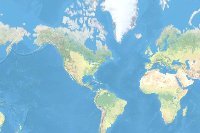

In [4]:
training_data = gis.content.get('d284e2083b254f6b8508f9cf41f53713')
training_data

In [5]:
filepath = training_data.download(file_name=training_data.name)

In [6]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [7]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

`prepare_data` function takes path to training data and creates a fast.ai databunch with specified transformation, batch size, split percentage, etc.

In [8]:
data = prepare_data(data_path,
                    chip_size=256,
                    dataset_type='ChangeDetection', 
                    batch_size=4
                   )

### Visualize training data

To get a sense of what the training data looks like, use the `show_batch()` method to randomly pick a few training chips and visualize them. The chips are overlaid with masks representing the building footprints in each image chip.

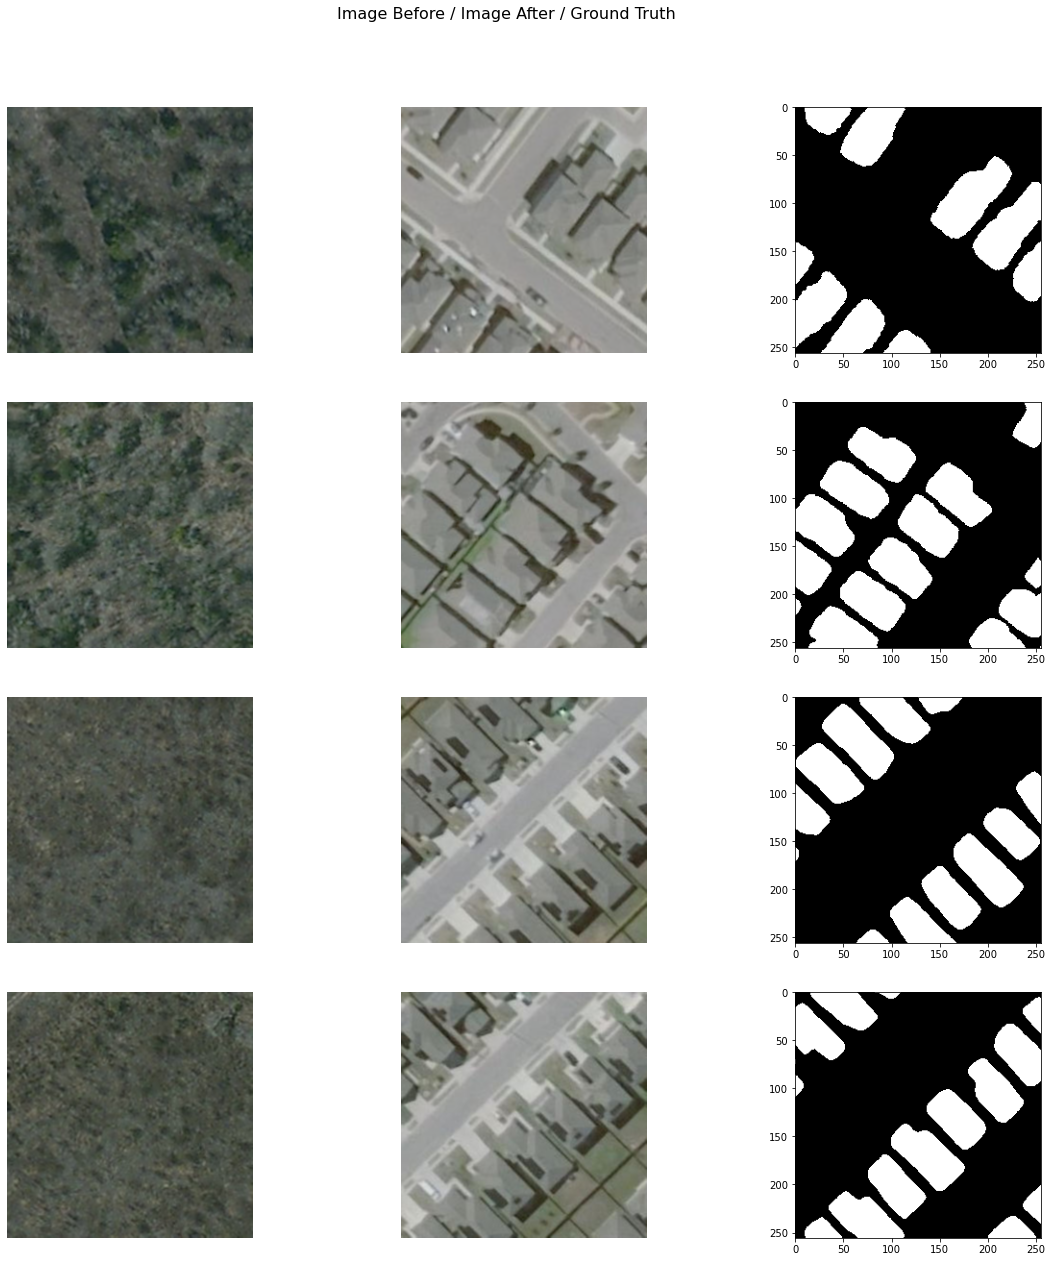

In [9]:
data.show_batch()

### Load model architecture

`arcgis.learn` provides the `ChangeDetector` model for identifying areas of persistent change tasks, which is based on a pretrained convnet, like ResNet that acts as the 'backbone'. More details about `ChangeDetector` can be found [here](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#changedetector).

In [10]:
cd = ChangeDetector(data, backbone='resnet50')

### Train the model

Learning rate is one of the most important hyperparameters in model training. We will use the `lr_find()` method to find an optimum learning rate at which we can train a robust model.

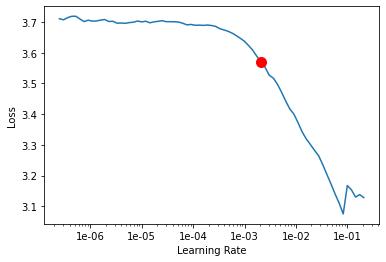

In [11]:
lr = cd.lr_find()

We are using the suggested learning rate above to train the model for 100 epochs.

In [12]:
cd.fit(epochs=100, lr=lr)

epoch,train_loss,valid_loss,precision,recall,f1,time
0,3.638555,3.991394,0.000000,0.000000,0.000000,00:20
1,3.582145,3.903615,0.010081,0.001951,0.003269,00:20
2,3.466630,3.788659,0.030716,0.006106,0.007622,00:20
3,3.358837,3.639781,0.178360,0.023884,0.028300,00:20
4,3.222972,3.582598,0.098645,0.022828,0.027191,00:20
5,3.094626,3.514014,0.059211,0.012516,0.015210,00:20
6,2.952846,3.327957,0.121138,0.017289,0.026279,00:20
7,2.781697,3.187927,0.211084,0.011377,0.020099,00:20
8,2.627799,2.962456,0.462556,0.023596,0.042361,00:20
9,2.474419,2.966377,0.374113,0.009325,0.017576,00:20


We have further trained the model for 100 more epochs to improve model performance. For the sake of time, the cell below is commented out.  

In [ ]:
# cd.fit(100)

### Visualize detected changes

It's a good practice to see results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model within the notebook.

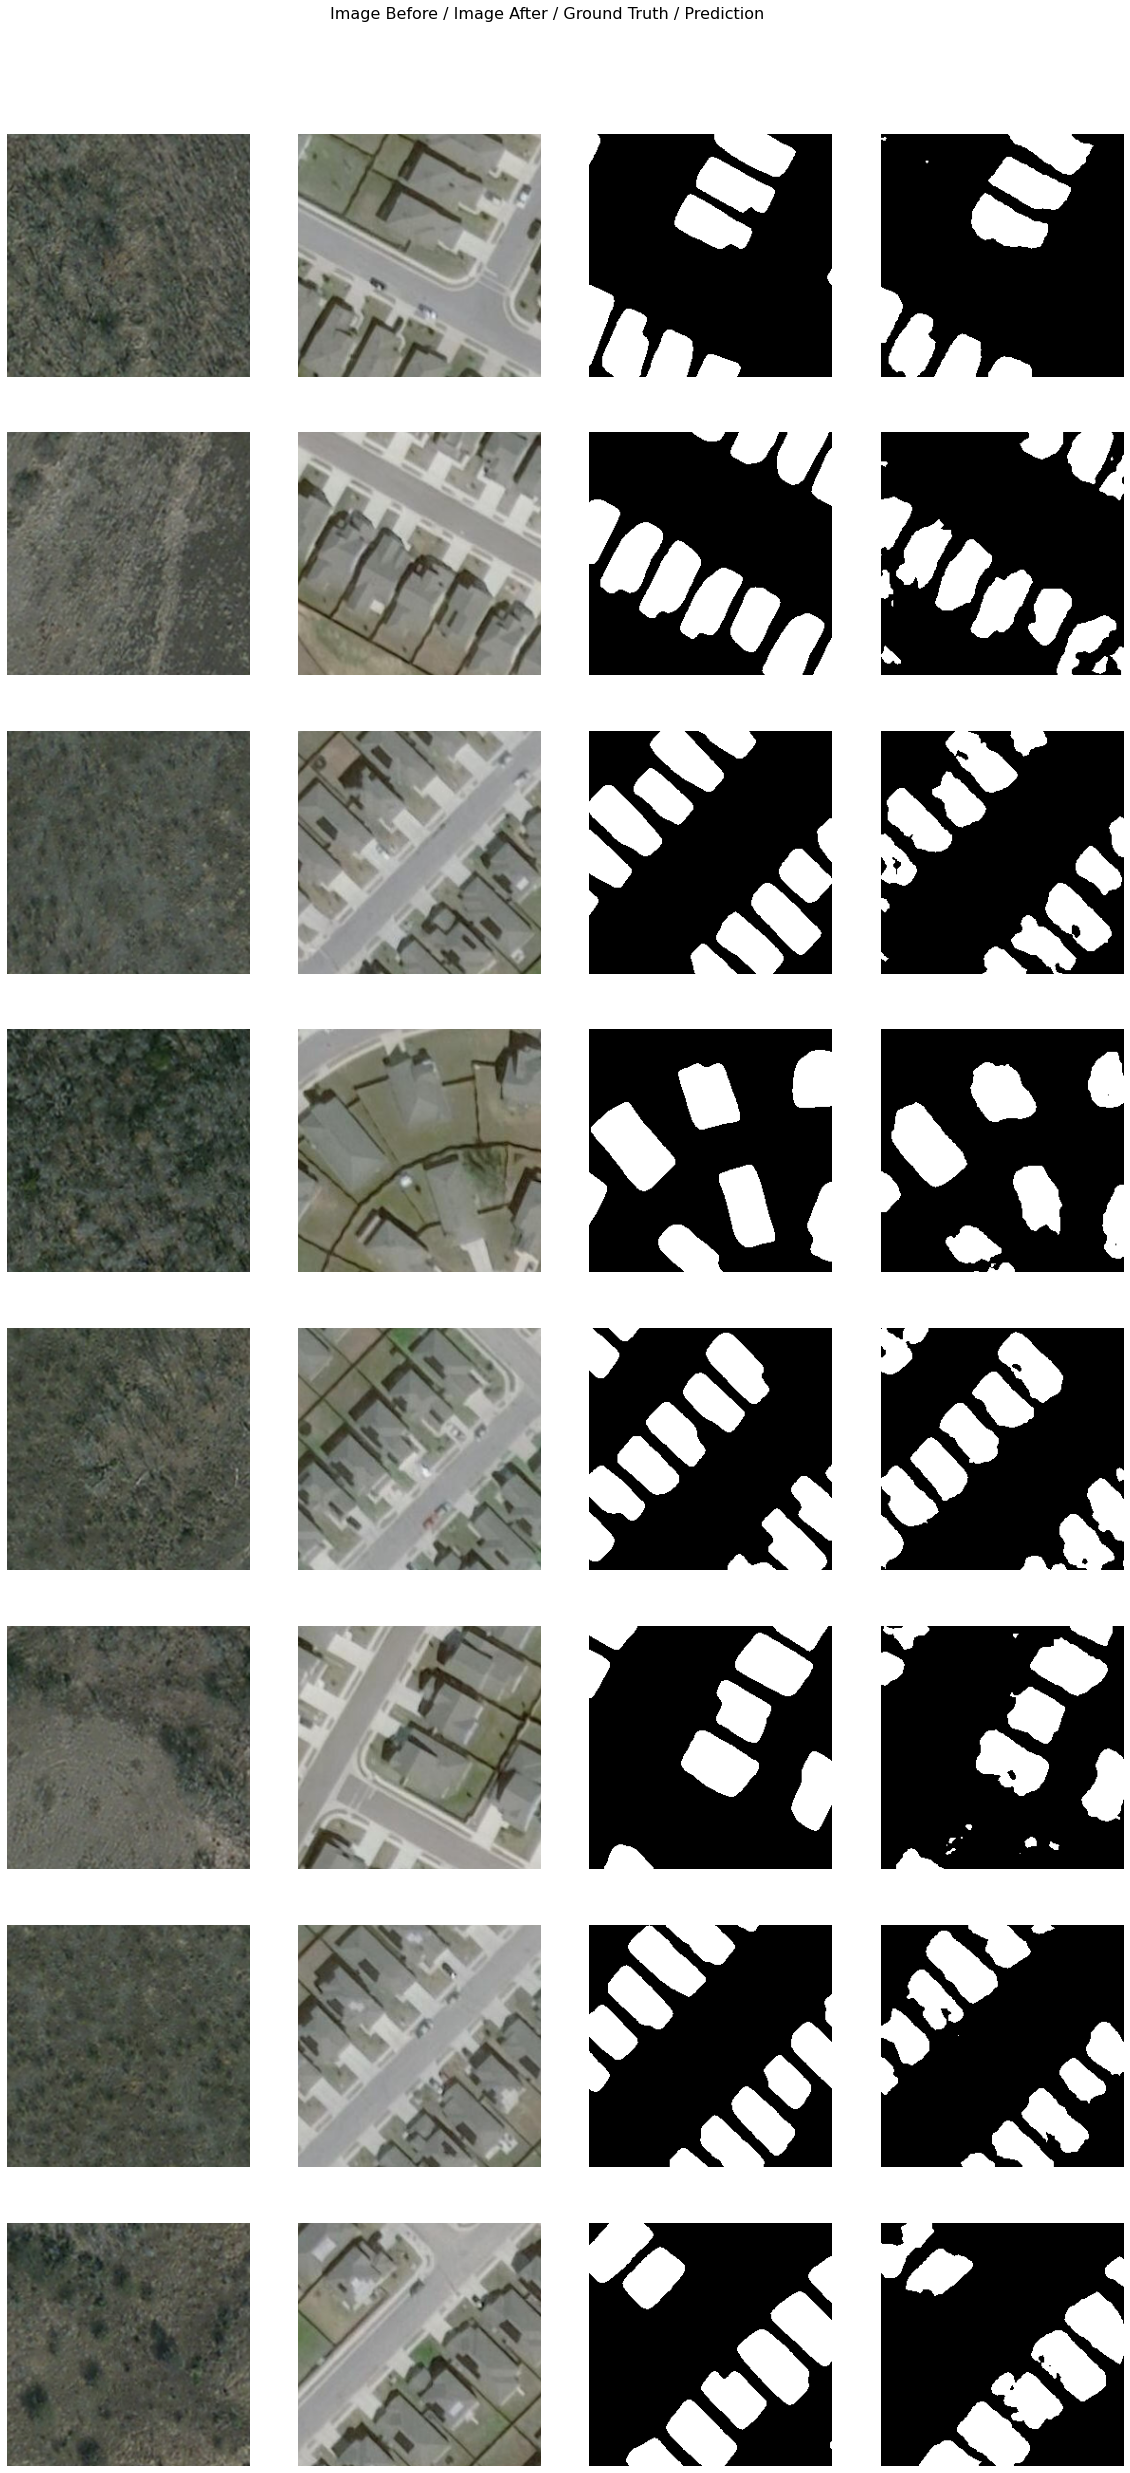

In [17]:
cd.show_results(rows=8) 

### Evaluate model performance

As we have 2 classes for this change detection task, we need to do accuracy assessment for each of those. For that ArcGIS API for Python provides `precision_recall_score` function that will calculate precision and recall for each class.

In [14]:
cd.precision_recall_score()

,NoChange,Change
precision,0.936954,0.926067
recall,0.970100,0.848920
f1,0.953147,0.885244


### Save model

We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [ ]:
cd.save('change_detection_model_e200')

## Model inference

Using `predict` function, we can apply the trained model on a test image/area to detect changes that occurred in the satellite images during two different time periods. 

<Item title:"cd_inference_data" type:Image Collection owner:api_data_owner>
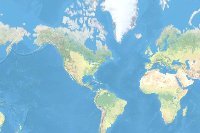

In [19]:
inference_data = gis.content.get('6b32a534228b44b284c14e75b3d3f5f5')
inference_data

In [20]:
test_path = inference_data.download(file_name=inference_data.name)

In [21]:
import zipfile
with zipfile.ZipFile(test_path, 'r') as zip_ref:
    zip_ref.extractall(Path(test_path).parent)

In [22]:
test_images = Path(os.path.join(os.path.splitext(test_path)[0]))

In [23]:
before_img = os.path.join(test_images, 'before.tif')
after_img = os.path.join(test_images, 'after.tif')

The predict function takes in before and after image path as required variables. You can optionally pass `visualize=True` if you want to see the results in the notebook. Additionally, you can pass `save=True` function in order to save the image to the local disk.

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

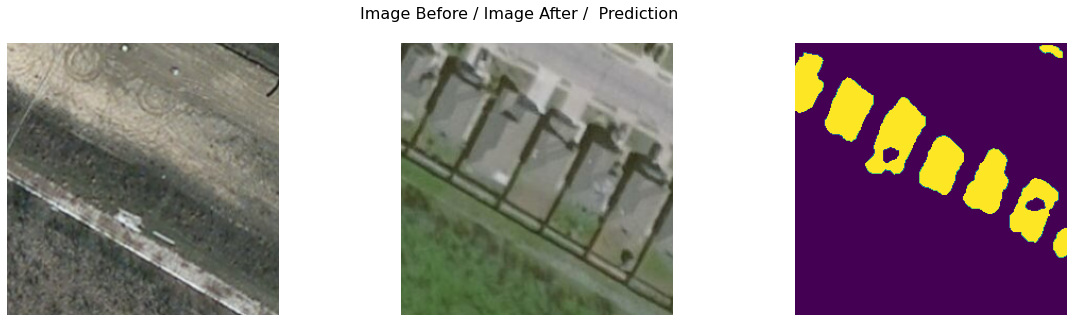

In [24]:
cd.predict(before_image=before_img,
           after_image=after_img,
           visualize=True)

## Conclusion

In this notebook, we learned how to solve various problems like identifying new construction. The same workflow can also be used to find out which new roads have come up in the past five years for instance. With just some labeled data and with little to no human involvement by using deep learning, we can now perform change detection using satellite images.

## References

- https://developers.arcgis.com/python/guide/how-change-detection-works/